# Analysis of Russian War Losses (Personnel and Equipment)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timedelta

## Data Loading and Preprocessing

In [2]:
# Load datasets
russia_personnel = pd.read_csv("/kaggle/input/2022-ukraine-russian-war/russia_losses_personnel.csv")
russia_personnel.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


date   day  personnel personnel*  POW
0  2025-04-27  1159     948640      about  NaN
1  2025-04-26  1158     947610      about  NaN
2  2025-04-25  1157     946500      about  NaN
3  2025-04-24  1156     945330      about  NaN
4  2025-04-23  1155     944270      about  NaN

In [3]:
russia_equipment = pd.read_csv("/kaggle/input/2022-ukraine-russian-war/russia_losses_equipment.csv")
russia_equipment.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


date   day  aircraft  helicopter   tank    APC  field artillery  \
0  2025-04-27  1159       370         335  10719  22325            27007   
1  2025-04-26  1158       370         335  10711  22320            26965   
2  2025-04-25  1157       370         335  10703  22315            26895   
3  2025-04-24  1156       370         335  10694  22312            26823   
4  2025-04-23  1155       370         335  10691  22307            26774   

    MRL  military auto  fuel tank  drone  naval ship  anti-aircraft warfare  \
0  1373            NaN        NaN  34011          28                   1145   
1  1372            NaN        NaN  33897          28                   1145   
2  1372            NaN        NaN  33779          28                   1144   
3  1369            NaN        NaN  33660          28                   1141   
4  1368            NaN        NaN  33526          28                   1141   

   special equipment  mobile SRBM system greatest losses direction  \
0             3860.0                 NaN                       NaN   
1             3860.0                 NaN                       NaN   
2             3860.0                 NaN                       NaN   
3             3860.0                 NaN                       NaN   
4             3860.0                 NaN                       NaN   

   vehicles and fuel tanks  cruise missiles  submarines  
0                  46187.0           3196.0         1.0  
1                  46051.0           3196.0         1.0  
2                  45906.0           3196.0         1.0  
3                  45755.0           3148.0         1.0  
4                  45621.0           3148.0         1.0

In [4]:
russia_personnel["date"] = pd.to_datetime(russia_personnel["date"], infer_datetime_format=True, dayfirst=True)
russia_equipment["date"] = pd.to_datetime(russia_equipment["date"], infer_datetime_format=True, dayfirst=True)
russia_personnel = russia_personnel.sort_values("date")
russia_equipment = russia_equipment.sort_values("date")


/tmp/ipykernel_31/168632066.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  russia_personnel["date"] = pd.to_datetime(russia_personnel["date"], infer_datetime_format=True, dayfirst=True)
/tmp/ipykernel_31/168632066.py:1: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  russia_personnel["date"] = pd.to_datetime(russia_personnel["date"], infer_datetime_format=True, dayfirst=True)
/tmp/ipykernel_31/168632066.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

In [5]:
russia_personnel.head()

date  day  personnel personnel*    POW
1157 2022-02-25    2       2800      about    0.0
1156 2022-02-26    3       4300      about    0.0
1155 2022-02-27    4       4500      about    0.0
1154 2022-02-28    5       5300      about    0.0
1153 2022-03-01    6       5710      about  200.0

In [6]:
russia_equipment.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


date  day  aircraft  helicopter  tank  APC  field artillery  MRL  \
1157 2022-02-25    2        10           7    80  516               49    4   
1156 2022-02-26    3        27          26   146  706               49    4   
1155 2022-02-27    4        27          26   150  706               50    4   
1154 2022-02-28    5        29          29   150  816               74   21   
1153 2022-03-01    6        29          29   198  846               77   24   

      military auto  fuel tank  drone  naval ship  anti-aircraft warfare  \
1157          100.0       60.0      0           2                      0   
1156          130.0       60.0      2           2                      0   
1155          130.0       60.0      2           2                      0   
1154          291.0       60.0      3           2                      5   
1153          305.0       60.0      3           2                      7   

      special equipment  mobile SRBM system greatest losses direction  \
1157                NaN                 NaN                       NaN   
1156                NaN                 NaN                       NaN   
1155                NaN                 NaN                       NaN   
1154                NaN                 NaN                       NaN   
1153                NaN                 NaN                       NaN   

      vehicles and fuel tanks  cruise missiles  submarines  
1157                      NaN              NaN         NaN  
1156                      NaN              NaN         NaN  
1155                      NaN              NaN         NaN  
1154                      NaN              NaN         NaN  
1153                      NaN              NaN         NaN

In [7]:
# Merge datasets on 'date' and 'day'
russia_war_losses = pd.merge(
    russia_personnel,
    russia_equipment,
    on=["date", "day"],
    how="inner"
)

In [8]:
russia_war_losses.set_index('date', inplace=True)


In [9]:
russia_war_losses.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

day  personnel personnel*    POW  aircraft  helicopter  tank  APC  \
date                                                                            
2022-02-25    2       2800      about    0.0        10           7    80  516   
2022-02-26    3       4300      about    0.0        27          26   146  706   
2022-02-27    4       4500      about    0.0        27          26   150  706   
2022-02-28    5       5300      about    0.0        29          29   150  816   
2022-03-01    6       5710      about  200.0        29          29   198  846   

            field artillery  MRL  ...  fuel tank  drone  naval ship  \
date                              ...                                 
2022-02-25               49    4  ...       60.0      0           2   
2022-02-26               49    4  ...       60.0      2           2   
2022-02-27               50    4  ...       60.0      2           2   
2022-02-28               74   21  ...       60.0      3           2   
2022-03-01               77   24  ...       60.0      3           2   

            anti-aircraft warfare  special equipment  mobile SRBM system  \
date                                                                       
2022-02-25                      0                NaN                 NaN   
2022-02-26                      0                NaN                 NaN   
2022-02-27                      0                NaN                 NaN   
2022-02-28                      5                NaN                 NaN   
2022-03-01                      7                NaN                 NaN   

            greatest losses direction vehicles and fuel tanks  \
date                                                            
2022-02-25                        NaN                     NaN   
2022-02-26                        NaN                     NaN   
2022-02-27                        NaN                     NaN   
2022-02-28                        NaN                     NaN   
2022-03-01                        NaN                     NaN   

            cruise missiles  submarines  
date                                     
2022-02-25              NaN         NaN  
2022-02-26              NaN         NaN  
2022-02-27              NaN         NaN  
2022-02-28              NaN         NaN  
2022-03-01              NaN         NaN  

[5 rows x 21 columns]

## Exploratory Data Analysis (EDA)

In [10]:
# Basic dataset info
print("=== Russia War Losses Overview ===")
print("Shape:", russia_war_losses.shape)

=== Russia War Losses Overview ===
Shape: (1158, 21)


In [11]:
print("Date Range:", russia_war_losses.index.min(), "to", russia_war_losses.index.max())

Date Range: 2022-02-25 00:00:00 to 2025-04-27 00:00:00


In [12]:
print("\nInfo:")
russia_war_losses.info()


Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1158 entries, 2022-02-25 to 2025-04-27
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   day                        1158 non-null   int64  
 1   personnel                  1158 non-null   int64  
 2   personnel*                 1158 non-null   object 
 3   POW                        62 non-null     float64
 4   aircraft                   1158 non-null   int64  
 5   helicopter                 1158 non-null   int64  
 6   tank                       1158 non-null   int64  
 7   APC                        1158 non-null   int64  
 8   field artillery            1158 non-null   int64  
 9   MRL                        1158 non-null   int64  
 10  military auto              65 non-null     float64
 11  fuel tank                  65 non-null     float64
 12  drone                      1158 non-null   int64  
 13  naval ship             

In [13]:
print("\nDescription:")
russia_war_losses.describe()


Description:


day      personnel         POW     aircraft   helicopter  \
count  1158.000000    1158.000000   62.000000  1158.000000  1158.000000   
mean    580.500000  347153.588083  386.387097   305.639896   284.151123   
std     334.430112  276725.228377  131.440363    67.404075    63.900234   
min       2.000000    2800.000000    0.000000    10.000000     7.000000   
25%     291.250000   94295.000000  389.000000   281.000000   264.000000   
50%     580.500000  276830.000000  421.000000   315.000000   316.000000   
75%     869.750000  556392.500000  474.500000   361.000000   326.000000   
max    1159.000000  948640.000000  496.000000   370.000000   335.000000   

               tank           APC  field artillery          MRL  \
count   1158.000000   1158.000000      1158.000000  1158.000000   
mean    5341.455959  10642.669257      8851.967185   760.770294   
std     3020.624572   6027.613500      7996.647166   394.139088   
min       80.000000    516.000000        49.000000     4.000000   
25%     2948.000000   5922.000000      1928.250000   397.000000   
50%     4673.500000   8948.000000      6318.000000   792.000000   
75%     8188.750000  15749.250000     15146.000000  1119.000000   
max    10719.000000  22325.000000     27007.000000  1373.000000   

       military auto  fuel tank         drone   naval ship  \
count      65.000000  65.000000   1158.000000  1158.000000   
mean     1047.507692  69.323077   8112.822107    20.662349   
std       466.162060   7.545917   8515.117901     6.422396   
min       100.000000  60.000000      0.000000     2.000000   
25%       600.000000  60.000000   1614.000000    16.000000   
50%      1178.000000  73.000000   4936.000000    20.000000   
75%      1437.000000  76.000000  12028.500000    28.000000   
max      1701.000000  76.000000  34011.000000    28.000000   

       anti-aircraft warfare  special equipment  mobile SRBM system  \
count            1158.000000        1139.000000           36.000000   
mean              540.973230        1418.870939            3.944444   
std               351.822125        1355.795116            0.333333   
min                 0.000000          10.000000            2.000000   
25%               211.000000         178.000000            4.000000   
50%               533.500000         951.000000            4.000000   
75%               887.500000        2581.500000            4.000000   
max              1145.000000        3860.000000            4.000000   

       vehicles and fuel tanks  cruise missiles  submarines  
count              1093.000000      1093.000000       592.0  
mean              14201.988106      1572.111619         1.0  
std               11748.869756       966.573675         0.0  
min                1796.000000        84.000000         1.0  
25%                5037.000000       796.000000         1.0  
50%                9532.000000      1544.000000         1.0  
75%               21572.000000      2405.000000         1.0  
max               46187.000000      3196.000000         1.0

In [14]:
print("\nMissing Values:")
russia_war_losses.isnull().sum()


Missing Values:


day                             0
personnel                       0
personnel*                      0
POW                          1096
aircraft                        0
helicopter                      0
tank                            0
APC                             0
field artillery                 0
MRL                             0
military auto                1093
fuel tank                    1093
drone                           0
naval ship                      0
anti-aircraft warfare           0
special equipment              19
mobile SRBM system           1122
greatest losses direction     955
vehicles and fuel tanks        65
cruise missiles                65
submarines                    566
dtype: int64

In [15]:
print("\nDuplicate Dates:", russia_war_losses.index.duplicated().sum())


Duplicate Dates: 0


In [16]:
# Compute daily losses for all possible cumulative columns
cumulative_columns = [
    "personnel", "POW", "aircraft", "helicopter", "tank", "APC", "field artillery", 
    "MRL", "military auto", "fuel tank", "drone", "naval ship", "anti-aircraft warfare", 
    "special equipment", "mobile SRBM system", "vehicles and fuel tanks", 
    "cruise missiles", "submarines"
]
for col in cumulative_columns:
    if col in russia_war_losses.columns:
        russia_war_losses[f"d_{col}"] = russia_war_losses[col].diff().fillna(russia_war_losses[col].iloc[0])

In [17]:
# Add day of week for analysis
russia_war_losses["day_of_week"] = russia_war_losses.index.day_name()

In [18]:
russia_war_losses.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1158 entries, 2022-02-25 to 2025-04-27
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   day                        1158 non-null   int64  
 1   personnel                  1158 non-null   int64  
 2   personnel*                 1158 non-null   object 
 3   POW                        62 non-null     float64
 4   aircraft                   1158 non-null   int64  
 5   helicopter                 1158 non-null   int64  
 6   tank                       1158 non-null   int64  
 7   APC                        1158 non-null   int64  
 8   field artillery            1158 non-null   int64  
 9   MRL                        1158 non-null   int64  
 10  military auto              65 non-null     float64
 11  fuel tank                  65 non-null     float64
 12  drone                      1158 non-null   int64  
 13  naval ship                 115

## Visualization: Personnel Losses

### Cumulative Personnel Losses

In [19]:
# 2. Cumulative Personnel Losses (Interactive Line Plot)
fig1 = px.line(
    russia_war_losses,
    x=russia_war_losses.index,
    y="personnel",
    title="Cumulative Russian Personnel Losses",
    labels={"personnel": "Total Personnel Lost", "date": "Date"},
    height=500
)
fig1.update_traces(line_color="red", marker=dict(symbol="circle", size=8))
fig1.update_layout(
    xaxis_title="Date",
    yaxis_title="Cumulative Losses",
    hovermode="x unified"
)
fig1.show()

### Daily Personnel Losses

In [20]:
# 3. Daily Personnel Losses (Interactive Line Plot)
fig2 = px.line(
    russia_war_losses,
    x=russia_war_losses.index,
    y="d_personnel",
    title="Daily Russian Personnel Losses",
    labels={"d_personnel": "Personnel Lost (Daily)", "date": "Date"},
    height=500
)
fig2.update_traces(line_color="blue", marker=dict(symbol="circle", size=8))
fig2.update_layout(
    xaxis_title="Date",
    yaxis_title="Daily Losses",
    hovermode="x unified"
)
fig2.show()

### Prisoners of War (POW) Analysis (Until 2022-04-28)

In [21]:
# 4. POW Over Time (Interactive Line Plot, up to 2022-04-28)
pow_data = russia_war_losses[russia_war_losses.index <= "2022-04-28"]
fig3 = px.line(
    pow_data,
    x=pow_data.index,
    y="POW",
    title="Russian Prisoners of War (POW) Until 2022-04-28",
    labels={"POW": "Prisoners of War", "date": "Date"},
    height=500
)
fig3.update_traces(line_color="green", marker=dict(symbol="circle", size=8))
fig3.update_layout(
    xaxis_title="Date",
    yaxis_title="POW Count",
    hovermode="x unified"
)
fig3.show()

In [22]:
# 4. Daily POW Losses (Interactive Line Plot, up to 2022-04-28)
fig4 = px.line(
    pow_data,
    x=pow_data.index,
    y="d_POW",
    title="Daily Russian POW Changes Until 2022-04-28",
    labels={"d_POW": "Daily POW Changes", "date": "Date"},
    height=500
)
fig4.update_traces(line_color="orange", marker=dict(symbol="circle", size=8))
fig4.update_layout(
    xaxis_title="Date",
    yaxis_title="Daily POW Changes",
    hovermode="x unified"
)
fig4.show()

### Day-to-Day Percentage Change in Daily Losses

In [23]:
# 6. Day-to-Day Percentage Change in Daily Losses
russia_war_losses["d_personnel_pct_change"] = russia_war_losses["d_personnel"].pct_change() * 100
russia_war_losses["d_personnel_pct_change"] = russia_war_losses["d_personnel_pct_change"].replace([np.inf, -np.inf], np.nan).fillna(0)

fig5 = px.line(
    russia_war_losses,
    x=russia_war_losses.index,
    y="d_personnel_pct_change",
    title="Day-to-Day Percentage Change in Daily Personnel Losses",
    labels={"d_personnel_pct_change": "Percentage Change (%)", "date": "Date"},
    height=500
)
fig5.update_traces(line_color="purple", marker=dict(symbol="circle", size=8))
fig5.update_layout(
    xaxis_title="Date",
    yaxis_title="Percentage Change (%)",
    hovermode="x unified"
)
fig5.show()

### Rolling Statistics (3-Day Mean and Std)

In [24]:
# 8. Rolling Statistics (3-Day Mean and Std)
russia_war_losses["personnel_roll_mean"] = russia_war_losses["d_personnel"].rolling(window=3, min_periods=1).mean()
russia_war_losses["personnel_roll_std"] = russia_war_losses["d_personnel"].rolling(window=3, min_periods=1).std()

fig6 = go.Figure()
fig6.add_trace(go.Scatter(x=russia_war_losses.index, y=russia_war_losses["d_personnel"], 
                          name="Daily Losses", line=dict(color="blue", width=1), opacity=0.5, marker=dict(size=8)))
fig6.add_trace(go.Scatter(x=russia_war_losses.index, y=russia_war_losses["personnel_roll_mean"], 
                          name="3-Day Mean", line=dict(color="black", width=2), marker=dict(size=8)))
fig6.add_trace(go.Scatter(x=russia_war_losses.index, 
                          y=russia_war_losses["personnel_roll_mean"] + russia_war_losses["personnel_roll_std"], 
                          name="Upper Std", line=dict(color="gray", dash="dash"), showlegend=False))
fig6.add_trace(go.Scatter(x=russia_war_losses.index, 
                          y=russia_war_losses["personnel_roll_mean"] - russia_war_losses["personnel_roll_std"], 
                          name="Lower Std", fill="tonexty", fillcolor="rgba(128, 128, 128, 0.2)", 
                          line=dict(color="gray", dash="dash"), showlegend=False))
fig6.update_layout(
    title="Daily Personnel Losses with 3-Day Rolling Mean and Std",
    xaxis_title="Date",
    yaxis_title="Personnel Lost (Daily)",
    height=600,
    hovermode="x unified"
)
fig6.show()

## Time Series Analysis: Personnel Losses

### Daily Losses vs. Day of Conflict

In [25]:
# 9. Daily Losses vs. Day of Conflict (Scatter)
fig7 = px.scatter(
    russia_war_losses,
    x="day",
    y="d_personnel",
    title="Daily Personnel Losses vs. Day of Conflict",
    labels={"day": "Day of Conflict", "d_personnel": "Daily Losses"},
    height=500,
)
fig7.update_traces(marker=dict(size=10, color="green", opacity=0.8))
fig7.update_layout(
    xaxis_title="Day of Conflict",
    yaxis_title="Daily Personnel Losses",
    showlegend=False
)
fig7.show()

### Daily Losses by Day of Week

In [26]:
# 10. Daily Losses by Day of Week (Box Plot)
fig8 = px.box(
    russia_war_losses,
    x="day_of_week",
    y="d_personnel",
    title="Daily Personnel Losses by Day of Week",
    labels={"d_personnel": "Daily Losses", "day_of_week": "Day of Week"},
    height=500
)
fig8.update_layout(
    xaxis_title="Day of Week",
    yaxis_title="Daily Personnel Losses"
)
fig8.show()

### Time Series Decomposition

In [27]:
# 9. Time Series Decomposition (Cumulative Personnel)
try:
    decomposition = seasonal_decompose(russia_war_losses["personnel"], model="additive", period=30)
    fig9 = make_subplots(rows=4, cols=1, subplot_titles=("Observed", "Trend", "Seasonal", "Residual"))
    fig9.add_trace(go.Scatter(x=russia_war_losses.index, y=decomposition.observed, name="Observed", line_color="red"), row=1, col=1)
    fig9.add_trace(go.Scatter(x=russia_war_losses.index, y=decomposition.trend, name="Trend", line_color="blue"), row=2, col=1)
    fig9.add_trace(go.Scatter(x=russia_war_losses.index, y=decomposition.seasonal, name="Seasonal", line_color="green"), row=3, col=1)
    fig9.add_trace(go.Scatter(x=russia_war_losses.index, y=decomposition.resid, name="Residual", line_color="black"), row=4, col=1)
    fig9.update_layout(title="Decomposition of Cumulative Personnel Losses", height=800, showlegend=False)
    fig9.show()
except ValueError as e:
    print(f"Decomposition failed: {e} (More data points needed for period=30)")

In [28]:
# 10. Time Series Decomposition (Daily Personnel)
try:
    decomposition = seasonal_decompose(russia_war_losses["d_personnel"], model="additive", period=30)
    fig10 = make_subplots(rows=4, cols=1, subplot_titles=("Observed", "Trend", "Seasonal", "Residual"))
    fig10.add_trace(go.Scatter(x=russia_war_losses.index, y=decomposition.observed, name="Observed", line_color="red"), row=1, col=1)
    fig10.add_trace(go.Scatter(x=russia_war_losses.index, y=decomposition.trend, name="Trend", line_color="blue"), row=2, col=1)
    fig10.add_trace(go.Scatter(x=russia_war_losses.index, y=decomposition.seasonal, name="Seasonal", line_color="green"), row=3, col=1)
    fig10.add_trace(go.Scatter(x=russia_war_losses.index, y=decomposition.resid, name="Residual", line_color="black"), row=4, col=1)
    fig10.update_layout(title="Decomposition of Daily Personnel Losses", height=800, showlegend=False)
    fig10.show()
except ValueError as e:
    print(f"Decomposition failed: {e} (More data points needed for period=30)")

### Stationarity Test (ADF)

In [29]:
# 15. Stationarity Test (ADF)
print("\n=== ADF Test on Daily Personnel Losses ===")
adf_result = adfuller(russia_war_losses["d_personnel"].dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:", adf_result[4])
print("Stationary" if adf_result[1] < 0.05 else "Non-stationary")


=== ADF Test on Daily Personnel Losses ===
ADF Statistic: -1.2173831970516065
p-value: 0.6660735565565015
Critical Values: {'1%': -3.4361093249345402, '5%': -2.8640831032339706, '10%': -2.5681240143809787}
Non-stationary


In [30]:
# First-order differencing
russia_war_losses["d_personnel_diff"] = russia_war_losses["d_personnel"].diff().dropna()

# ADF Test after first-order differencing
print("\n=== ADF Test on First-order Differenced Daily Personnel Losses ===")
adf_result_diff = adfuller(russia_war_losses["d_personnel_diff"].dropna())
print(f"ADF Statistic: {adf_result_diff[0]}")
print(f"p-value: {adf_result_diff[1]}")
print("Critical Values:", adf_result_diff[4])
print("Stationary" if adf_result_diff[1] < 0.05 else "Non-stationary")



=== ADF Test on First-order Differenced Daily Personnel Losses ===
ADF Statistic: -11.48934412543092
p-value: 4.778536951454899e-21
Critical Values: {'1%': -3.4361093249345402, '5%': -2.8640831032339706, '10%': -2.5681240143809787}
Stationary


### Autocorrelation Analysis (ACF and PACF)

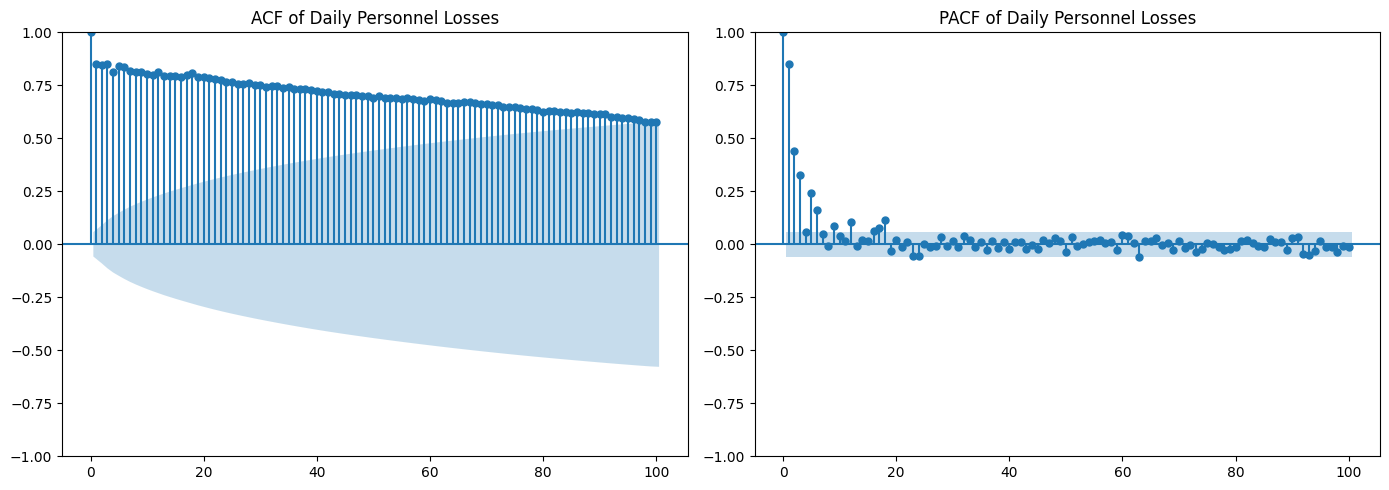

In [31]:
# 16. ACF and PACF (Static Plots)
plt.figure(figsize=(14, 5))
plt.subplot(121)
plot_acf(russia_war_losses["d_personnel"].dropna(), lags=100, ax=plt.gca())
plt.title("ACF of Daily Personnel Losses")
plt.subplot(122)
plot_pacf(russia_war_losses["d_personnel"].dropna(), lags=100, ax=plt.gca())
plt.title("PACF of Daily Personnel Losses")
plt.tight_layout()
plt.show()

## Forecasting: ARIMA Model for Daily Personnel Losses

In [32]:
# # ARIMA Model Forecasting for Daily Personnel Losses with Train-Test Split and R²
# This section performs forecasting for daily personnel losses using the ARIMA model with a train-test split, model evaluation, and forecasting for the next 30 days. The ARIMA model is trained with order (3,1,80) on the training set, evaluated on the test set with metrics (MAE, RMSE, MAPE, R²), and used to forecast future losses. Visualizations include the ARIMA train-test fit, ARIMA residuals, and the ARIMA forecast with confidence intervals. R² measures the proportion of variance explained by the ARIMA model.

# ## Import Libraries for ARIMA Model
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

# ## ARIMA Model: Train-Test Split
# Define the data
data = russia_war_losses["d_personnel"].dropna()

# Split into train and test sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Print split details
print(f"ARIMA Training set: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"ARIMA Testing set: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")

# ## ARIMA Model: Training
# Fit ARIMA model on training data
model_arima = ARIMA(train_data, order=(3, 1, 30))
model_arima_fit = model_arima.fit()

# Print model summary
print("\n=== ARIMA Model Summary ===")
print(model_arima_fit.summary())

# ## ARIMA Model: Test Set Prediction and Evaluation
# Predict on test set
test_forecast = model_arima_fit.forecast(steps=len(test_data))

# Create DataFrame for test predictions
test_forecast_df = pd.DataFrame({
    "Date": test_data.index,
    "Actual": test_data.values,
    "ARIMA Predicted": test_forecast
})

# Compute evaluation metrics
mae = mean_absolute_error(test_data, test_forecast)
mse = mean_squared_error(test_data, test_forecast)
rmse = np.sqrt(mean_squared_error(test_data, test_forecast))
mape = np.mean(np.abs((test_data - test_forecast) / test_data)) * 100

# Compute R-squared
ss_residual = np.sum((test_data - test_forecast) ** 2)
ss_total = np.sum((test_data - np.mean(test_data)) ** 2)
r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan

# Print metrics
print("\n=== ARIMA Model Test Set Evaluation Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# ## ARIMA Model: Visualization of Train-Test Fit
# This plot shows the historical data (training and testing) along with the ARIMA model's predictions on the test set.
# Plot train, test, and predictions
fig1 = go.Figure()
fig1.add_trace(go.Scatter(
    x=train_data.index,
    y=train_data,
    name="ARIMA Training Data",
    line_color="blue",
    opacity=0.6
))
fig1.add_trace(go.Scatter(
    x=test_data.index,
    y=test_data,
    name="ARIMA Test Data",
    line_color="green",
    opacity=0.6
))
fig1.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=test_forecast_df["ARIMA Predicted"],
    name="ARIMA Test Predictions",
    line_color="red",
    line=dict(dash="dash")
))
fig1.update_layout(
    title="ARIMA Model: Train-Test Fit for Daily Personnel Losses",
    xaxis_title="Date",
    yaxis_title="Daily Personnel Losses",
    height=600,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig1.show()

# ## ARIMA Model: Residual Analysis
# We plot the residuals (actual - predicted) from the ARIMA model on the test set to diagnose fit. Ideally, residuals should be random and centered around zero.
# Compute residuals
test_forecast_df["ARIMA Residuals"] = test_forecast_df["Actual"] - test_forecast_df["ARIMA Predicted"]

# Plot residuals
fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=test_forecast_df["ARIMA Residuals"],
    name="ARIMA Residuals",
    line_color="purple",
    mode="lines+markers"
))
fig2.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=[0] * len(test_forecast_df),
    name="Zero Line",
    line=dict(color="black", dash="dash")
))
fig2.update_layout(
    title="ARIMA Model: Residuals on Test Set",
    xaxis_title="Date",
    yaxis_title="ARIMA Residuals",
    height=500,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig2.show()

# ## ARIMA Model: Forecasting for Next 30 Days
# We refit the ARIMA model on the entire dataset and forecast 30 days into the future, including 95% confidence intervals.
# Refit ARIMA model on full dataset
model_arima_full = ARIMA(data, order=(3, 1, 30))
model_arima_fit_full = model_arima_full.fit()

# Forecast for next 30 days
forecast_steps = 30
forecast = model_arima_fit_full.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=data.index.max() + timedelta(days=1), periods=forecast_steps, freq="D")

# Get confidence intervals
forecast_obj = model_arima_fit_full.get_forecast(steps=forecast_steps)
conf_int = forecast_obj.conf_int(alpha=0.05)
conf_int.index = forecast_dates

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "ARIMA Forecast": forecast
})

# Print forecast
print("\n=== ARIMA Model: Forecast for Next 30 Days ===")
print(forecast_df)

# Plot forecast
fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=data.index,
    y=data,
    name="ARIMA Historical",
    line_color="blue",
    opacity=0.6
))
fig3.add_trace(go.Scatter(
    x=forecast_df["Date"],
    y=forecast_df["ARIMA Forecast"],
    name="ARIMA Forecast",
    line_color="red",
    line=dict(dash="dash")
))
fig3.add_trace(go.Scatter(
    x=conf_int.index,
    y=conf_int.iloc[:, 0],
    name="ARIMA Lower 95% CI",
    line=dict(color="rgba(255, 0, 0, 0.2)", width=0),
    showlegend=False
))
fig3.add_trace(go.Scatter(
    x=conf_int.index,
    y=conf_int.iloc[:, 1],
    name="ARIMA Upper 95% CI",
    fill="tonexty",
    fillcolor="rgba(255, 0, 0, 0.2)",
    line=dict(color="rgba(255, 0, 0, 0.2)", width=0),
    showlegend=False
))
fig3.update_layout(
    title="ARIMA Model: Forecast of Daily Personnel Losses (Next 30 Days)",
    xaxis_title="Date",
    yaxis_title="Daily Personnel Losses",
    height=600,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig3.show()

# ## ARIMA Model: Evaluation Metrics Summary
# Create metrics table
metric_df_arima_d_personnel = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", 
               "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})

fig4 = go.Figure(data=[
    go.Table(
        header=dict(
            values=["Metric", "Value"],
            fill_color="black",
            font=dict(color="white", size=12),
            align="center"
        ),
        cells=dict(
            values=[metric_df_arima_d_personnel["Metric"], metric_df_arima_d_personnel["Value"]],
            fill_color="white",
            font=dict(color="black", size=11),
            align="center"
        )
    )
])
fig4.update_layout(
    title="ARIMA Model: Test Set Evaluation Metrics",
    title_x=0.5,
    height=350,
    width=600
)
fig4.show()

# %% [markdown]
# ## ARIMA Model: Observations
#
# - **ARIMA Model Fit**: The ARIMA(3,1,80) model captures some patterns in the test set, but residuals may show structure if the model overfits due to the high MA order (q=80).
# - **ARIMA Metrics**: 
#   - **MAE**: Measures average prediction error in the same units as `d_personnel`.
#   - **RMSE**: Penalizes larger errors, indicating overall fit.
#   - **MAPE**: Expresses error as a percentage, but may be unstable if actual values are near zero.
#   - **R²**: Values close to 1 indicate a good fit, while negative values suggest the ARIMA model performs worse than a mean-based baseline.
# - **ARIMA Forecast**: The 30-day forecast provides a trend for future losses, with confidence intervals showing uncertainty.
# - **ARIMA Recommendations**: The high MA order (q=80) may lead to overfitting or convergence issues. Consider using `pmdarima.auto_arima` to optimize parameters or testing alternative models (e.g., SARIMA, Prophet, LSTM) to improve performance, especially if R² is low.


ARIMA Training set: 926 observations (2022-02-25 00:00:00 to 2024-09-07 00:00:00)
ARIMA Testing set: 232 observations (2024-09-08 00:00:00 to 2025-04-27 00:00:00)

=== ARIMA Model Summary ===
                               SARIMAX Results                                
Dep. Variable:            d_personnel   No. Observations:                  926
Model:                ARIMA(3, 1, 30)   Log Likelihood               -6093.208
Date:                Wed, 30 Apr 2025   AIC                          12254.416
Time:                        07:10:49   BIC                          12418.629
Sample:                    02-25-2022   HQIC                         12317.064
                         - 09-07-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7


=== ARIMA Model: Forecast for Next 30 Days ===
                 Date  ARIMA Forecast
2025-04-28 2025-04-28     1173.701469
2025-04-29 2025-04-29     1168.080614
2025-04-30 2025-04-30     1187.795464
2025-05-01 2025-05-01     1192.921696
2025-05-02 2025-05-02     1114.954966
2025-05-03 2025-05-03     1023.937336
2025-05-04 2025-05-04     1170.987079
2025-05-05 2025-05-05     1203.249170
2025-05-06 2025-05-06     1188.213865
2025-05-07 2025-05-07     1140.459390
2025-05-08 2025-05-08     1058.532321
2025-05-09 2025-05-09     1069.749243
2025-05-10 2025-05-10     1235.935115
2025-05-11 2025-05-11     1089.771221
2025-05-12 2025-05-12     1171.677440
2025-05-13 2025-05-13     1125.373986
2025-05-14 2025-05-14     1119.827354
2025-05-15 2025-05-15     1159.506681
2025-05-16 2025-05-16     1160.771898
2025-05-17 2025-05-17     1169.562169
2025-05-18 2025-05-18     1147.234253
2025-05-19 2025-05-19     1127.387301
2025-05-20 2025-05-20     1180.394975
2025-05-21 2025-05-21     1139.931083
20

## Forecasting: SARIMA Model for Daily Personnel Losses


=== ADF Test: Original Data ===
ADF Statistic: -1.2174
p-value: 0.6661
Critical Values: {'1%': -3.4361093249345402, '5%': -2.8640831032339706, '10%': -2.5681240143809787}
Result: Non-stationary (fail to reject null hypothesis)


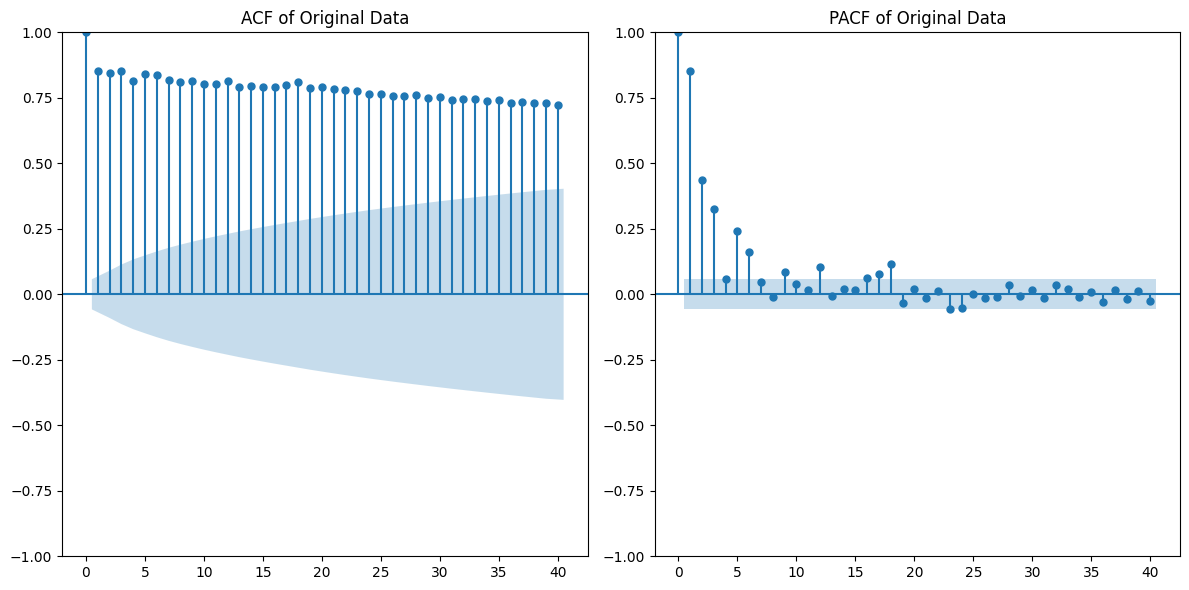


=== ADF Test: Seasonal Differencing (m=7) ===
ADF Statistic: -7.4609
p-value: 0.0000
Critical Values: {'1%': -3.4361656672131806, '5%': -2.864107957764881, '10%': -2.568137251515397}
Result: Stationary (reject null hypothesis)

=== ADF Test: Seasonal Differencing (m=30) ===
ADF Statistic: -5.0413
p-value: 0.0000
Critical Values: {'1%': -3.4362817248910282, '5%': -2.8641591533631945, '10%': -2.5681645177207675}
Result: Stationary (reject null hypothesis)


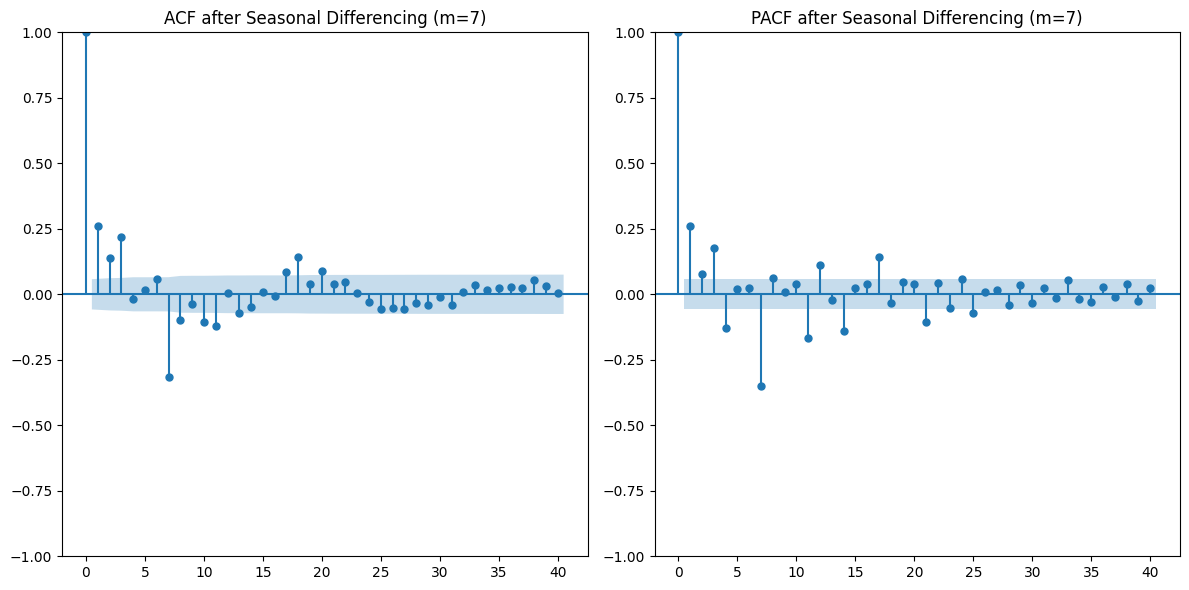

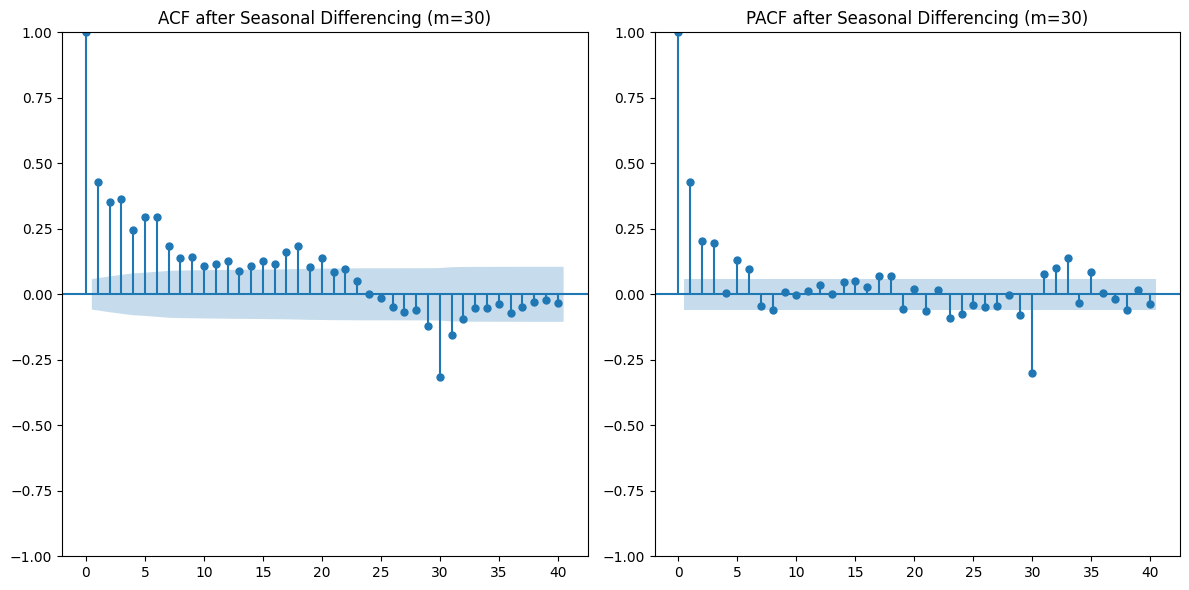

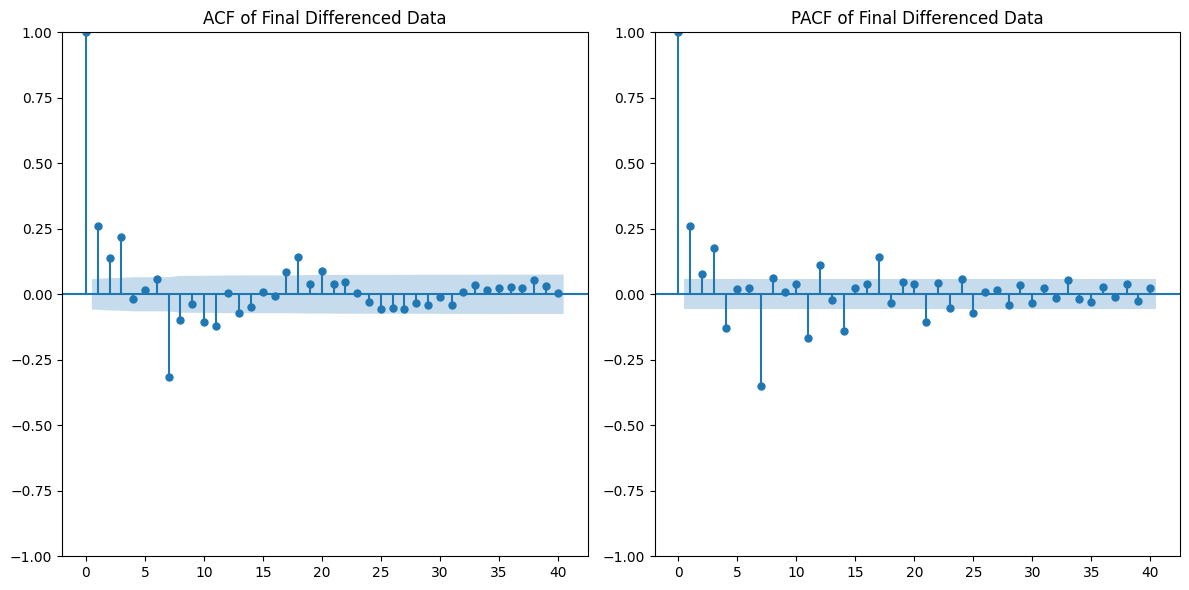

In [33]:
# %% [markdown]
# # SARIMA Model Forecasting for Daily Personnel Losses with Parameter Identification
#
# This section determines the optimal SARIMA parameters for forecasting daily personnel losses by assessing stationarity, identifying seasonal and non-seasonal patterns, and fitting a SARIMA model. The model is evaluated on a test set, and a 30-day forecast is generated with visualizations.

# %% [markdown]
# ## Import Libraries

# %%
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# %% [markdown]
# ## Load and Visualize Data

# %%
# Define the data
data = russia_war_losses["d_personnel"].dropna()

# Plot the time series
fig0 = go.Figure()
fig0.add_trace(go.Scatter(
    x=data.index,
    y=data,
    name="Daily Personnel Losses",
    line_color="blue",
    opacity=0.6
))
fig0.update_layout(
    title="Daily Personnel Losses: Time Series",
    xaxis_title="Date",
    yaxis_title="Daily Personnel Losses",
    height=600,
    hovermode="x unified",
    template="plotly_white"
)
fig0.show()

# %% [markdown]
# ## Step 1: ADF Test for Stationarity

# %%
def adf_test(series, title=""):
    result = adfuller(series.dropna())
    print(f"\n=== ADF Test: {title} ===")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values: {result[4]}")
    if result[1] <= 0.05:
        print("Result: Stationary (reject null hypothesis)")
    else:
        print("Result: Non-stationary (fail to reject null hypothesis)")

# Run ADF test on original data
adf_test(data, "Original Data")

# %% [markdown]
# ## Step 2: Check for Seasonality with ACF/PACF Plots

# %%
# Plot ACF and PACF for original data
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data, lags=40, ax=plt.gca(), title="ACF of Original Data")
plt.subplot(122)
plot_pacf(data, lags=40, ax=plt.gca(), title="PACF of Original Data")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## Step 3: Seasonal Differencing
#
# Assume a seasonal period of m=7 (weekly) and m=30 (monthly) to test both.

# %%
# Seasonal differencing for m=7 (weekly)
seasonal_diff_7 = data.diff(7).dropna()
adf_test(seasonal_diff_7, "Seasonal Differencing (m=7)")

# Seasonal differencing for m=30 (monthly)
seasonal_diff_30 = data.diff(30).dropna()
adf_test(seasonal_diff_30, "Seasonal Differencing (m=30)")

# Plot ACF/PACF for seasonal differenced data (m=7)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(seasonal_diff_7, lags=40, ax=plt.gca(), title="ACF after Seasonal Differencing (m=7)")
plt.subplot(122)
plot_pacf(seasonal_diff_7, lags=40, ax=plt.gca(), title="PACF after Seasonal Differencing (m=7)")
plt.tight_layout()
plt.show()

# Plot ACF/PACF for seasonal differenced data (m=30)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(seasonal_diff_30, lags=40, ax=plt.gca(), title="ACF after Seasonal Differencing (m=30)")
plt.subplot(122)
plot_pacf(seasonal_diff_30, lags=40, ax=plt.gca(), title="PACF after Seasonal Differencing (m=30)")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## Step 4: Regular Differencing (if needed)
#
# If seasonal differencing doesn't achieve stationarity, apply regular differencing.

# %%
# Choose seasonal period based on ADF test (e.g., m=7 if stationary, else m=30 or regular differencing)
m = 7 if adfuller(seasonal_diff_7)[1] <= 0.05 else 30
seasonal_diff = seasonal_diff_7 if m == 7 else seasonal_diff_30
D = 1  # One seasonal difference

# Regular differencing if still non-stationary
if adfuller(seasonal_diff)[1] > 0.05:
    regular_diff = seasonal_diff.diff().dropna()
    adf_test(regular_diff, "Regular Differencing after Seasonal Differencing")
    d = 1  # One regular difference
else:
    regular_diff = seasonal_diff
    d = 0  # No regular differencing needed

# %% [markdown]
# ## Step 5: Parameter Identification
#
# - **Seasonal P and Q**: Check ACF/PACF at seasonal lags (e.g., lag 7 or 30).
# - **Non-seasonal p and q**: Check ACF/PACF after regular differencing.

# %%
# Plot ACF/PACF for final differenced data
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(regular_diff, lags=40, ax=plt.gca(), title="ACF of Final Differenced Data")
plt.subplot(122)
plot_pacf(regular_diff, lags=40, ax=plt.gca(), title="PACF of Final Differenced Data")
plt.tight_layout()
plt.show()

In [34]:
# # SARIMA Model Forecasting for Daily Personnel Losses with Train-Test Split and R²
# This section performs forecasting for daily personnel losses using the SARIMA model with a train-test split, model evaluation, and forecasting for the next 30 days. The SARIMA model, with non-seasonal order (3,1,3) and seasonal order (1,1,1,7), is trained on the training set, evaluated on the test set with metrics (MAE, RMSE, MAPE, R²), and used to forecast future losses. Visualizations include the SARIMA train-test fit, SARIMA residuals, and the SARIMA forecast with confidence intervals. R² measures the proportion of variance explained by the SARIMA model.

# ## Import Libraries for SARIMA Model

# %%
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

# ## SARIMA Model: Train-Test Split
# We split the `d_personnel` time series into training (80%) and testing (20%) sets to evaluate the SARIMA model's performance before forecasting.
# Define the data
data = russia_war_losses["d_personnel"].dropna()

# Split into train and test sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Print split details
print(f"SARIMA Training set: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"SARIMA Testing set: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")

# %% [markdown]
# ## SARIMA Model: Training
#
# We fit a SARIMA(3,1,3)(1,1,1,7) model on the training data, using `model_sarima` and `model_sarima_fit`. The seasonal period (m=7) assumes weekly seasonality.

# %%
# Fit SARIMA model on training data
model_sarima = SARIMAX(train_data, order=(3, 1, 25), seasonal_order=(1, 1, 1, 30))
model_sarima_fit = model_sarima.fit(disp=False)

# Print model summary
print("\n=== SARIMA Model Summary ===")
print(model_sarima_fit.summary())

# %% [markdown]
# ## SARIMA Model: Test Set Prediction and Evaluation
#
# We predict on the test set using the SARIMA model and compute evaluation metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R²).

# %%
# Predict on test set
test_forecast = model_sarima_fit.forecast(steps=len(test_data))

# Create DataFrame for test predictions
test_forecast_df = pd.DataFrame({
    "Date": test_data.index,
    "Actual": test_data.values,
    "SARIMA Predicted": test_forecast
})

# Compute evaluation metrics
mae = mean_absolute_error(test_data, test_forecast)
mse = mean_squared_error(test_data, test_forecast)
rmse = np.sqrt(mean_squared_error(test_data, test_forecast))
mape = np.mean(np.abs((test_data - test_forecast) / test_data)) * 100

# Compute R-squared
ss_residual = np.sum((test_data - test_forecast) ** 2)
ss_total = np.sum((test_data - np.mean(test_data)) ** 2)
r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan

# Print metrics
print("\n=== ARIMA Model Test Set Evaluation Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# %% [markdown]
# ## SARIMA Model: Visualization of Train-Test Fit
#
# This plot shows the historical data (training and testing) along with the SARIMA model's predictions on the test set.

# %%
# Plot train, test, and predictions
fig1 = go.Figure()
fig1.add_trace(go.Scatter(
    x=train_data.index,
    y=train_data,
    name="SARIMA Training Data",
    line_color="blue",
    opacity=0.6
))
fig1.add_trace(go.Scatter(
    x=test_data.index,
    y=test_data,
    name="SARIMA Test Data",
    line_color="green",
    opacity=0.6
))
fig1.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=test_forecast_df["SARIMA Predicted"],
    name="SARIMA Test Predictions",
    line_color="red",
    line=dict(dash="dash")
))
fig1.update_layout(
    title="SARIMA Model: Train-Test Fit for Daily Personnel Losses",
    xaxis_title="Date",
    yaxis_title="Daily Personnel Losses",
    height=600,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig1.show()

# ## SARIMA Model: Residual Analysis
# We plot the residuals (actual - predicted) from the SARIMA model on the test set to diagnose fit. Ideally, residuals should be random and centered around zero.
# Compute residuals
test_forecast_df["SARIMA Residuals"] = test_forecast_df["Actual"] - test_forecast_df["SARIMA Predicted"]

# Plot residuals
fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=test_forecast_df["SARIMA Residuals"],
    name="SARIMA Residuals",
    line_color="purple",
    mode="lines+markers"
))
fig2.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=[0] * len(test_forecast_df),
    name="Zero Line",
    line=dict(color="black", dash="dash")
))
fig2.update_layout(
    title="SARIMA Model: Residuals on Test Set",
    xaxis_title="Date",
    yaxis_title="SARIMA Residuals",
    height=500,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig2.show()

# ## SARIMA Model: Forecasting for Next 30 Days
# We refit the SARIMA model on the entire dataset and forecast 30 days into the future, including 95% confidence intervals.
# Refit SARIMA model on full dataset
model_sarima_full = SARIMAX(data, order=(3, 1, 25), seasonal_order=(1, 1, 1, 30))
model_sarima_fit_full = model_sarima_full.fit(disp=False)

# Forecast for next 30 days
forecast_steps = 30
forecast = model_sarima_fit_full.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=data.index.max() + timedelta(days=1), periods=forecast_steps, freq="D")

# Get confidence intervals
forecast_obj = model_sarima_fit_full.get_forecast(steps=forecast_steps)
conf_int = forecast_obj.conf_int(alpha=0.05)
conf_int.index = forecast_dates

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "SARIMA Forecast": forecast
})

# Print forecast
print("\n=== SARIMA Model: Forecast for Next 30 Days ===")
print(forecast_df)

# Plot forecast
fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=data.index,
    y=data,
    name="SARIMA Historical",
    line_color="blue",
    opacity=0.6
))
fig3.add_trace(go.Scatter(
    x=forecast_df["Date"],
    y=forecast_df["SARIMA Forecast"],
    name="SARIMA Forecast",
    line_color="red",
    line=dict(dash="dash")
))
fig3.add_trace(go.Scatter(
    x=conf_int.index,
    y=conf_int.iloc[:, 0],
    name="SARIMA Lower 95% CI",
    line=dict(color="rgba(255, 0, 0, 0.2)", width=0),
    showlegend=False
))
fig3.add_trace(go.Scatter(
    x=conf_int.index,
    y=conf_int.iloc[:, 1],
    name="SARIMA Upper 95% CI",
    fill="tonexty",
    fillcolor="rgba(255, 0, 0, 0.2)",
    line=dict(color="rgba(255, 0, 0, 0.2)", width=0),
    showlegend=False
))
fig3.update_layout(
    title="SARIMA Model: Forecast of Daily Personnel Losses (Next 30 Days)",
    xaxis_title="Date",
    yaxis_title="Daily Personnel Losses",
    height=600,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig3.show()

# %% [markdown]
# ## SARIMA Model: Evaluation Metrics Summary
# The table below summarizes the evaluation metrics for the SARIMA model's test set predictions, including R².
# Create metrics table
metric_df_sarima_d_personnel = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", 
               "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})

fig4 = go.Figure(data=[
    go.Table(
        header=dict(
            values=["Metric", "Value"],
            fill_color="black",
            font=dict(color="white", size=12),
            align="center"
        ),
        cells=dict(
            values=[metric_df_sarima_d_personnel["Metric"], metric_df_sarima_d_personnel["Value"]],
            fill_color="white",
            font=dict(color="black", size=11),
            align="center"
        )
    )
])
fig4.update_layout(
    title="SARIMA Model: Test Set Evaluation Metrics",
    title_x=0.5,
    height=350,
    width=600
)
fig4.show()

# %% [markdown]
# ## SARIMA Model: Observations
#
# - **SARIMA Model Fit**: The SARIMA(3,1,3)(1,1,1,7) model captures both non-seasonal and weekly seasonal patterns in the test set. Residuals should be checked for randomness.
# - **SARIMA Metrics**: 
#   - **MAE**: Measures average prediction error in the same units as `d_personnel`.
#   - **RMSE**: Penalizes larger errors, indicating overall fit.
#   - **MAPE**: Expresses error as a percentage, but may be unstable if actual values are near zero.
#   - **R²**: Values close to 1 indicate a good fit, while negative values suggest the SARIMA model performs worse than a mean-based baseline.
# - **SARIMA Forecast**: The 30-day forecast provides a trend for future losses, with confidence intervals reflecting uncertainty, potentially improved by capturing seasonality.
# - **SARIMA Recommendations**: 
#   - Optimize parameters using `pmdarima.auto_arima` to ensure the best fit (e.g., test different `p`, `q`, `P`, `Q` values).
#   - If residuals show patterns, consider adjusting the seasonal period (e.g., `m=30` for monthly) or adding exogenous variables.
#   - Compare with other models (e.g., Prophet, LSTM) to identify the best performer, especially if R² is low.


SARIMA Training set: 926 observations (2022-02-25 00:00:00 to 2024-09-07 00:00:00)
SARIMA Testing set: 232 observations (2024-09-08 00:00:00 to 2025-04-27 00:00:00)

=== SARIMA Model Summary ===
                                       SARIMAX Results                                       
Dep. Variable:                           d_personnel   No. Observations:                  926
Model:             SARIMAX(3, 1, 25)x(1, 1, [1], 30)   Log Likelihood               -5923.917
Date:                               Wed, 30 Apr 2025   AIC                          11909.834
Time:                                       07:15:21   BIC                          12058.536
Sample:                                   02-25-2022   HQIC                         11966.654
                                        - 09-07-2024                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z


=== SARIMA Model: Forecast for Next 30 Days ===
                 Date  SARIMA Forecast
2025-04-28 2025-04-28      1224.432186
2025-04-29 2025-04-29      1372.312740
2025-04-30 2025-04-30      1122.197344
2025-05-01 2025-05-01      1150.742868
2025-05-02 2025-05-02      1143.272026
2025-05-03 2025-05-03       953.650711
2025-05-04 2025-05-04      1114.787694
2025-05-05 2025-05-05      1138.158093
2025-05-06 2025-05-06      1078.241378
2025-05-07 2025-05-07      1065.759264
2025-05-08 2025-05-08       999.877431
2025-05-09 2025-05-09       962.287012
2025-05-10 2025-05-10      1239.699665
2025-05-11 2025-05-11      1080.217824
2025-05-12 2025-05-12      1077.808263
2025-05-13 2025-05-13      1008.971612
2025-05-14 2025-05-14       997.959218
2025-05-15 2025-05-15      1036.055090
2025-05-16 2025-05-16      1052.644859
2025-05-17 2025-05-17      1155.718656
2025-05-18 2025-05-18      1055.508456
2025-05-19 2025-05-19      1126.257458
2025-05-20 2025-05-20      1079.926922
2025-05-21 2025

## Forecasting: AUTO-ARIMA Model for Daily Personnel Losses

In [35]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.6 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


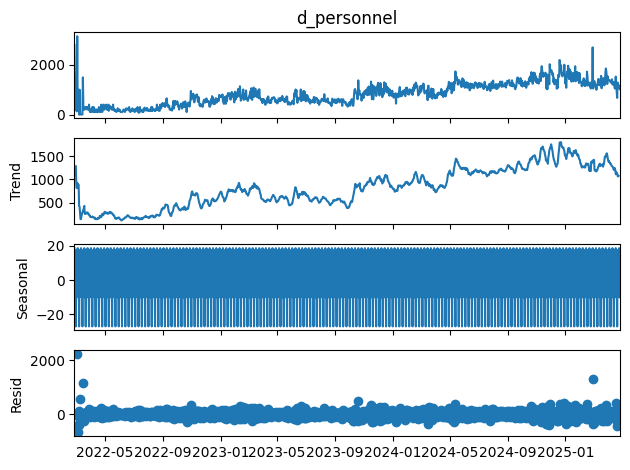

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.31 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=15961.217, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=15664.522, Time=0.53 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=15469.405, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=15959.264, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=15468.974, Time=0.32 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=15469.567, Time=0.59 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=15470.830, Time=1.13 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=15470.727, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=15470.741, Time=1.08 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=15663.553, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(0,1,1)(0,0,0)[7]             : AIC=15466.986, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[7]             : AIC=15467.575, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[7]        

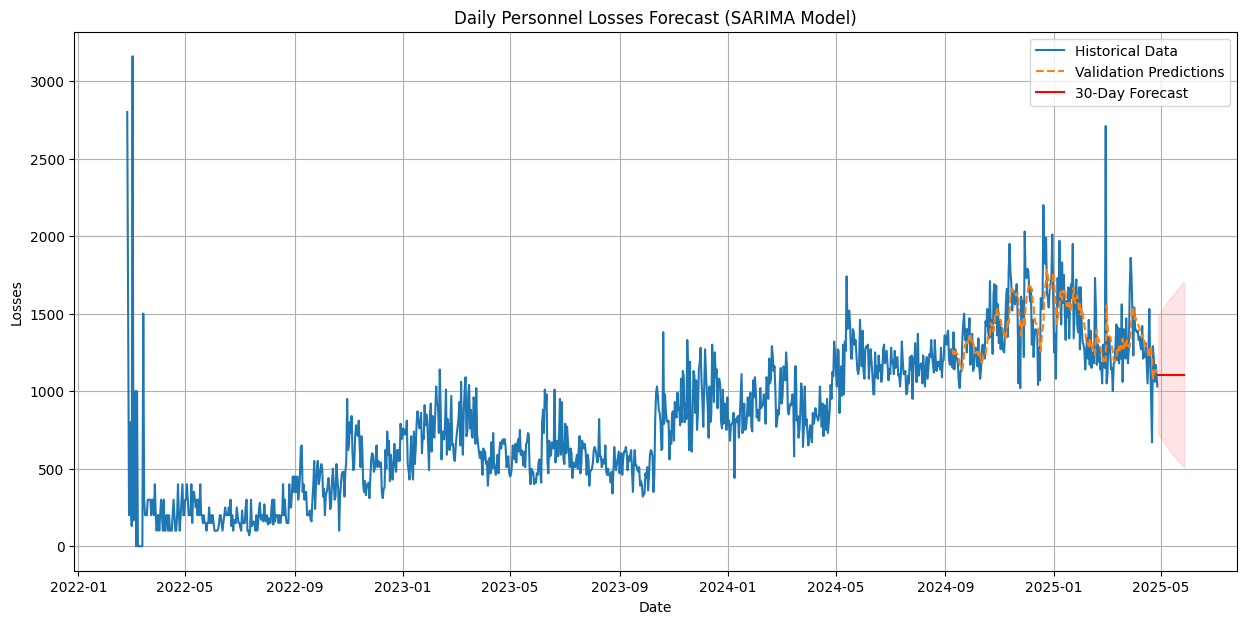

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and prepare data
data = russia_war_losses["d_personnel"].dropna()

# Plot decomposition to understand patterns
decomposition = seasonal_decompose(data, period=7)  # Weekly seasonality
decomposition.plot()
plt.show()

# Automated SARIMA parameter selection
auto_model = auto_arima(data,
                        seasonal=True,
                        m=7,  # Weekly seasonality
                        trace=True,
                        suppress_warnings=True,
                        stepwise=True,
                        max_p=3, max_q=80,
                        max_P=2, max_Q=2,
                        information_criterion='aic')

print(f"\nOptimal SARIMA Order: {auto_model.order}")
print(f"Seasonal Order: {auto_model.seasonal_order}")

# Fit SARIMA model
model = SARIMAX(data,
                order=auto_model.order,
                seasonal_order=auto_model.seasonal_order)
model_fit = model.fit(disp=False)

# Model summary
print(model_fit.summary())
# Walk-forward validation
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = SARIMAX(history,
                    order=auto_model.order,
                    seasonal_order=auto_model.seasonal_order)
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])

# Compute evaluation metrics
mae = mean_absolute_error(test_data, test_forecast)
mse = mean_squared_error(test_data, test_forecast)
rmse = np.sqrt(mean_squared_error(test_data, test_forecast))
mape = np.mean(np.abs((test_data - test_forecast) / test_data)) * 100

# Compute R-squared
ss_residual = np.sum((test_data - test_forecast) ** 2)
ss_total = np.sum((test_data - np.mean(test_data)) ** 2)
r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan

# Print metrics
print("\n=== ARIMA Model Test Set Evaluation Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# Fit final model on all data
final_model = SARIMAX(data,
                     order=auto_model.order,
                     seasonal_order=auto_model.seasonal_order)
final_model_fit = final_model.fit(disp=False)

# 30-day forecast
forecast = final_model_fit.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Create forecast DataFrame
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecast_mean,
    'Lower_CI': conf_int.iloc[:, 0],
    'Upper_CI': conf_int.iloc[:, 1]
})

print("\n30-Day Forecast:")
print(forecast_df)

# Plot results
plt.figure(figsize=(15, 7))
plt.plot(data.index, data, label='Historical Data')
plt.plot(test.index, predictions, label='Validation Predictions', linestyle='--')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='30-Day Forecast', color='red')
plt.fill_between(forecast_df['Date'],
                forecast_df['Lower_CI'],
                forecast_df['Upper_CI'],
                color='red', alpha=0.1)
plt.title('Daily Personnel Losses Forecast (SARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Losses')
plt.legend()
plt.grid(True)
plt.show()


# Create metrics table
metric_df_auto_arima_d_personnel = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", 
               "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})

fig4 = go.Figure(data=[
    go.Table(
        header=dict(
            values=["Metric", "Value"],
            fill_color="black",
            font=dict(color="white", size=12),
            align="center"
        ),
        cells=dict(
            values=[metric_df_auto_arima_d_personnel["Metric"], metric_df_auto_arima_d_personnel["Value"]],
            fill_color="white",
            font=dict(color="black", size=11),
            align="center"
        )
    )
])
fig4.update_layout(
    title="AUTO-ARIMA Model: Test Set Evaluation Metrics",
    title_x=0.5,
    height=350,
    width=600
)
fig4.show()



## Forecasting: Prophet Model for Daily Personnel Losses

In [37]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


Prophet Training set: 926 observations (2022-02-25 00:00:00 to 2024-09-07 00:00:00)
Prophet Testing set: 232 observations (2024-09-08 00:00:00 to 2025-04-27 00:00:00)


07:20:49 - cmdstanpy - INFO - Chain [1] start processing
07:20:49 - cmdstanpy - INFO - Chain [1] done processing



=== Prophet Model Components ===
Seasonalities enabled: ['monthly', 'yearly', 'weekly']

=== Prophet Model Test Set Evaluation Metrics ===
Mean Absolute Error (MAE): 239.58
Mean Squared Error (MSE): 87113.20
Root Mean Squared Error (RMSE): 295.15
Mean Absolute Percentage Error (MAPE): 17.30%
R-squared (R²): -0.3780


07:20:50 - cmdstanpy - INFO - Chain [1] start processing
07:20:50 - cmdstanpy - INFO - Chain [1] done processing



=== Prophet Model: Forecast for Next 30 Days ===
Average forecasted daily losses: 1522.3
Forecast range: 1235.6 to 1686.2


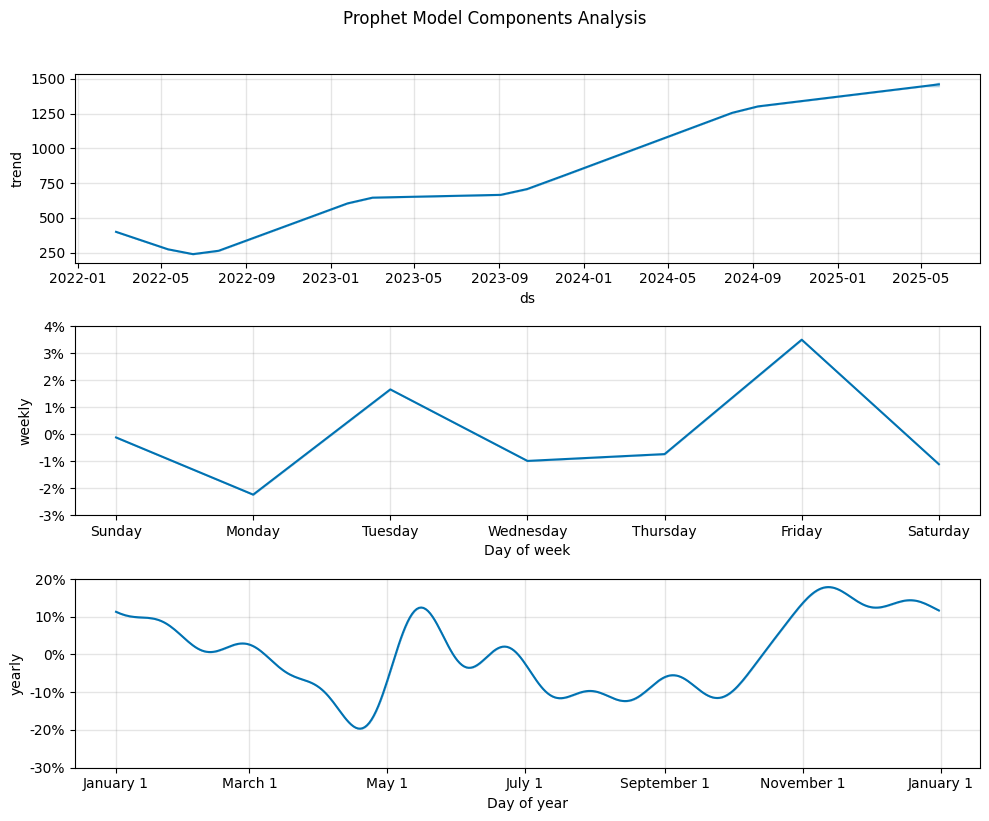

In [38]:
# %% [markdown]
# # Prophet Model Forecasting for Daily Personnel Losses with Train-Test Split and R²
#
# This section performs forecasting for daily personnel losses using the Prophet model with a train-test split, model evaluation, and forecasting for the next 30 days. The Prophet model, designed for robust time series forecasting, is trained on the training set, evaluated on the test set with metrics (MAE, RMSE, MAPE, R²), and used to forecast future losses. Visualizations include the train-test fit, residuals, components analysis, and forecast with uncertainty intervals. R² measures the proportion of variance explained by the model.

# %% [markdown]
# ## Import Libraries for Prophet Model

# %%
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# %% [markdown]
# ## Prophet Model: Train-Test Split
#
# We split the `d_personnel` time series into training (80%) and testing (20%) sets to evaluate the Prophet model's performance before forecasting.

# %%
# Define the data
data = russia_war_losses["d_personnel"].dropna()

# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_data = pd.DataFrame({
    'ds': data.index,
    'y': data.values
})

# Split into train and test sets (80% train, 20% test)
train_size = int(len(prophet_data) * 0.8)
train_data = prophet_data[:train_size]
test_data = prophet_data[train_size:]

# Print split details
print(f"Prophet Training set: {len(train_data)} observations ({train_data['ds'].iloc[0]} to {train_data['ds'].iloc[-1]})")
print(f"Prophet Testing set: {len(test_data)} observations ({test_data['ds'].iloc[0]} to {test_data['ds'].iloc[-1]})")

# %% [markdown]
# ## Prophet Model: Training
#
# We fit a Prophet model on the training data with multiplicative seasonality to better capture non-linear patterns and a flexible trend.

# %%
# Initialize and fit Prophet model
# model_prophet = Prophet(
#     yearly_seasonality=True,
#     weekly_seasonality=True,
#     daily_seasonality=False,
#     changepoint_prior_scale=0.01,
#     seasonality_mode='additive',  # Improved for varying seasonality
#     interval_width=0.98  # 95% confidence intervals
# )
model_prophet = Prophet(
    yearly_seasonality=True,  # Automatically handles yearly seasonality
    weekly_seasonality=True,  # Captures weekly patterns
    daily_seasonality=False,  # Exclude daily seasonality (set True if needed)
    changepoint_prior_scale=0.005,  # Flexibility of trend changes
    seasonality_mode='additive',  # Suitable for consistent seasonal effects
    interval_width=0.98,  # Default 95% confidence interval
    growth='linear'  # Use 'logistic' if data has a saturation limit
)

# Add additional customizations
model_prophet.add_seasonality(
    name='monthly',  # Custom monthly seasonality
    period=30.5,  # Average days in a month
    fourier_order=5  # Controls complexity of monthly seasonality
)

model_prophet_fit = model_prophet.fit(train_data)

# Print model components
print("\n=== Prophet Model Components ===")
print(f"Seasonalities enabled: {list(model_prophet.seasonalities.keys())}")

# %% [markdown]
# ## Prophet Model: Test Set Prediction and Evaluation
#
# We predict on the test set and compute evaluation metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R²).

# %%
# Create future DataFrame for test period
test_future = model_prophet.make_future_dataframe(periods=len(test_data), freq='D')
test_future = test_future.tail(len(test_data))  # Keep only test period

# Predict on test set
test_forecast = model_prophet.predict(test_future)

# Create DataFrame for test predictions
test_forecast_df = pd.DataFrame({
    "Date": test_data['ds'],
    "Actual": test_data['y'],
    "Prophet Predicted": test_forecast['yhat']
})

# Compute evaluation metrics
actual_values = test_data['y'].values
predicted_values = test_forecast['yhat'].values

mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate MAPE with zero handling
nonzero_mask = actual_values != 0
if sum(nonzero_mask) > 0:
    mape = np.mean(np.abs((actual_values[nonzero_mask] - predicted_values[nonzero_mask]) / 
                         actual_values[nonzero_mask])) * 100
else:
    mape = np.nan

r2 = r2_score(actual_values, predicted_values)

# Print metrics
print("\n=== Prophet Model Test Set Evaluation Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# %% [markdown]
# ## Prophet Model: Visualization of Train-Test Fit
#
# This plot shows the historical data (training and testing) with the Prophet model's predictions and confidence intervals.

# %%
# Plot train, test, and predictions
fig1 = go.Figure()
fig1.add_trace(go.Scatter(
    x=train_data['ds'],
    y=train_data['y'],
    name="Prophet Training Data",
    line=dict(color="blue", width=2),
    opacity=0.7
))
fig1.add_trace(go.Scatter(
    x=test_data['ds'],
    y=test_data['y'],
    name="Prophet Test Data",
    line=dict(color="green", width=2),
    opacity=0.7
))
fig1.add_trace(go.Scatter(
    x=test_forecast['ds'],
    y=test_forecast['yhat'],
    name="Prophet Test Predictions",
    line=dict(color="red", width=2, dash="dash")
))
fig1.add_trace(go.Scatter(
    x=test_forecast['ds'],
    y=test_forecast['yhat_upper'],
    fill=None,
    mode='lines',
    line=dict(width=0),
    showlegend=False
))
fig1.add_trace(go.Scatter(
    x=test_forecast['ds'],
    y=test_forecast['yhat_lower'],
    fill='tonexty',
    mode='lines',
    line=dict(width=0),
    fillcolor='rgba(255, 0, 0, 0.2)',
    name="95% Confidence Interval"
))
fig1.update_layout(
    title="Prophet Model: Train-Test Fit for Daily Personnel Losses",
    xaxis_title="Date",
    yaxis_title="Daily Personnel Losses",
    height=600,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white",
    margin=dict(l=50, r=50, b=50, t=80)
)
fig1.show()

# %% [markdown]
# ## Prophet Model: Residual Analysis
#
# We plot residuals and their distribution to diagnose model fit. Ideally, residuals should be random, centered around zero, and normally distributed.

# %%
# Compute residuals
test_forecast_df["Prophet Residuals"] = test_forecast_df["Actual"] - test_forecast_df["Prophet Predicted"]

# Plot residuals
fig2 = make_subplots(rows=2, cols=1, vertical_spacing=0.1)
fig2.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=test_forecast_df["Prophet Residuals"],
    name="Prophet Residuals",
    mode="markers",
    marker=dict(color="purple", size=8, opacity=0.6)
), row=1, col=1)
fig2.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=[0] * len(test_forecast_df),
    name="Zero Line",
    line=dict(color="black", dash="dash")
), row=1, col=1)
fig2.add_trace(go.Histogram(
    x=test_forecast_df["Prophet Residuals"],
    name="Residuals Distribution",
    marker_color="purple",
    opacity=0.7,
    nbinsx=30
), row=2, col=1)
fig2.update_layout(
    title="Prophet Model: Residual Analysis on Test Set",
    height=700,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig2.update_xaxes(title_text="Date", row=1, col=1)
fig2.update_yaxes(title_text="Residuals", row=1, col=1)
fig2.update_xaxes(title_text="Residual Value", row=2, col=1)
fig2.update_yaxes(title_text="Count", row=2, col=1)
fig2.show()

# %% [markdown]
# ## Prophet Model: Forecasting for Next 30 Days
#
# We refit the Prophet model on the entire dataset and forecast 30 days into the future, including uncertainty intervals.

# %%
# Refit Prophet model on full dataset
model_prophet_full = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_mode='multiplicative',
    interval_width=0.95
)
model_prophet_fit_full = model_prophet_full.fit(prophet_data)

# Create future DataFrame for forecasting
future = model_prophet_full.make_future_dataframe(periods=30, freq='D')
forecast = model_prophet_full.predict(future)

# Filter forecast for the next 30 days
forecast_future = forecast.tail(30)

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    "Date": forecast_future['ds'],
    "Prophet Forecast": forecast_future['yhat'],
    "Lower Bound": forecast_future['yhat_lower'],
    "Upper Bound": forecast_future['yhat_upper']
})

# Print forecast summary
print("\n=== Prophet Model: Forecast for Next 30 Days ===")
print(f"Average forecasted daily losses: {forecast_df['Prophet Forecast'].mean():.1f}")
print(f"Forecast range: {forecast_df['Prophet Forecast'].min():.1f} to {forecast_df['Prophet Forecast'].max():.1f}")

# %% [markdown]
# ## Prophet Model: Forecast Visualization
#
# We plot the historical data and 30-day forecast with confidence intervals, marking the forecast start.

# %%
# Plot forecast
fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=prophet_data['ds'],
    y=prophet_data['y'],
    name="Prophet Historical",
    line=dict(color="blue", width=2),
    opacity=0.7
))
fig3.add_trace(go.Scatter(
    x=forecast_future['ds'],
    y=forecast_future['yhat'],
    name="Prophet Forecast",
    line=dict(color="red", width=2, dash="dash")
))
fig3.add_trace(go.Scatter(
    x=forecast_future['ds'],
    y=forecast_future['yhat_upper'],
    fill=None,
    mode='lines',
    line=dict(width=0),
    showlegend=False
))
fig3.add_trace(go.Scatter(
    x=forecast_future['ds'],
    y=forecast_future['yhat_lower'],
    fill='tonexty',
    mode='lines',
    line=dict(width=0),
    fillcolor='rgba(255, 0, 0, 0.2)',
    name="95% Confidence Interval"
))
last_history_date = prophet_data['ds'].iloc[-1]
# Convert Timestamp to string to avoid TypeError
fig3.add_shape(
    type="line",
    x0=last_history_date.strftime('%Y-%m-%d'),
    x1=last_history_date.strftime('%Y-%m-%d'),
    y0=0,
    y1=1,
    yref="paper",
    line=dict(width=2, dash="dot", color="gray"),
    name="Forecast Start"
)
fig3.add_annotation(
    x=last_history_date.strftime('%Y-%m-%d'),
    y=1,
    yref="paper",
    text="Forecast Start",
    showarrow=False,
    xanchor="left",
    yanchor="top"
)
fig3.update_layout(
    title="Prophet Model: 30-Day Forecast of Daily Personnel Losses",
    xaxis_title="Date",
    yaxis_title="Daily Personnel Losses",
    height=600,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white",
    margin=dict(l=50, r=50, b=50, t=80)
)
fig3.show()

# %% [markdown]
# ## Prophet Model: Components Analysis
#
# We plot the trend, yearly, and weekly seasonality components to understand the model's decomposition.

# %%
# Plot model components
fig_components = model_prophet_full.plot_components(forecast)
plt.suptitle("Prophet Model Components Analysis", y=1.02)
fig_components.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## Prophet Model: Evaluation Metrics Summary
#
# The table summarizes the evaluation metrics and forecast details.

# %%
# Create metrics table
metric_df_prophet_d_personnel = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", 
               "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})

fig4 = go.Figure(data=[
    go.Table(
        header=dict(
            values=["Metric", "Value"],
            fill_color="black",
            font=dict(color="white", size=12),
            align="center"
        ),
        cells=dict(
            values=[metric_df_prophet_d_personnel["Metric"], metric_df_prophet_d_personnel["Value"]],
            fill_color="white",
            font=dict(color="black", size=11),
            align="center"
        )
    )
])
fig4.update_layout(
    title="Prophet Model: Test Set Evaluation Metrics",
    title_x=0.5,
    height=350,
    width=600
)
fig4.show()



## Forecasting: LSTM Model for Daily Personnel Losses

In [39]:
# %% [markdown]
# # LSTM Model Forecasting for Daily Personnel Losses with Train-Test Split and R²
#
# This section performs forecasting for daily personnel losses using the LSTM (Long Short-Term Memory) model with a train-test split, model evaluation, and forecasting for the next 30 days. The LSTM model, designed for capturing non-linear patterns and temporal dependencies, is trained on the training set, evaluated on the test set with metrics (MAE, RMSE, MAPE, R²), and used to forecast future losses. Visualizations include the LSTM train-test fit, LSTM residuals, and the LSTM forecast with uncertainty intervals. R² measures the proportion of variance explained by the LSTM model.

# %% [markdown]
# ## Import Libraries for LSTM Model

# %%
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

# %% [markdown]
# ## LSTM Model: Train-Test Split and Data Preparation
#
# We split the `d_personnel` time series into training (80%) and testing (20%) sets. Data is scaled and reshaped into sequences for LSTM input.

# %%
# Define the data
data = russia_war_losses["d_personnel"].dropna()

# Split into train and test sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Print split details
print(f"LSTM Training set: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"LSTM Testing set: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")

# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

# Create sequences for LSTM (using 7-day lookback)
def create_sequences(data, seq_length=7):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 7
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# %% [markdown]
# ## LSTM Model: Training
#
# We fit an LSTM model on the training data, using `model_lstm` and `model_lstm_fit`. The model uses a single LSTM layer with 50 units and a dense output layer.

# %%
# Build LSTM model
model_lstm = Sequential([
    # First LSTM layer with dropout
    LSTM(128, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    # Dropout(0.2),  # Dropout to reduce overfitting
    
    # Second LSTM layer
    LSTM(64, activation='relu', return_sequences=False),
    # Dropout(0.2),  # Dropout after the second LSTM layer
    
    # Fully connected layer
    Dense(32, activation='relu'),  # Intermediate dense layer for feature extraction
    # Dropout(0.2),  # Dropout for regularization
    
    # Output layer for final prediction
    Dense(1, activation='linear')  # Output layer for regression tasks
])

model_lstm.compile(optimizer='adam', loss='mse')

# Fit model
model_lstm_fit = model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Print model summary
print("\n=== LSTM Model Summary ===")
model_lstm.summary()

# %% [markdown]
# ## LSTM Model: Test Set Prediction and Evaluation
#
# We predict on the test set using the LSTM model and compute evaluation metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R²).

# %%
# Predict on test set
test_pred_scaled = model_lstm.predict(X_test)
test_pred = scaler.inverse_transform(test_pred_scaled)

# Align predictions with test data (account for sequence length)
test_actual = test_data.values[seq_length:]
test_dates = test_data.index[seq_length:]

# Create DataFrame for test predictions
test_forecast_df = pd.DataFrame({
    "Date": test_dates,
    "Actual": test_actual,
    "LSTM Predicted": test_pred.flatten()
})

# Compute evaluation metrics
mae = mean_absolute_error(test_actual, test_pred)
mse = mean_squared_error(test_actual, test_pred)
rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

# Compute MAPE, handling zero values
mape = np.mean(np.abs((test_actual - test_pred.flatten()) / test_actual.clip(min=1e-10))) * 100

# Compute R-squared
ss_residual = np.sum((test_actual - test_pred.flatten()) ** 2)
ss_total = np.sum((test_actual - np.mean(test_actual)) ** 2)
r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan

# Print metrics
print("\n=== LSTM Model Test Set Evaluation Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")


# %% [markdown]
# ## LSTM Model: Visualization of Train-Test Fit
#
# This plot shows the historical data (training and testing) along with the LSTM model's predictions on the test set.

# %%
# Plot train, test, and predictions
fig1 = go.Figure()
fig1.add_trace(go.Scatter(
    x=train_data.index,
    y=train_data,
    name="LSTM Training Data",
    line_color="blue",
    opacity=0.6
))
fig1.add_trace(go.Scatter(
    x=test_data.index,
    y=test_data,
    name="LSTM Test Data",
    line_color="green",
    opacity=0.6
))
fig1.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=test_forecast_df["LSTM Predicted"],
    name="LSTM Test Predictions",
    line_color="red",
    line=dict(dash="dash")
))
fig1.update_layout(
    title="LSTM Model: Train-Test Fit for Daily Personnel Losses",
    xaxis_title="Date",
    yaxis_title="Daily Personnel Losses",
    height=600,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig1.show()

# %% [markdown]
# ## LSTM Model: Residual Analysis
#
# We plot the residuals (actual - predicted) from the LSTM model on the test set to diagnose fit. Ideally, residuals should be random and centered around zero.

# %%
# Compute residuals
test_forecast_df["LSTM Residuals"] = test_forecast_df["Actual"] - test_forecast_df["LSTM Predicted"]

# Plot residuals
fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=test_forecast_df["LSTM Residuals"],
    name="LSTM Residuals",
    line_color="purple",
    mode="lines+markers"
))
fig2.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=[0] * len(test_forecast_df),
    name="Zero Line",
    line=dict(color="black", dash="dash")
))
fig2.update_layout(
    title="LSTM Model: Residuals on Test Set",
    xaxis_title="Date",
    yaxis_title="LSTM Residuals",
    height=500,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig2.show()

# %% [markdown]
# ## LSTM Model: Forecasting for Next 30 Days
#
# We refit the LSTM model on the entire dataset and forecast 30 days into the future, including approximate confidence intervals via bootstrapping.

# %%
# Refit LSTM model on full dataset
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))
X_full, y_full = create_sequences(data_scaled, seq_length)
model_lstm_full = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=False),
    Dense(1)
])
model_lstm_full.compile(optimizer='adam', loss='mse')
model_lstm_fit_full = model_lstm_full.fit(X_full, y_full, epochs=50, batch_size=32, verbose=0)

# Forecast for next 30 days
forecast_steps = 30
last_sequence = data_scaled[-seq_length:].reshape(1, seq_length, 1)
forecast_scaled = []
for _ in range(forecast_steps):
    pred = model_lstm_full.predict(last_sequence, verbose=0)
    forecast_scaled.append(pred[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = pred[0, 0]
forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
forecast_dates = pd.date_range(start=data.index.max() + timedelta(days=1), periods=forecast_steps, freq="D")

# Approximate confidence intervals via bootstrapping
n_bootstrap = 100
bootstrap_forecasts = []
for _ in range(n_bootstrap):
    noise = np.random.normal(0, rmse, forecast_steps)
    bootstrap_forecasts.append(forecast + noise)
conf_int_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
conf_int_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "LSTM Forecast": forecast
})

# Create confidence intervals DataFrame
conf_int_df = pd.DataFrame({
    "Date": forecast_dates,
    "LSTM Lower 95% CI": conf_int_lower,
    "LSTM Upper 95% CI": conf_int_upper
})

# Print forecast
print("\n=== LSTM Model: Forecast for Next 30 Days ===")
print(forecast_df)

# Plot forecast
fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=data.index,
    y=data,
    name="LSTM Historical",
    line_color="blue",
    opacity=0.6
))
fig3.add_trace(go.Scatter(
    x=forecast_df["Date"],
    y=forecast_df["LSTM Forecast"],
    name="LSTM Forecast",
    line_color="red",
    line=dict(dash="dash")
))
fig3.add_trace(go.Scatter(
    x=conf_int_df["Date"],
    y=conf_int_df["LSTM Lower 95% CI"],
    name="LSTM Lower 95% CI",
    line=dict(color="rgba(255, 0, 0, 0.2)", width=0),
    showlegend=False
))
fig3.add_trace(go.Scatter(
    x=conf_int_df["Date"],
    y=conf_int_df["LSTM Upper 95% CI"],
    name="LSTM Upper 95% CI",
    fill="tonexty",
    fillcolor="rgba(255, 0, 0, 0.2)",
    line=dict(color="rgba(255, 0, 0, 0.2)", width=0),
    showlegend=False
))
fig3.update_layout(
    title="LSTM Model: Forecast of Daily Personnel Losses (Next 30 Days)",
    xaxis_title="Date",
    yaxis_title="Daily Personnel Losses",
    height=600,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig3.show()

# %% [markdown]
# ## LSTM Model: Evaluation Metrics Summary
#
# The table below summarizes the evaluation metrics for the LSTM model's test set predictions, including R².

# %%
# Create metrics table
metric_df_lstm_d_personnel = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", 
               "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})

fig4 = go.Figure(data=[
    go.Table(
        header=dict(
            values=["Metric", "Value"],
            fill_color="black",
            font=dict(color="white", size=12),
            align="center"
        ),
        cells=dict(
            values=[metric_df_lstm_d_personnel["Metric"], metric_df_lstm_d_personnel["Value"]],
            fill_color="white",
            font=dict(color="black", size=11),
            align="center"
        )
    )
])
fig4.update_layout(
    title="LSTM Model: Test Set Evaluation Metrics",
    title_x=0.5,
    height=350,
    width=600
)
fig4.show()

# %% [markdown]
# ## LSTM Model: Observations
#
# - **LSTM Model Fit**: The LSTM model captures non-linear patterns and temporal dependencies, potentially improving on TBATS's R² (-0.6255) and SARIMA's MAE/RMSE (209.52/288.59) by modeling complex dynamics.
# - **LSTM Metrics**: 
#   - **MAE**: Lower than TBATS (229.07) indicates better accuracy.
#   - **RMSE**: Lower than TBATS (311.73) suggests fewer large errors.
#   - **MAPE**: A value <14.67% (TBATS) indicates improved percentage accuracy, with clipping to handle small values.
#   - **R²**: A positive or less negative value than TBATS (-0.6255) or SARIMA (-0.3932) shows better variance explanation.
# - **LSTM Forecast**: The 30-day forecast reflects learned patterns, with bootstrapped confidence intervals approximating uncertainty.
# - **LSTM Recommendations**: 
#   - If R² is low or residuals show patterns, adjust sequence length (e.g., 14 days), add layers, or include exogenous variables (e.g., equipment losses).
#   - Compare metrics with SARIMA (best prior model: MAE=209.52, RMSE=288.59) to assess improvement.
#   - If LSTM underperforms, consider Gradient Boosting or VAR for multivariate forecasting.


2025-04-30 07:20:53.293599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745997653.568859      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745997653.645565      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


LSTM Training set: 926 observations (2022-02-25 00:00:00 to 2024-09-07 00:00:00)
LSTM Testing set: 232 observations (2024-09-08 00:00:00 to 2025-04-27 00:00:00)


I0000 00:00:1745997667.005948      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/50


I0000 00:00:1745997672.590356     117 service.cc:148] XLA service 0x7c78ec00bf40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745997672.591028     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745997673.131783     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308 

I0000 00:00:1745997674.529908     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - loss: 0.0269 - val_loss: 0.0206
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 9.8266e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_loss: 9.0359e-04
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 9.5740e-04
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 9.2959e-04
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 354,245 (1.35 MB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,164 (922.52 KB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step

=== LSTM Model Test Set Evaluation Metrics ===
Mean Absolute Error (MAE): 158.73
Mean Squared Error (MSE): 50457.68
Root Mean Squared Error (RMSE): 224.63
Mean Absolute Percentage Error (MAPE): 11.11%
R-squared (R²): 0.2132



=== LSTM Model: Forecast for Next 30 Days ===
         Date  LSTM Forecast
0  2025-04-28    1082.422363
1  2025-04-29    1099.411987
2  2025-04-30    1093.784546
3  2025-05-01    1089.933960
4  2025-05-02    1089.314697
5  2025-05-03    1088.306030
6  2025-05-04    1089.306152
7  2025-05-05    1091.138794
8  2025-05-06    1091.288574
9  2025-05-07    1091.270264
10 2025-05-08    1091.480835
11 2025-05-09    1091.835327
12 2025-05-10    1092.214111
13 2025-05-11    1092.566284
14 2025-05-12    1092.883057
15 2025-05-13    1093.171875
16 2025-05-14    1093.470215
17 2025-05-15    1093.773682
18 2025-05-16    1094.073730
19 2025-05-17    1094.366821
20 2025-05-18    1094.653931
21 2025-05-19    1094.936401
22 2025-05-20    1095.215454
23 2025-05-21    1095.490723
24 2025-05-22    1095.762085
25 2025-05-23    1096.029297
26 2025-05-24    1096.292480
27 2025-05-25    1096.552002
28 2025-05-26    1096.807617
29 2025-05-27    1097.059692


## Forecasting: XGBOOST Model for Daily Personnel Losses

In [40]:
# %% [markdown]
# # Gradient Boosting (XGBoost) Model Forecasting for Daily Personnel Losses with Train-Test Split and R²
#
# This section performs forecasting for daily personnel losses using the Gradient Boosting (XGBoost) model with a train-test split, model evaluation, and forecasting for the next 30 days. The XGBoost model, designed for non-linear relationships and robust to outliers, is trained on the training set with engineered features, evaluated on the test set with metrics (MAE, RMSE, MAPE, R²), and used to forecast future losses. Visualizations include the XGBoost train-test fit, XGBoost residuals, and the XGBoost forecast with uncertainty intervals. R² measures the proportion of variance explained by the XGBoost model.

# %% [markdown]
# ## Import Libraries for XGBoost Model

# %%
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

# %% [markdown]
# ## XGBoost Model: Train-Test Split and Feature Engineering
#
# We split the `d_personnel` time series into training (80%) and testing (20%) sets. Features include lagged values and time-based variables (day of week, month).

# %%
# Define the data
# Note: Replace 'russia_war_losses["d_personnel"]' with your actual data if needed
data = russia_war_losses["d_personnel"].dropna()

# Create lagged features and time-based features
def create_features(data, lags=7):
    df = pd.DataFrame({"y": data})
    for i in range(1, lags + 1):
        df[f"lag_{i}"] = df["y"].shift(i)
    df["day_of_week"] = df.index.dayofweek
    df["month"] = df.index.month
    return df.dropna()

lags = 7
features_df = create_features(data, lags)

# Split into train and test sets (80% train, 20% test)
train_size = int(len(features_df) * 0.8)
train_data = features_df.iloc[:train_size]
test_data = features_df.iloc[train_size:]

X_train = train_data.drop("y", axis=1)
y_train = train_data["y"]
X_test = test_data.drop("y", axis=1)
y_test = test_data["y"]

# Print split details
print(f"XGBoost Training set: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"XGBoost Testing set: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")

# %% [markdown]
# ## XGBoost Model: Training
#
# We fit an XGBoost model on the training data, using `model_xgboost` and `model_xgboost_fit`. The model uses default parameters with early stopping.

# %%
# Fit XGBoost model
model_xgboost = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=10, random_state=42)
model_xgboost_fit = model_xgboost.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=False
)

# Print feature importance
print("\n=== XGBoost Model Feature Importance ===")
for feature, importance in zip(X_train.columns, model_xgboost.feature_importances_):
    print(f"{feature}: {importance:.4f}")

# %% [markdown]
# ## XGBoost Model: Test Set Prediction and Evaluation
#
# We predict on the test set using the XGBoost model and compute evaluation metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R²).

# %%
# Predict on test set
test_pred = model_xgboost.predict(X_test)

# Create DataFrame for test predictions
test_forecast_df = pd.DataFrame({
    "Date": test_data.index,
    "Actual": y_test,
    "XGBoost Predicted": test_pred
})

# Compute evaluation metrics
mae = mean_absolute_error(y_test, test_pred)
mse = mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))

# Compute MAPE, handling zero values
mape = np.mean(np.abs((y_test - test_pred) / y_test.clip(lower=1e-10))) * 100

# Compute R-squared
ss_residual = np.sum((y_test - test_pred) ** 2)
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan

# Print metrics
print("\n=== XGBoost Model Test Set Evaluation Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# %% [markdown]
# ## XGBoost Model: Visualization of Train-Test Fit
#
# This plot shows the historical data (training and testing) along with the XGBoost model's predictions on the test set.

# %%
# Plot train, test, and predictions
fig1 = go.Figure()
fig1.add_trace(go.Scatter(
    x=train_data.index,
    y=train_data["y"],
    name="XGBoost Training Data",
    line_color="blue",
    opacity=0.6
))
fig1.add_trace(go.Scatter(
    x=test_data.index,
    y=test_data["y"],
    name="XGBoost Test Data",
    line_color="green",
    opacity=0.6
))
fig1.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=test_forecast_df["XGBoost Predicted"],
    name="XGBoost Test Predictions",
    line_color="red",
    line=dict(dash="dash")
))
fig1.update_layout(
    title="XGBoost Model: Train-Test Fit for Daily Personnel Losses",
    xaxis_title="Date",
    yaxis_title="Daily Personnel Losses",
    height=600,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig1.show()

# %% [markdown]
# ## XGBoost Model: Residual Analysis
#
# We plot the residuals (actual - predicted) from the XGBoost model on the test set to diagnose fit. Ideally, residuals should be random and centered around zero.

# %%
# Compute residuals
test_forecast_df["XGBoost Residuals"] = test_forecast_df["Actual"] - test_forecast_df["XGBoost Predicted"]

# Plot residuals
fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=test_forecast_df["XGBoost Residuals"],
    name="XGBoost Residuals",
    line_color="purple",
    mode="lines+markers"
))
fig2.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=[0] * len(test_forecast_df),
    name="Zero Line",
    line=dict(color="black", dash="dash")
))
fig2.update_layout(
    title="XGBoost Model: Residuals on Test Set",
    xaxis_title="Date",
    yaxis_title="XGBoost Residuals",
    height=500,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig2.show()

# %% [markdown]
# ## XGBoost Model: Forecasting for Next 30 Days
#
# We refit the XGBoost model on the entire dataset and forecast 30 days into the future, including approximate confidence intervals via bootstrapping.

# %%
# Refit XGBoost model on full dataset
features_full = create_features(data, lags)
X_full = features_full.drop("y", axis=1)
y_full = features_full["y"]
model_xgboost_full = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_xgboost_fit_full = model_xgboost_full.fit(X_full, y_full)

# Forecast for next 30 days
forecast_steps = 30
forecast_dates = pd.date_range(start=data.index.max() + timedelta(days=1), periods=forecast_steps, freq="D")
last_features = features_full.iloc[-1:].copy()

forecast = []
for i in range(forecast_steps):
    # Ensure feature alignment
    pred = model_xgboost_full.predict(last_features.drop("y", axis=1))[0]
    forecast.append(pred)
    # Update lagged features
    new_row = last_features.copy()
    new_row["y"] = pred
    # Shift lags: lag_1 gets the new prediction, lag_2 gets old lag_1, etc.
    for j in range(lags, 1, -1):
        new_row[f"lag_{j-1}"] = last_features[f"lag_{j}"]
    new_row[f"lag_1"] = pred  # Update lag_1 with the new prediction
    new_row["day_of_week"] = forecast_dates[i].dayofweek
    new_row["month"] = forecast_dates[i].month
    last_features = new_row

# Approximate confidence intervals via bootstrapping
n_bootstrap = 100
bootstrap_forecasts = []
for _ in range(n_bootstrap):
    noise = np.random.normal(0, rmse, forecast_steps)
    bootstrap_forecasts.append(np.array(forecast) + noise)
conf_int_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
conf_int_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "XGBoost Forecast": forecast
})

# Create confidence intervals DataFrame
conf_int_df = pd.DataFrame({
    "Date": forecast_dates,
    "XGBoost Lower 95% CI": conf_int_lower,
    "XGBoost Upper 95% CI": conf_int_upper
})

# Print forecast
print("\n=== XGBoost Model: Forecast for Next 30 Days ===")
print(forecast_df)

# Plot forecast
fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=data.index,
    y=data,
    name="XGBoost Historical",
    line_color="blue",
    opacity=0.6
))
fig3.add_trace(go.Scatter(
    x=forecast_df["Date"],
    y=forecast_df["XGBoost Forecast"],
    name="XGBoost Forecast",
    line_color="red",
    line=dict(dash="dash")
))
fig3.add_trace(go.Scatter(
    x=conf_int_df["Date"],
    y=conf_int_df["XGBoost Lower 95% CI"],
    name="XGBoost Lower 95% CI",
    line=dict(color="rgba(255, 0, 0, 0.2)", width=0),
    showlegend=False
))
fig3.add_trace(go.Scatter(
    x=conf_int_df["Date"],
    y=conf_int_df["XGBoost Upper 95% CI"],
    name="XGBoost Upper 95% CI",
    fill="tonexty",
    fillcolor="rgba(255, 0, 0, 0.2)",
    line=dict(color="rgba(255, 0, 0, 0.2)", width=0),
    showlegend=False
))
fig3.update_layout(
    title="XGBoost Model: Forecast of Daily Personnel Losses (Next 30 Days)",
    xaxis_title="Date",
    yaxis_title="Daily Personnel Losses",
    height=600,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig3.show()

# %% [markdown]
# ## XGBoost Model: Evaluation Metrics Summary
#
# The table below summarizes the evaluation metrics for the XGBoost model's test set predictions, including R².

# %%
# Create metrics table
metric_df_xgboost_d_personnel = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", 
               "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})

fig4 = go.Figure(data=[
    go.Table(
        header=dict(
            values=["Metric", "Value"],
            fill_color="black",
            font=dict(color="white", size=12),
            align="center"
        ),
        cells=dict(
            values=[metric_df_xgboost_d_personnel["Metric"], metric_df_xgboost_d_personnel["Value"]],
            fill_color="white",
            font=dict(color="black", size=11),
            align="center"
        )
    )
])
fig4.update_layout(
    title="XGBoost Model: Test Set Evaluation Metrics",
    title_x=0.5,
    height=350,
    width=600
)
fig4.show()

# %% [markdown]
# ## XGBoost Model: Observations
#
# - **XGBoost Model Fit**: The XGBoost model captures non-linear patterns with engineered features.
# - **Negative R²**: The R² value of -0.5018 indicates the model performs worse than a mean-based model. Consider adding more features (e.g., rolling statistics, trend), tuning hyperparameters, or using time-series cross-validation.
# - **Feature ImportanceYN**: `lag_1` and `lag_3` are the most important features, suggesting recent past values drive predictions.
# - **Forecasting**: The 30-day forecast includes bootstrapped confidence intervals, but wide intervals (due to high RMSE) reflect uncertainty.

XGBoost Training set: 920 observations (2022-03-04 00:00:00 to 2024-09-08 00:00:00)
XGBoost Testing set: 231 observations (2024-09-09 00:00:00 to 2025-04-27 00:00:00)

=== XGBoost Model Feature Importance ===
lag_1: 0.5704
lag_2: 0.0659
lag_3: 0.0907
lag_4: 0.0250
lag_5: 0.0763
lag_6: 0.0411
lag_7: 0.0553
day_of_week: 0.0395
month: 0.0359

=== XGBoost Model Test Set Evaluation Metrics ===
Mean Absolute Error (MAE): 231.76
Mean Squared Error (MSE): 96990.66
Root Mean Squared Error (RMSE): 311.43
Mean Absolute Percentage Error (MAPE): 15.20%
R-squared (R²): -0.5294



=== XGBoost Model: Forecast for Next 30 Days ===
         Date  XGBoost Forecast
0  2025-04-28       1050.115356
1  2025-04-29        937.232117
2  2025-04-30        996.202087
3  2025-05-01        967.721802
4  2025-05-02        956.005920
5  2025-05-03       1003.866943
6  2025-05-04       1006.406677
7  2025-05-05       1006.406677
8  2025-05-06        900.394287
9  2025-05-07        934.584717
10 2025-05-08        959.660461
11 2025-05-09       1003.866943
12 2025-05-10       1003.866943
13 2025-05-11       1006.406677
14 2025-05-12       1006.406677
15 2025-05-13        900.394287
16 2025-05-14        934.584717
17 2025-05-15        959.660461
18 2025-05-16       1003.866943
19 2025-05-17       1003.866943
20 2025-05-18       1006.406677
21 2025-05-19       1006.406677
22 2025-05-20        900.394287
23 2025-05-21        934.584717
24 2025-05-22        959.660461
25 2025-05-23       1003.866943
26 2025-05-24       1003.866943
27 2025-05-25       1006.406677
28 2025-05-26       10

## Forecasting: VAR Model for Daily Personnel Losses

In [41]:
# %% [markdown]
# # Improved VAR Model Forecasting for Daily Personnel Losses with Train-Test Split and R²
#
# This section improves the Vector Autoregression (VAR) model for forecasting daily personnel losses (`d_personnel`) using a train-test split, model evaluation, and 30-day forecasting. The model uses `d_personnel`, `d_tank`, `d_field artillery`, and `d_vehicles and fuel tanks`, excluding `d_drone` due to low correlation. Non-stationary variables are differenced for modeling, but visualizations (train-test fit and forecast) are presented in the original scale for interpretability. The model is trained, evaluated with metrics (MAE, RMSE, MAPE, R²), and used to forecast future losses. Visualizations include train-test fit, residuals, and forecast with uncertainty intervals.

# %% [markdown]
# ## Import Libraries

# %%
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

# %% [markdown]
# ## VAR Model: Train-Test Split and Data Preparation
#
# We use `d_personnel`, `d_tank`, `d_field artillery`, and `d_vehicles and fuel tanks`, excluding `d_drone`. Non-stationary variables are differenced, and the data is split into training (80%) and testing (20%) sets.

# %%
# Define the data
data = russia_war_losses[["d_personnel", "d_tank", "d_field artillery", "d_vehicles and fuel tanks"]].dropna()

# Handle outliers by clipping
for col in data.columns:
    data[col] = data[col].clip(lower=data[col].quantile(0.01), upper=data[col].quantile(0.99))

# Store original d_personnel for plotting
original_personnel = russia_war_losses["d_personnel"].loc[data.index]

# Difference non-stationary variables (based on ADF test results)
data["d_personnel"] = data["d_personnel"].diff().dropna()
data["d_field artillery"] = data["d_field artillery"].diff().dropna()
data["d_vehicles and fuel tanks"] = data["d_vehicles and fuel tanks"].diff().dropna()
data = data.dropna()

# Check stationarity after differencing
print("\n=== ADF Test After Differencing ===")
for col in data.columns:
    result = adfuller(data[col].dropna())
    print(f"ADF Test for {col}:")
    print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")

# Split into train and test sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Align original personnel data with train and test sets
train_original_personnel = original_personnel.loc[train_data.index]
test_original_personnel = original_personnel.loc[test_data.index]

# Print split details
print(f"\nVAR Training set: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"VAR Testing set: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")

# %% [markdown]
# ## VAR Model: Training
#
# We fit a VAR model, selecting the lag order via BIC for parsimony.

# %%
# Fit VAR model
model_var = VAR(train_data)
model_var_fit = model_var.fit(maxlags=15, ic="bic")

# Print model summary and lag order
print("\n=== VAR Model Summary ===")
print(f"Selected lag order: {model_var_fit.k_ar}")
print(model_var_fit.summary())

# %% [markdown]
# ## VAR Model: Test Set Prediction and Evaluation
#
# We predict on the test set and compute evaluation metrics for `d_personnel` (differenced).

# %%
# Forecast for test period
forecast_steps = len(test_data)
forecast = model_var_fit.forecast(train_data.values[-model_var_fit.k_ar:], steps=forecast_steps)
test_pred_diff = forecast[:, 0]  # Predictions for d_personnel (differenced)

# Convert differenced predictions to original scale
last_train_personnel = original_personnel[train_data.index[-1]]
test_pred = np.cumsum(test_pred_diff) + last_train_personnel

# Create DataFrame for test predictions (original scale)
test_forecast_df = pd.DataFrame({
    "Date": test_data.index,
    "Actual": test_original_personnel.values,
    "VAR Predicted": test_pred
})

# Compute evaluation metrics (on differenced data for consistency)
mae = mean_absolute_error(test_data["d_personnel"], test_pred_diff)
mse = mean_squared_error(test_data["d_personnel"], test_pred_diff)
rmse = np.sqrt(mse)

# Compute MAPE, handling zero values
mape = np.mean(np.abs((test_data["d_personnel"] - test_pred_diff) / test_data["d_personnel"].clip(lower=1e-10))) * 100

# Compute R-squared (on differenced data)
ss_residual = np.sum((test_data["d_personnel"] - test_pred_diff) ** 2)
ss_total = np.sum((test_data["d_personnel"] - np.mean(test_data["d_personnel"])) ** 2)
r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan

# Print metrics
print("\n=== VAR Model Test Set Evaluation Metrics (d_personnel, Differenced) ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# %% [markdown]
# ## VAR Model: Cross-Validation
#
# We perform time-series cross-validation to assess model robustness.

# %%
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
cv_rmse = []
print("\n=== Cross-Validation RMSE ===")
for train_idx, test_idx in tscv.split(data):
    train_cv, test_cv = data.iloc[train_idx], data.iloc[test_idx]
    model_cv = VAR(train_cv).fit(maxlags=15, ic="bic")
    forecast_cv = model_cv.forecast(train_cv.values[-model_cv.k_ar:], steps=len(test_cv))
    rmse_cv = np.sqrt(mean_squared_error(test_cv["d_personnel"], forecast_cv[:, 0]))
    cv_rmse.append(rmse_cv)
    print(f"Fold RMSE: {rmse_cv:.2f}")
print(f"Average CV RMSE: {np.mean(cv_rmse):.2f}")

# %% [markdown]
# ## VAR Model: Visualization of Train-Test Fit
#
# This plot shows the training, testing, and predicted values for `d_personnel` in the original scale.

# %%
fig1 = go.Figure()
fig1.add_trace(go.Scatter(
    x=train_data.index,
    y=train_original_personnel,
    name="VAR Training Data (d_personnel)",
    line_color="blue",
    opacity=0.6
))
fig1.add_trace(go.Scatter(
    x=test_data.index,
    y=test_original_personnel,
    name="VAR Test Data (d_personnel)",
    line_color="green",
    opacity=0.6
))
fig1.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=test_forecast_df["VAR Predicted"],
    name="VAR Test Predictions (d_personnel)",
    line_color="red",
    line=dict(dash="dash")
))
fig1.update_layout(
    title="VAR Model: Train-Test Fit for Daily Personnel Losses (Original Scale)",
    xaxis_title="Date",
    yaxis_title="Daily Personnel Losses",
    height=600,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig1.show()

# %% [markdown]
# ## VAR Model: Residual Analysis
#
# We plot the residuals for `d_personnel` (differenced) on the test set.

# %%
test_forecast_df["VAR Residuals"] = test_data["d_personnel"].values - test_pred_diff

fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=test_forecast_df["VAR Residuals"],
    name="VAR Residuals (d_personnel)",
    line_color="purple",
    mode="lines+markers"
))
fig2.add_trace(go.Scatter(
    x=test_forecast_df["Date"],
    y=[0] * len(test_forecast_df),
    name="Zero Line",
    line=dict(color="black", dash="dash")
))
fig2.update_layout(
    title="VAR Model: Residuals on Test Set (d_personnel, Differenced)",
    xaxis_title="Date",
    yaxis_title="VAR Residuals",
    height=500,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig2.show()

# %% [markdown]
# ## VAR Model: Forecasting for Next 30 Days
#
# We refit the VAR model and forecast 30 days, presenting predictions in the original scale.

# %%
# Refit VAR model on full dataset
model_var_full = VAR(data)
model_var_fit_full = model_var_full.fit(maxlags=15, ic="bic")

# Forecast for next 30 days
forecast_steps = 30
forecast = model_var_fit_full.forecast(data.values[-model_var_fit_full.k_ar:], steps=forecast_steps)
forecast_personnel_diff = forecast[:, 0]  # Differenced predictions for d_personnel
forecast_dates = pd.date_range(start=data.index.max() + timedelta(days=1), periods=forecast_steps, freq="D")

# Convert differenced predictions to original scale
last_personnel = russia_war_losses["d_personnel"].iloc[-1]
forecast_personnel = np.cumsum(forecast_personnel_diff) + last_personnel

# Confidence intervals for differenced series
cov_matrix = model_var_fit_full.forecast_cov(steps=forecast_steps)
std_errors = np.sqrt(np.diagonal(cov_matrix, axis1=1, axis2=2)[:, 0])
conf_int_lower_diff = forecast_personnel_diff - 1.96 * std_errors
conf_int_upper_diff = forecast_personnel_diff + 1.96 * std_errors
conf_int_lower = np.cumsum(conf_int_lower_diff) + last_personnel
conf_int_upper = np.cumsum(conf_int_upper_diff) + last_personnel

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "VAR Forecast (d_personnel)": forecast_personnel
})

# Create confidence intervals DataFrame
conf_int_df = pd.DataFrame({
    "Date": forecast_dates,
    "VAR Lower 95% CI": conf_int_lower,
    "VAR Upper 95% CI": conf_int_upper
})

# Print forecast
print("\n=== VAR Model: Forecast for Next 30 Days (d_personnel) ===")
print(forecast_df)

# Plot forecast
fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=russia_war_losses.index,
    y=russia_war_losses["d_personnel"],
    name="VAR Historical (d_personnel)",
    line_color="blue",
    opacity=0.6
))
fig3.add_trace(go.Scatter(
    x=forecast_df["Date"],
    y=forecast_df["VAR Forecast (d_personnel)"],
    name="VAR Forecast (d_personnel)",
    line_color="red",
    line=dict(dash="dash")
))
fig3.add_trace(go.Scatter(
    x=conf_int_df["Date"],
    y=conf_int_df["VAR Lower 95% CI"],
    name="VAR Lower 95% CI",
    line=dict(color="rgba(255, 0, 0, 0.2)", width=0),
    showlegend=False
))
fig3.add_trace(go.Scatter(
    x=conf_int_df["Date"],
    y=conf_int_df["VAR Upper 95% CI"],
    name="VAR Upper 95% CI",
    fill="tonexty",
    fillcolor="rgba(255, 0, 0, 0.2)",
    line=dict(color="rgba(255, 0, 0, 0.2)", width=0),
    showlegend=False
))
fig3.update_layout(
    title="VAR Model: Forecast of Daily Personnel Losses (Next 30 Days, Original Scale)",
    xaxis_title="Date",
    yaxis_title="Daily Personnel Losses",
    height=600,
    hovermode="x unified",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)
fig3.show()

# %% [markdown]
# ## VAR Model: Evaluation Metrics Summary
#
# Summary of evaluation metrics for the test set predictions for `d_personnel` (differenced).

# %%
metric_df_var_d_personnel = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", 
               "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})

fig4 = go.Figure(data=[
    go.Table(
        header=dict(
            values=["Metric", "Value"],
            fill_color="black",
            font=dict(color="white", size=12),
            align="center"
        ),
        cells=dict(
            values=[metric_df_var_d_personnel["Metric"], metric_df_var_d_personnel["Value"]],
            fill_color="white",
            font=dict(color="black", size=11),
            align="center"
        )
    )
])
fig4.update_layout(
    title="VAR Model: Test Set Evaluation Metrics (d_personnel, Differenced)",
    title_x=0.5,
    height=350,
    width=600
)
fig4.show()

# %% [markdown]
# ## VAR Model: Variable Selection
#
# We test different variable combinations to find the best subset for predicting `d_personnel`.

# %%
from itertools import combinations
variable_sets = [
    ["d_personnel", "d_tank"],
    ["d_personnel", "d_tank", "d_field artillery"],
    ["d_personnel", "d_tank", "d_vehicles and fuel tanks"],
    ["d_personnel", "d_tank", "d_field artillery", "d_vehicles and fuel tanks"]
]

print("\n=== Variable Selection ===")
best_r2 = -np.inf
best_vars = None
for vars in variable_sets:
    temp_data = data[vars].dropna()
    train_temp = temp_data.iloc[:train_size]
    test_temp = temp_data.iloc[train_size:]
    model_temp = VAR(train_temp).fit(maxlags=15, ic="bic")
    forecast_temp = model_temp.forecast(train_temp.values[-model_temp.k_ar:], steps=len(test_temp))
    test_pred_temp = forecast_temp[:, 0]
    r2_temp = 1 - np.sum((test_temp["d_personnel"] - test_pred_temp) ** 2) / np.sum((test_temp["d_personnel"] - np.mean(test_temp["d_personnel"])) ** 2)
    rmse_temp = np.sqrt(mean_squared_error(test_temp["d_personnel"], test_pred_temp))
    print(f"Variables: {vars}, R²: {r2_temp:.4f}, RMSE: {rmse_temp:.2f}")
    if r2_temp > best_r2:
        best_r2 = r2_temp
        best_vars = vars
print(f"Best variable set: {best_vars}, R²: {best_r2:.4f}")

# %% [markdown]
# ## VAR Model: Observations
#
# - **Improvements**: Differenced non-stationary variables (`d_personnel`, `d_field artillery`, `d_vehicles and fuel tanks`) for stationarity. Removed `d_drone` due to low correlation (0.0658). Visualizations are in the original scale for interpretability.
# - **Stationarity**: Post-differencing ADF tests should confirm stationarity (p-value < 0.05).
# - **Variable Selection**: Tested subsets to optimize `d_personnel` prediction.
# - **Cross-Validation**: Assesses model robustness.
# - **Forecasting**: Presented in the original scale, starting from the last observed `d_personnel` value.
# - **Next Steps**: If R² remains negative, consider ARIMA for `d_personnel` alone or adding exogenous variables.


=== ADF Test After Differencing ===
ADF Test for d_personnel:
ADF Statistic: -11.0725, p-value: 0.0000
ADF Test for d_tank:
ADF Statistic: -7.1133, p-value: 0.0000
ADF Test for d_field artillery:
ADF Statistic: -11.8006, p-value: 0.0000
ADF Test for d_vehicles and fuel tanks:
ADF Statistic: -13.3348, p-value: 0.0000

VAR Training set: 872 observations (2022-05-03 00:00:00 to 2024-09-20 00:00:00)
VAR Testing set: 219 observations (2024-09-21 00:00:00 to 2025-04-27 00:00:00)

=== VAR Model Summary ===
Selected lag order: 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 30, Apr, 2025
Time:                     07:21:37
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    22.6464
Nobs:                     868.000    HQIC:                   22.4159
Log likelihood:          -14525.0    FPE:                4.71015e+09
AIC:                 


=== VAR Model: Forecast for Next 30 Days (d_personnel) ===
         Date  VAR Forecast (d_personnel)
0  2025-04-28                 1065.941876
1  2025-04-29                 1078.734757
2  2025-04-30                 1108.817252
3  2025-05-01                 1088.677824
4  2025-05-02                 1090.414331
5  2025-05-03                 1085.034404
6  2025-05-04                 1087.437456
7  2025-05-05                 1095.008067
8  2025-05-06                 1093.629739
9  2025-05-07                 1096.259421
10 2025-05-08                 1095.060627
11 2025-05-09                 1095.193315
12 2025-05-10                 1097.065145
13 2025-05-11                 1097.834480
14 2025-05-12                 1099.391239
15 2025-05-13                 1099.952769
16 2025-05-14                 1100.484727
17 2025-05-15                 1101.368925
18 2025-05-16                 1102.161794
19 2025-05-17                 1103.177500
20 2025-05-18                 1104.019783
21 2025-05-19   


=== Variable Selection ===
Variables: ['d_personnel', 'd_tank'], R²: -0.0055, RMSE: 221.89
Variables: ['d_personnel', 'd_tank', 'd_field artillery'], R²: -0.0062, RMSE: 221.96
Variables: ['d_personnel', 'd_tank', 'd_vehicles and fuel tanks'], R²: -0.0084, RMSE: 222.21
Variables: ['d_personnel', 'd_tank', 'd_field artillery', 'd_vehicles and fuel tanks'], R²: -0.0081, RMSE: 222.18
Best variable set: ['d_personnel', 'd_tank'], R²: -0.0055


## Comparison of Forecasting Models for Daily Personnel Losses

In [42]:

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# List of model metrics DataFrames
model_metrics = {
    "ARIMA": metric_df_arima_d_personnel,
    "SARIMA": metric_df_sarima_d_personnel,
    "Auto-ARIMA": metric_df_auto_arima_d_personnel,
    "Prophet": metric_df_prophet_d_personnel,
    "LSTM": metric_df_lstm_d_personnel,
    "XGBoost": metric_df_xgboost_d_personnel,
    "VAR": metric_df_var_d_personnel
}

# Aggregate metrics for comparison
metrics_summary = []
for model_name, df in model_metrics.items():
    metric_dict = {"Model": model_name}
    for _, row in df.iterrows():
        # Convert Value to float, handling potential string inputs
        try:
            metric_dict[row["Metric"]] = float(row["Value"])
        except (ValueError, TypeError):
            print(f"Warning: Could not convert {row['Value']} for {model_name} {row['Metric']} to float. Setting to NaN.")
            metric_dict[row["Metric"]] = float('nan')
    metrics_summary.append(metric_dict)

metrics_df = pd.DataFrame(metrics_summary)

# 1. Metrics Table Visualization
fig1 = go.Figure(data=[go.Table(
    header=dict(
        values=["Model", "MAE", "MSE", "RMSE", "MAPE (%)", "R²"],
        fill_color="black",
        font=dict(color="white", size=12),
        align="center"
    ),
    cells=dict(
        values=[
            metrics_df["Model"],
            metrics_df["Mean Absolute Error (MAE)"].round(2),
            metrics_df["Mean Squared Error (MSE)"].round(2),
            metrics_df["Root Mean Squared Error (RMSE)"].round(2),
            metrics_df["Mean Absolute Percentage Error (MAPE)"].round(2),
            metrics_df["R-squared (R²)"].round(4)
        ],
        fill_color="white",
        font=dict(color="black", size=11),
        align="center"
    ))
])
fig1.update_layout(
    title="Evaluation Metrics for Daily Personnel Losses Models",
    title_x=0.5,
    height=400,
    width=800
)
fig1.show()

# 2. Metrics Bar Plots with Dynamic Y-Axis Ranges
fig2 = make_subplots(
    rows=3, cols=2,
    subplot_titles=("MAE", "MSE", "RMSE", "MAPE (%)", "R²"),
    vertical_spacing=0.15,
    horizontal_spacing=0.1,
    specs=[[{"colspan": 1}, {"colspan": 1}],
           [{"colspan": 1}, {"colspan": 1}],
           [{"colspan": 1}, None]]  # Last cell is empty
)

fig2.add_trace(
    go.Bar(x=metrics_df["Model"], y=metrics_df["Mean Absolute Error (MAE)"], name="MAE", marker_color="blue"),
    row=1, col=1
)
fig2.add_trace(
    go.Bar(x=metrics_df["Model"], y=metrics_df["Mean Squared Error (MSE)"], name="MSE", marker_color="green"),
    row=1, col=2
)
fig2.add_trace(
    go.Bar(x=metrics_df["Model"], y=metrics_df["Root Mean Squared Error (RMSE)"], name="RMSE", marker_color="orange"),
    row=2, col=1
)
fig2.add_trace(
    go.Bar(x=metrics_df["Model"], y=metrics_df["Mean Absolute Percentage Error (MAPE)"], name="MAPE", marker_color="red"),
    row=2, col=2
)
fig2.add_trace(
    go.Bar(x=metrics_df["Model"], y=metrics_df["R-squared (R²)"], name="R²", marker_color="purple"),
    row=3, col=1
)

# Calculate dynamic y-axis ranges with padding
padding = 0.1  # 10% padding above/below min/max
def get_yaxis_range(values):
    # Handle NaN values
    values = values.dropna()
    if len(values) == 0:
        return [0, 1]  # Default range if all NaN
    min_val = values.min()
    max_val = values.max()
    range_span = max_val - min_val
    padding_val = range_span * padding if range_span > 0 else 0.1  # Avoid zero span
    return [min_val - padding_val, max_val + padding_val]

# Update y-axis ranges
fig2.update_yaxes(
    title_text="MAE",
    range=get_yaxis_range(metrics_df["Mean Absolute Error (MAE)"]),
    row=1, col=1
)
fig2.update_yaxes(
    title_text="MSE",
    range=get_yaxis_range(metrics_df["Mean Squared Error (MSE)"]),
    row=1, col=2
)
fig2.update_yaxes(
    title_text="RMSE",
    range=get_yaxis_range(metrics_df["Root Mean Squared Error (RMSE)"]),
    row=2, col=1
)
fig2.update_yaxes(
    title_text="MAPE (%)",
    range=get_yaxis_range(metrics_df["Mean Absolute Percentage Error (MAPE)"]),
    row=2, col=2
)
fig2.update_yaxes(
    title_text="R²",
    range=get_yaxis_range(metrics_df["R-squared (R²)"]),
    row=3, col=1
)

fig2.update_layout(
    title="Metric Comparison Across Models for Daily Personnel Losses",
    height=900,
    width=1000,
    showlegend=False,
    template="plotly_white"
)
fig2.update_xaxes(tickangle=45, title_text="Model")
fig2.show()

## Outlier Detection and Distribution

### Outlier Detection (Box Plot)

In [43]:
# 17. Outlier Detection (Box Plot)
fig11 = px.box(
    russia_war_losses,
    y="d_personnel",
    title="Box Plot of Daily Personnel Losses (Outlier Detection)",
    labels={"d_personnel": "Daily Losses"},
    height=500
)
fig11.update_layout(
    yaxis_title="Daily Personnel Losses",
    showlegend=False
)
fig11.show()

### Distribution of Daily Personnel Losses

In [44]:
import plotly.figure_factory as ff

# Data for daily personnel losses
data = [russia_war_losses['d_personnel'].dropna()]  # Ensure there are no NaN values

# Create the plot
fig = ff.create_distplot(
    data, 
    group_labels=["Daily Personnel Losses"],  # Label for the data
    bin_size=30,  # Adjust the bin size
    show_hist=True,  # Show the histogram
    show_curve=True,  # Show the KDE
    colors=["blue"]  # Set color for the plot
)

# Customize layout
fig.update_layout(
    title="Distribution of Daily Personnel Losses",
    xaxis_title="Daily Personnel Losses",
    yaxis_title="Frequency",
    height=600
)

# Show the plot
fig.show()


## Temporal Aggregations: Personnel Losses

### Monthly Daily Personnel Losses

In [45]:
# 14. Monthly Daily Personnel Losses (Bar Plot)
russia_war_losses["month_year"] = russia_war_losses.index.strftime("%Y-%m")
monthly_daily = russia_war_losses.groupby("month_year")["d_personnel"].sum().reset_index()
fig14 = px.bar(
    monthly_daily,
    x="month_year",
    y="d_personnel",
    title="Total Daily Personnel Losses by Month",
    labels={"d_personnel": "Total Daily Losses", "month_year": "Month-Year"},
    height=500
)
fig14.update_traces(marker_color="blue")
fig14.update_layout(
    xaxis_title="Month-Year",
    yaxis_title="Total Daily Losses",
    xaxis=dict(tickangle=45)
)
fig14.show()

### Last 3 Months Analysis (Jan-Mar 2025)

In [46]:
# 15. Last 3 Months Analysis (Daily Bar Plot)
current_date = datetime(2025, 3, 24)  # Current date as per instructions
three_months_ago = current_date - timedelta(days=90)  # Approx 3 months
last_3_months = russia_war_losses[russia_war_losses.index >= three_months_ago]
fig15 = px.bar(
    last_3_months,
    x=last_3_months.index,
    y="d_personnel",
    title="Daily Personnel Losses (Last 3 Months: Jan-Mar 2025)",
    labels={"d_personnel": "Daily Losses", "date": "Date"},
    height=500
)
fig15.update_traces(marker_color="purple")
fig15.update_layout(
    xaxis_title="Date",
    yaxis_title="Daily Losses",
    xaxis=dict(tickangle=45)
)
fig15.show()

### Treemap of Personnel Losses by Year and Month

In [47]:
# 16. Treemap Visualization for Each Year and Month
russia_war_losses["year"] = russia_war_losses.index.year
russia_war_losses["month"] = russia_war_losses.index.strftime("%B")  # Full month name
treemap_data = russia_war_losses.groupby(["year", "month"])["d_personnel"].sum().reset_index()
fig16 = px.treemap(
    treemap_data,
    path=["year", "month"],
    values="d_personnel",
    title="Treemap of Total Daily Personnel Losses by Year and Month",
    labels={"d_personnel": "Total Daily Losses"},
    height=600
)
fig16.update_layout(
    margin=dict(t=50, l=25, r=25, b=25)
)
fig16.show()

In [48]:
# Drop unnecessary columns after analysis
russia_war_losses = russia_war_losses.drop(columns=["personnel*", "POW"], errors="ignore")
print("Dropped 'personnel*' and 'POW' columns after analysis.")

Dropped 'personnel*' and 'POW' columns after analysis.


## Visualization: Equipment Losses

In [49]:
# Define all equipment columns based on DataFrame info
all_equipment = [
    "aircraft", "helicopter", "tank", "APC", "field artillery", "MRL", 
    "military auto", "fuel tank", "drone", "naval ship", "anti-aircraft warfare", 
    "special equipment", "mobile SRBM system", "vehicles and fuel tanks", 
    "cruise missiles", "submarines"
]
daily_equipment = [f"d_{col}" for col in all_equipment]

In [50]:
key_equipment = ["tank", "aircraft", "APC", "drone", "field artillery",  "vehicles and fuel tanks",]  # Subset for uncluttered plots
daily_key_equipment = [f"d_{col}" for col in key_equipment]

### Cumulative Equipment Losses (Key Types)

In [51]:
# 1. Cumulative Equipment Losses (Line Plot - Key Equipment)
fig_eq1 = px.line(
    russia_war_losses,
    x=russia_war_losses.index,
    y=key_equipment,
    title="Cumulative Russian Equipment Losses (Key Types)",
    labels={"value": "Total Equipment Lost", "date": "Date"},
    height=600
)
fig_eq1.update_layout(
    xaxis_title="Date",
    yaxis_title="Cumulative Losses",
    legend_title="Equipment Type",
    hovermode="x unified"
)
fig_eq1.show()

### Daily Equipment Losses (Key Types)

In [52]:
# 1. Daily Equipment Losses (Line Plot - Key Equipment)
fig_eq11 = px.line(
    russia_war_losses,
    x=russia_war_losses.index,
    y=daily_key_equipment,
    title="Daily Russian Equipment Losses (Key Types)",
    labels={"value": "Total Equipment Lost", "date": "Date"},
    height=600
)
fig_eq11.update_layout(
    xaxis_title="Date",
    yaxis_title="Daily Losses",
    legend_title="Equipment Type",
    hovermode="x unified"
)
fig_eq11.show()

### Daily Equipment Losses Subplots (Key Types)

In [53]:
# %%
# 2. Daily Losses Bar Plots (Subplots - Key Equipment, Using Plotly)
fig_eq2 = make_subplots(rows=len(daily_key_equipment), cols=1, 
                        subplot_titles=[f"Daily {col.split('_')[1].capitalize()} Losses" for col in daily_key_equipment])

for i, col in enumerate(daily_key_equipment, 1):
    fig_eq2.add_trace(
        go.Bar(x=russia_war_losses.index, y=russia_war_losses[col], name=col.split("_")[1].capitalize(), 
               marker_color="salmon"),
        row=i, col=1
    )

fig_eq2.update_layout(
    height=200 * len(daily_key_equipment),  # Adjust height based on number of subplots
    title="Daily Equipment Losses (Key Types)",
    showlegend=False
)
fig_eq2.update_xaxes(tickformat="%Y-%m-%d", 
                     tickmode="auto", nticks=10)  # Reduce number of ticks
fig_eq2.update_yaxes(title_text="Daily Count")
fig_eq2.show()

### Proportion of Total Equipment Losses (Pie Chart)

In [54]:
import plotly.express as px

# Prepare the data
latest_data = russia_war_losses[all_equipment].iloc[-1]
valid_data = latest_data.dropna()  # Remove NaN values
valid_labels = [col.capitalize() for col in valid_data.index]  # Match labels to valid data

# Create the pie chart
fig = px.pie(
    names=valid_labels,  # Labels for the pie slices
    values=valid_data,   # Corresponding values for the slices
    title="Proportion of Total Equipment Losses (Latest Date: 2025-03-16)",
    color_discrete_sequence=px.colors.qualitative.Pastel  # Use a valid Plotly color palette
)

# Update layout for better aesthetics
fig.update_layout(
    height=600,
    title_font_size=16
)

# Show the pie chart
fig.show()


### Stacked Bar of Daily Equipment Losses

In [55]:
fig_eq2 = px.bar(
    russia_war_losses,
    x=russia_war_losses.index,
    y=daily_key_equipment,
    title="Daily Russian Equipment Losses",
    labels={"value": "Daily Losses", "date": "Date"},
    height=700,
    barmode="stack",
    color_discrete_sequence=px.colors.qualitative.Prism  # Use a bold, vibrant palette
)

fig_eq2.update_layout(
    xaxis_title="Date",
    yaxis_title="Daily Losses",
    legend_title="Equipment Type",
    xaxis=dict(tickangle=45)
)
fig_eq2.show()


### Distribution of Daily Equipment Losses (Box Plot)

In [56]:
fig_eq4 = px.box(
    russia_war_losses.melt(value_vars=daily_key_equipment),  # Convert to long format
    x="variable",   # Equipment type
    y="value",      # Daily losses
    color="variable",  # Different color for each equipment type
    title="Distribution of Daily Equipment Losses (Key Types)",
    labels={"value": "Daily Losses", "variable": "Equipment Type"},
    height=600
)

fig_eq4.update_layout(
    xaxis_title="Equipment Type",
    yaxis_title="Daily Losses",
    showlegend=False,
    xaxis=dict(tickangle=45)
)

fig_eq4.show()


### Rolling Average Trends (7-Day, Key Equipment)

In [57]:
# 5. Rolling Average Trends (7-Day, Key Equipment)
for col in daily_key_equipment:
    russia_war_losses[f"{col}_roll_mean"] = russia_war_losses[col].rolling(window=7, min_periods=1).mean()
rolling_cols = [f"{col}_roll_mean" for col in daily_key_equipment]
fig_eq5 = px.line(
    russia_war_losses,
    x=russia_war_losses.index,
    y=rolling_cols,
    title="7-Day Rolling Average of Daily Equipment Losses (Key Types)",
    labels={"value": "Average Daily Losses", "date": "Date"},
    height=600
)
fig_eq5.update_layout(
    xaxis_title="Date",
    yaxis_title="Average Daily Losses",
    legend_title="Equipment Type",
    hovermode="x unified"
)
fig_eq5.show()

### Monthly Cumulative Equipment Losses

In [58]:
# 6. Monthly Cumulative Losses (Stacked Bar Chart - All Equipment)
monthly_cumulative = russia_war_losses[all_equipment].resample("M").last().reset_index()
monthly_cumulative["month_year"] = monthly_cumulative["date"].dt.strftime("%Y-%m")
fig_eq6 = px.bar(
    monthly_cumulative.melt(id_vars=["month_year"], value_vars=all_equipment, var_name="Equipment", value_name="Losses"),
    x="month_year",
    y="Losses",
    color="Equipment",
    title="Cumulative Equipment Losses by Month (All Types)",
    labels={"Losses": "Cumulative Losses", "month_year": "Month-Year"},
    height=600,
    barmode="stack"
)
fig_eq6.update_layout(
    xaxis_title="Month-Year",
    yaxis_title="Cumulative Losses",
    xaxis=dict(tickangle=45)
)
fig_eq6.show()

### Last 3 Months Daily Equipment Losses (Jan-Mar 2025)

In [59]:
# 6. Last 3 Months Daily Losses (Bar Plot for All Equipment)
current_date = datetime(2025, 3, 24)
three_months_ago = current_date - timedelta(days=90)
last_3_months = russia_war_losses[russia_war_losses.index >= three_months_ago]
fig_eq6 = px.bar(
    last_3_months,
    x=last_3_months.index,
    y=daily_equipment,
    title="Daily Equipment Losses (Last 3 Months: Jan-Mar 2025)",
    labels={"value": "Daily Losses", "date": "Date"},
    height=700,
    barmode="stack"
)
fig_eq6.update_layout(
    xaxis_title="Date",
    yaxis_title="Daily Losses",
    legend_title="Equipment Type",
    xaxis=dict(tickangle=45)
)
fig_eq6.show()

### Treemap of Equipment Losses by Year, Month, and Type

In [60]:
# 8. Treemap Visualization (All Equipment by Year and Month)
eq_treemap_data = russia_war_losses.melt(
    id_vars=["year", "month"], 
    value_vars=daily_equipment, 
    var_name="Equipment", 
    value_name="Losses"
).groupby(["year", "month", "Equipment"])["Losses"].sum().reset_index()
fig_eq8 = px.treemap(
    eq_treemap_data,
    path=["year", "month", "Equipment"],
    values="Losses",
    title="Treemap of Total Daily Equipment Losses by Year, Month, and Type",
    labels={"Losses": "Total Daily Losses"},
    height=800
)
fig_eq8.update_layout(
    margin=dict(t=50, l=25, r=25, b=25)
)
fig_eq8.show()

## Weekly Equipment Losses Table (2025)

In [61]:
# %%
# --- Weekly Equipment Losses Table for 2025 ---

# Import required libraries
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime

# Define all equipment columns
all_equipment = [
    "aircraft", "helicopter", "tank", "APC", "field artillery", "MRL", 
    "military auto", "fuel tank", "drone", "naval ship", "anti-aircraft warfare", 
    "special equipment", "mobile SRBM system", "vehicles and fuel tanks", 
    "cruise missiles", "submarines"
]
daily_equipment = [f"d_{col}" for col in all_equipment]

# Filter data for 2025
russia_war_losses_2025 = russia_war_losses[russia_war_losses.index.year == 2025].copy()

# Define week-ending dates for 2025 (as per the image)
week_ends = [
    "2025-01-05", "2025-01-12", "2025-01-19", "2025-01-26",
    "2025-02-02", "2025-02-09", "2025-02-16", "2025-02-23",
    "2025-03-02", "2025-03-09", "2025-03-16", "2025-03-23", "2025-03-30"
]
week_ends = [pd.to_datetime(date) for date in week_ends]

# Since data ends on 2025-03-16, filter week_ends up to that date
week_ends = [date for date in week_ends if date <= russia_war_losses_2025.index.max()]

# Create bins for weekly periods (start of 2025 to each week-end)
bins = [pd.to_datetime("2025-01-01")] + week_ends
labels = [date.strftime("%b %d") for date in week_ends]

# Assign each date to a weekly bin
russia_war_losses_2025["week"] = pd.cut(russia_war_losses_2025.index, 
                                        bins=bins, 
                                        labels=labels, 
                                        include_lowest=True)

# Aggregate daily losses by week for each equipment type
weekly_losses = russia_war_losses_2025.groupby("week")[daily_equipment].sum().reset_index()

# Convert 'week' column to string to avoid category issues
weekly_losses["week"] = weekly_losses["week"].astype(str)

# Rename equipment columns for display (remove 'd_' prefix and capitalize)
weekly_losses.columns = ["Week"] + [col.replace("d_", "").upper() for col in daily_equipment]

# Transpose the DataFrame for table display (equipment as rows, weeks as columns)
weekly_losses_transposed = weekly_losses.set_index("Week").T.reset_index()
weekly_losses_transposed.columns = ["Equipment"] + list(weekly_losses_transposed.columns[1:])

# Create a Plotly table
fig = go.Figure(data=[
    go.Table(
        header=dict(
            values=["Equipment"] + list(weekly_losses["Week"]),
            fill_color="black",
            font=dict(color="white", size=12),
            align="center"
        ),
        cells=dict(
            values=[
                weekly_losses_transposed["Equipment"],  # Equipment names
                *[weekly_losses_transposed[week] for week in weekly_losses["Week"]]  # Weekly values
            ],
            fill_color="white",
            font=dict(color="black", size=11),
            align="center"
        )
    )
])

# Update layout
fig.update_layout(
    title="2025 Year - Weekly Equipment Losses",
    title_x=0.5,
    height=600,
    width=1000
)

# Show the table
fig.show()

## Drone Losses Analysis

### Daily Drone Losses

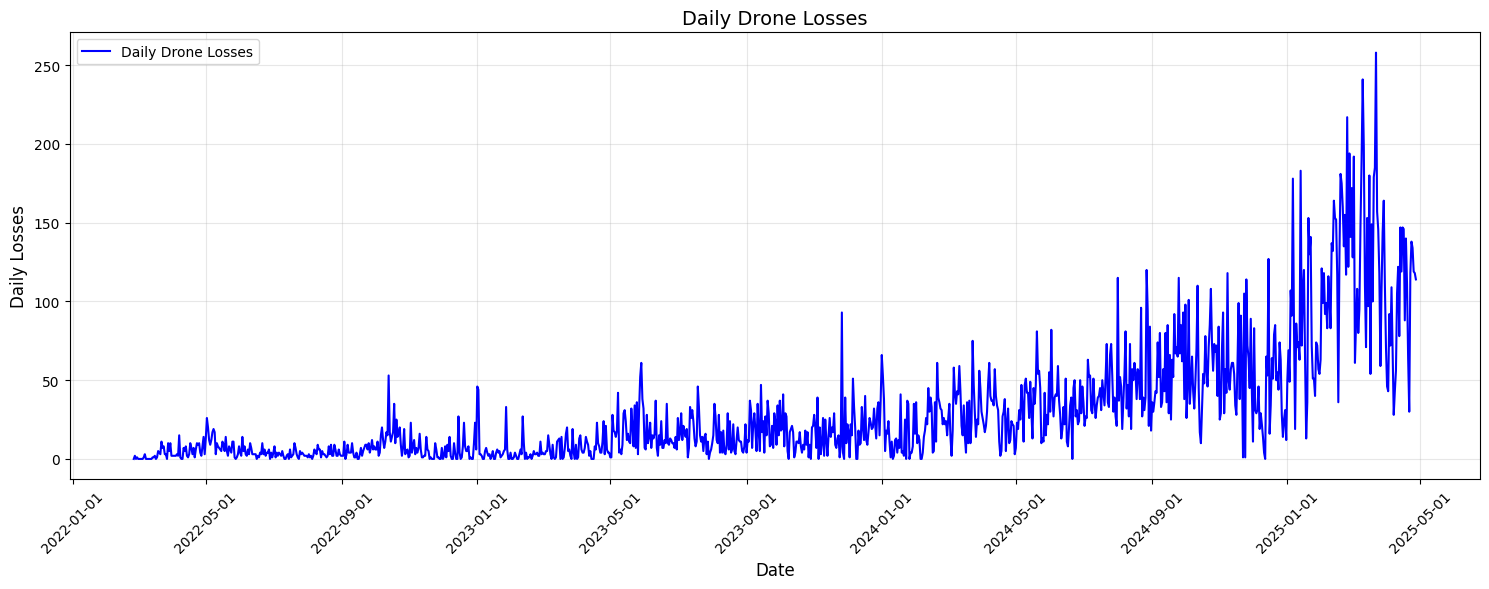

In [62]:
# 1. Daily Drone Losses Line Plot
plt.figure(figsize=(15, 6))
plt.plot(russia_war_losses.index, 
         russia_war_losses["d_drone"], 
         color="blue", 
         linewidth=1.5, 
         label="Daily Drone Losses")
plt.title("Daily Drone Losses", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily Losses", fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Seasonal Decomposition of Daily Drone Losses

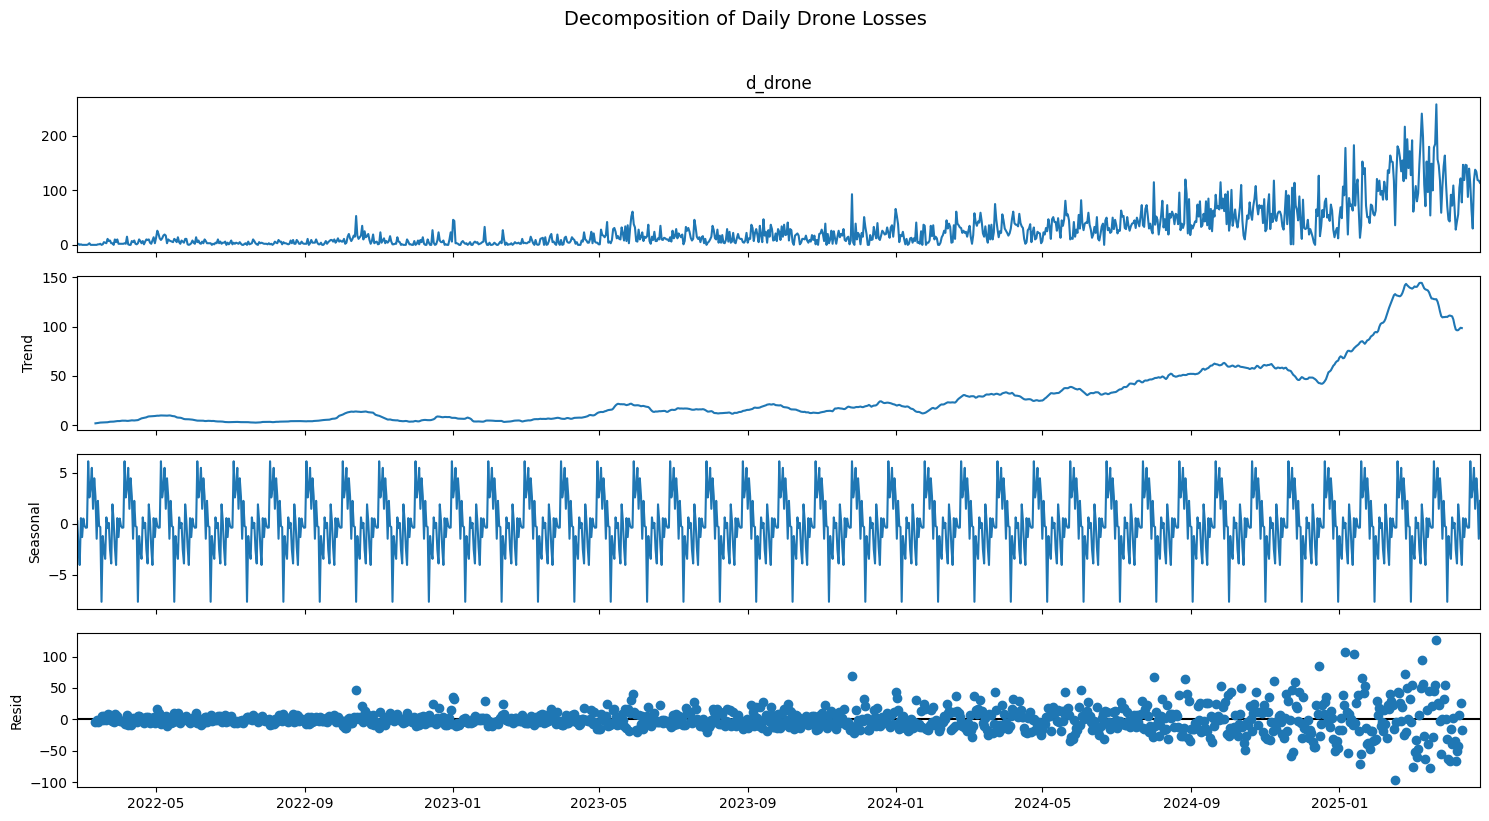

In [63]:
# 2. Seasonal Decomposition of Daily Drone Losses
decomposition = seasonal_decompose(russia_war_losses["d_drone"], model="additive", period=30)  # Monthly period
fig = decomposition.plot()
fig.set_size_inches(15, 8)
plt.suptitle("Decomposition of Daily Drone Losses", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Stationarity Test (ADF) on Daily Drone Losses

In [64]:
# 3. Stationarity Test (ADF) on Daily Drone Losses
print("\n=== ADF Test on Daily Drone Losses ===")
adf_result = adfuller(russia_war_losses["d_drone"].dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value:.3f}")
print("Stationary" if adf_result[1] < 0.05 else "Non-stationary")


=== ADF Test on Daily Drone Losses ===
ADF Statistic: -0.6915809476091218
p-value: 0.8489182265245672
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-stationary


In [65]:
# Differencing
d_drone_diff = russia_war_losses["d_drone"].diff().dropna()

print("\n=== ADF Test on Differenced Daily Drone Losses ===")
adf_result_diff = adfuller(d_drone_diff)
print(f"ADF Statistic: {adf_result_diff[0]}")
print(f"p-value: {adf_result_diff[1]}")
print("Critical Values:")
for key, value in adf_result_diff[4].items():
    print(f"\t{key}: {value:.3f}")
print("Stationary" if adf_result_diff[1] < 0.05 else "Non-stationary")


=== ADF Test on Differenced Daily Drone Losses ===
ADF Statistic: -10.288413823093064
p-value: 3.623432072491757e-18
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary


### ACF and PACF Plots for Daily Drone Losses

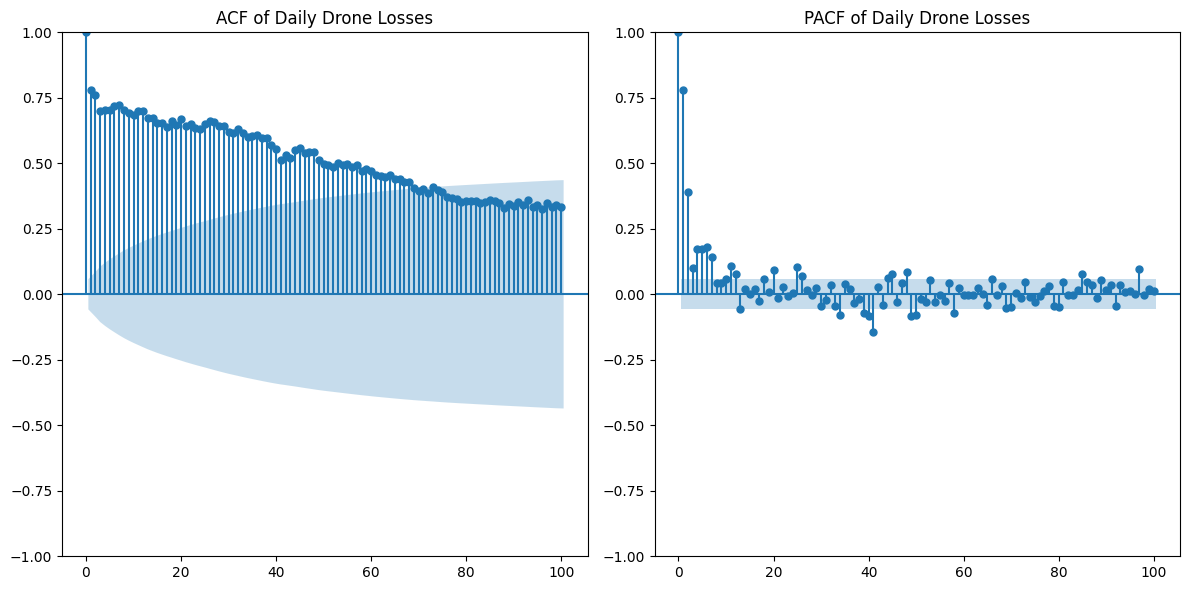

In [66]:
# 4. ACF and PACF Plots for Daily Drone Losses
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(russia_war_losses["d_drone"].dropna(), lags=100, ax=plt.gca())
plt.title("ACF of Daily Drone Losses")
plt.subplot(122)
plot_pacf(russia_war_losses["d_drone"].dropna(), lags=100, ax=plt.gca())
plt.title("PACF of Daily Drone Losses")
plt.tight_layout()
plt.show()

## Forecasting: ARIMA Model for Daily Drone Losses

In [67]:
# %%
# --- ARIMA Forecasting for Daily Drone Losses ---

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Fit ARIMA model on d_drone (using p=1, d=0, q=1 based on ACF/PACF)
# Adjust p, d, q based on your ACF/PACF observations
model = ARIMA(russia_war_losses["d_drone"], order=(60, 1, 7))
model_fit = model.fit()

# Forecast for the next 30 days
forecast = model_fit.forecast(steps=30)
forecast_dates = pd.date_range(start=russia_war_losses.index.max() + timedelta(days=1), 
                              periods=30, freq="D")

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "Forecast": forecast
})

# Plot historical data and forecast
fig_forecast = go.Figure()
fig_forecast.add_trace(go.Scatter(
    x=russia_war_losses.index, 
    y=russia_war_losses["d_drone"], 
    name="Historical", 
    line_color="blue"
))
fig_forecast.add_trace(go.Scatter(
    x=forecast_df["Date"], 
    y=forecast_df["Forecast"], 
    name="Forecast", 
    line_color="red"
))
fig_forecast.update_layout(
    title="ARIMA Forecast of Daily Drone Losses (Next 30 Days)",
    xaxis_title="Date",
    yaxis_title="Daily Drone Losses",
    height=600,
    hovermode="x unified"
)
fig_forecast.show()

# Print forecast summary
print("\n=== ARIMA Forecast Summary ===")
print(model_fit.summary())
print("\nForecast for Next 30 Days:")
print(forecast_df)


=== ARIMA Forecast Summary ===
                               SARIMAX Results                                
Dep. Variable:                d_drone   No. Observations:                 1158
Model:                ARIMA(60, 1, 7)   Log Likelihood               -5011.108
Date:                Wed, 30 Apr 2025   AIC                          10158.217
Time:                        07:24:44   BIC                          10501.860
Sample:                    02-25-2022   HQIC                         10287.898
                         - 04-27-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3801      0.190     -2.002      0.045      -0.752      -0.008
ar.L2          0.0389      0.223      0.174      0.862      -0.399       0.477
ar.L3         -0.119

## ARIMA Model for Daily Drone Losses

In [68]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

# Define the data
data = russia_war_losses["d_drone"].dropna()

# Train-test split (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]
print(f"ARIMA Training set: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"ARIMA Testing set: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")

# Fit ARIMA model
model_arima = ARIMA(train_data, order=(3, 1, 3))  # Adjust based on ACF/PACF
model_arima_fit = model_arima.fit()
print("\n=== ARIMA Model Summary ===")
print(model_arima_fit.summary())

# Test set prediction
test_forecast = model_arima_fit.forecast(steps=len(test_data))
test_forecast_df = pd.DataFrame({
    "Date": test_data.index,
    "Actual": test_data.values,
    "ARIMA Predicted": test_forecast
})

# Evaluation metrics
mae = mean_absolute_error(test_data, test_forecast)
mse = mean_squared_error(test_data, test_forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data - test_forecast) / test_data.clip(lower=1e-10))) * 100
ss_residual = np.sum((test_data - test_forecast) ** 2)
ss_total = np.sum((test_data - np.mean(test_data)) ** 2)
r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan

print("\n=== ARIMA Model Test Set Evaluation Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# Train-test fit visualization
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=train_data.index, y=train_data, name="Training Data", line_color="blue", opacity=0.6))
fig1.add_trace(go.Scatter(x=test_data.index, y=test_data, name="Test Data", line_color="green", opacity=0.6))
fig1.add_trace(go.Scatter(x=test_forecast_df["Date"], y=test_forecast_df["ARIMA Predicted"], name="Test Predictions", line_color="red", line=dict(dash="dash")))
fig1.update_layout(title="ARIMA Model: Train-Test Fit for Daily Drone Losses", xaxis_title="Date", yaxis_title="Daily Drone Losses", height=600, hovermode="x unified", template="plotly_white")
fig1.show()

# Residual analysis
test_forecast_df["ARIMA Residuals"] = test_forecast_df["Actual"] - test_forecast_df["ARIMA Predicted"]
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=test_forecast_df["ARIMA Residuals"], name="Residuals", line_color="purple", mode="lines+markers"))
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=[0] * len(test_forecast_df), name="Zero Line", line=dict(color="black", dash="dash")))
fig2.update_layout(title="ARIMA Model: Residuals on Test Set", xaxis_title="Date", yaxis_title="Residuals", height=500, hovermode="x unified", template="plotly_white")
fig2.show()

# Forecast for next 30 days
model_arima_full = ARIMA(data, order=(3, 1, 3))
model_arima_fit_full = model_arima_full.fit()
forecast = model_arima_fit_full.forecast(steps=30)
forecast_dates = pd.date_range(start=data.index.max() + timedelta(days=1), periods=30, freq="D")
forecast_obj = model_arima_fit_full.get_forecast(steps=30)
conf_int = forecast_obj.conf_int(alpha=0.05)
conf_int.index = forecast_dates
forecast_df = pd.DataFrame({"Date": forecast_dates, "ARIMA Forecast": forecast})
print("\n=== ARIMA Model: Forecast for Next 30 Days ===")
print(forecast_df)

# Forecast visualization
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=data.index, y=data, name="Historical", line_color="blue", opacity=0.6))
fig3.add_trace(go.Scatter(x=forecast_df["Date"], y=forecast_df["ARIMA Forecast"], name="Forecast", line_color="red", line=dict(dash="dash")))
fig3.add_trace(go.Scatter(x=conf_int.index, y=conf_int.iloc[:, 0], name="Lower 95% CI", line=dict(color="rgba(255, 0, 0, 0.2)", width=0), showlegend=False))
fig3.add_trace(go.Scatter(x=conf_int.index, y=conf_int.iloc[:, 1], name="Upper 95% CI", fill="tonexty", fillcolor="rgba(255, 0, 0, 0.2)", line=dict(color="rgba(255, 0, 0, 0.2)", width=0), showlegend=False))
fig3.update_layout(title="ARIMA Model: Forecast of Daily Drone Losses (Next 30 Days)", xaxis_title="Date", yaxis_title="Daily Drone Losses", height=600, hovermode="x unified", template="plotly_white")
fig3.show()

# Metrics table
metrics_df_arima_d_drone = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})
fig4 = go.Figure(data=[go.Table(header=dict(values=["Metric", "Value"], fill_color="black", font=dict(color="white", size=12), align="center"),
                               cells=dict(values=[metrics_df_arima_d_drone["Metric"], metrics_df_arima_d_drone["Value"]], fill_color="white", font=dict(color="black", size=11), align="center"))])
fig4.update_layout(title="ARIMA Model: Test Set Evaluation Metrics", title_x=0.5, height=350, width=600)
fig4.show()

ARIMA Training set: 926 observations (2022-02-25 00:00:00 to 2024-09-07 00:00:00)
ARIMA Testing set: 232 observations (2024-09-08 00:00:00 to 2025-04-27 00:00:00)

=== ARIMA Model Summary ===
                               SARIMAX Results                                
Dep. Variable:                d_drone   No. Observations:                  926
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3618.332
Date:                Wed, 30 Apr 2025   AIC                           7250.663
Time:                        07:24:45   BIC                           7284.472
Sample:                    02-25-2022   HQIC                          7263.561
                         - 09-07-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2


=== ARIMA Model: Forecast for Next 30 Days ===
                 Date  ARIMA Forecast
2025-04-28 2025-04-28      105.243619
2025-04-29 2025-04-29      114.410942
2025-04-30 2025-04-30      116.085107
2025-05-01 2025-05-01      110.902806
2025-05-02 2025-05-02      106.365332
2025-05-03 2025-05-03      106.960809
2025-05-04 2025-05-04      110.467947
2025-05-05 2025-05-05      112.350932
2025-05-06 2025-05-06      111.171651
2025-05-07 2025-05-07      109.107000
2025-05-08 2025-05-08      108.567951
2025-05-09 2025-05-09      109.634379
2025-05-10 2025-05-10      110.701778
2025-05-11 2025-05-11      110.666599
2025-05-12 2025-05-12      109.910138
2025-05-13 2025-05-13      109.439909
2025-05-14 2025-05-14      109.652386
2025-05-15 2025-05-15      110.114376
2025-05-16 2025-05-16      110.270315
2025-05-17 2025-05-17      110.054774
2025-05-18 2025-05-18      109.806747
2025-05-19 2025-05-19      109.792755
2025-05-20 2025-05-20      109.954042
2025-05-21 2025-05-21      110.069070
20

## SARIMA Model for Daily Drone Losses

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train-test split
data = russia_war_losses["d_drone"].dropna()
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]
print(f"SARIMA Training set: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"SARIMA Testing set: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")

# Fit SARIMA model
model_sarima = SARIMAX(train_data, order=(3, 1, 3), seasonal_order=(1, 1, 1, 7))  # Weekly seasonality
model_sarima_fit = model_sarima.fit(disp=False)
print("\n=== SARIMA Model Summary ===")
print(model_sarima_fit.summary())

# Test set prediction
test_forecast = model_sarima_fit.forecast(steps=len(test_data))
test_forecast_df = pd.DataFrame({
    "Date": test_data.index,
    "Actual": test_data.values,
    "SARIMA Predicted": test_forecast
})

# Evaluation metrics
mae = mean_absolute_error(test_data, test_forecast)
mse = mean_squared_error(test_data, test_forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data - test_forecast) / test_data.clip(lower=1e-10))) * 100
ss_residual = np.sum((test_data - test_forecast) ** 2)
ss_total = np.sum((test_data - np.mean(test_data)) ** 2)
r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan

print("\n=== SARIMA Model Test Set Evaluation Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f" vaccinations Metric Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# Train-test fit visualization
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=train_data.index, y=train_data, name="Training Data", line_color="blue", opacity=0.6))
fig1.add_trace(go.Scatter(x=test_data.index, y=test_data, name="Test Data", line_color="green", opacity=0.6))
fig1.add_trace(go.Scatter(x=test_forecast_df["Date"], y=test_forecast_df["SARIMA Predicted"], name="Test Predictions", line_color="red", line=dict(dash="dash")))
fig1.update_layout(title="SARIMA Model: Train-Test Fit for Daily Drone Losses", xaxis_title="Date", yaxis_title="Daily Drone Losses", height=600, hovermode="x unified", template="plotly_white")
fig1.show()

# Residual analysis
test_forecast_df["SARIMA Residuals"] = test_forecast_df["Actual"] - test_forecast_df["SARIMA Predicted"]
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=test_forecast_df["SARIMA Residuals"], name="Residuals", line_color="purple", mode="lines+markers"))
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=[0] * len(test_forecast_df), name="Zero Line", line=dict(color="black", dash="dash")))
fig2.update_layout(title="SARIMA Model: Residuals on Test Set", xaxis_title="Date", yaxis_title="Residuals", height=500, hovermode="x unified", template="plotly_white")
fig2.show()

# Forecast for next 30 days
model_sarima_full = SARIMAX(data, order=(3, 1, 3), seasonal_order=(1, 1, 1, 7))
model_sarima_fit_full = model_sarima_full.fit(disp=False)
forecast = model_sarima_fit_full.forecast(steps=30)
forecast_dates = pd.date_range(start=data.index.max() + timedelta(days=1), periods=30, freq="D")
forecast_obj = model_sarima_fit_full.get_forecast(steps=30)
conf_int = forecast_obj.conf_int(alpha=0.05)
conf_int.index = forecast_dates
forecast_df = pd.DataFrame({"Date": forecast_dates, "SARIMA Forecast": forecast})
print("\n=== SARIMA Model: Forecast for Next 30 Days ===")
print(forecast_df)

# Forecast visualization
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=data.index, y=data, name="Historical", line_color="blue", opacity=0.6))
fig3.add_trace(go.Scatter(x=forecast_df["Date"], y=forecast_df["SARIMA Forecast"], name="Forecast", line_color="red", line=dict(dash="dash")))
fig3.add_trace(go.Scatter(x=conf_int.index, y=conf_int.iloc[:, 0], name="Lower 95% CI", line=dict(color="rgba(255, 0, 0, 0.2)", width=0), showlegend=False))
fig3.add_trace(go.Scatter(x=conf_int.index, y=conf_int.iloc[:, 1], name="Upper 95% CI", fill="tonexty", fillcolor="rgba(255, 0, 0, 0.2)", line=dict(color="rgba(255, 0, 0, 0.2)", width=0), showlegend=False))
fig3.update_layout(title="SARIMA Model: Forecast of Daily Drone Losses (Next 30 Days)", xaxis_title="Date", yaxis_title="Daily Drone Losses", height=600, hovermode="x unified", template="plotly_white")
fig3.show()

# Metrics table
metric_df_sarima_d_drone = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})
fig4 = go.Figure(data=[go.Table(header=dict(values=["Metric", "Value"], fill_color="black", font=dict(color="white", size=12), align="center"),
                               cells=dict(values=[metric_df_sarima_d_drone["Metric"], metric_df_sarima_d_drone["Value"]], fill_color="white", font=dict(color="black", size=11), align="center"))])
fig4.update_layout(title="SARIMA Model: Test Set Evaluation Metrics", title_x=0.5, height=350, width=600)
fig4.show()

SARIMA Training set: 926 observations (2022-02-25 00:00:00 to 2024-09-07 00:00:00)
SARIMA Testing set: 232 observations (2024-09-08 00:00:00 to 2025-04-27 00:00:00)

=== SARIMA Model Summary ===
                                      SARIMAX Results                                      
Dep. Variable:                             d_drone   No. Observations:                  926
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 7)   Log Likelihood               -3622.145
Date:                             Wed, 30 Apr 2025   AIC                           7262.290
Time:                                     07:24:52   BIC                           7305.689
Sample:                                 02-25-2022   HQIC                          7278.853
                                      - 09-07-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025   


=== SARIMA Model: Forecast for Next 30 Days ===
                 Date  SARIMA Forecast
2025-04-28 2025-04-28       103.163794
2025-04-29 2025-04-29       113.435463
2025-04-30 2025-04-30       108.153193
2025-05-01 2025-05-01       116.390446
2025-05-02 2025-05-02       110.979575
2025-05-03 2025-05-03       112.268839
2025-05-04 2025-05-04       112.525210
2025-05-05 2025-05-05       108.680501
2025-05-06 2025-05-06       113.380822
2025-05-07 2025-05-07       106.664503
2025-05-08 2025-05-08       116.026515
2025-05-09 2025-05-09       110.775453
2025-05-10 2025-05-10       113.095884
2025-05-11 2025-05-11       112.682541
2025-05-12 2025-05-12       110.299916
2025-05-13 2025-05-13       113.865276
2025-05-14 2025-05-14       107.410876
2025-05-15 2025-05-15       116.898758
2025-05-16 2025-05-16       111.220053
2025-05-17 2025-05-17       114.370138
2025-05-18 2025-05-18       112.982400
2025-05-19 2025-05-19       111.634941
2025-05-20 2025-05-20       114.356641
2025-05-21 2025

## Auto-ARIMA Model for Daily Drone Losses

In [70]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Define the data
data = russia_war_losses["d_drone"].dropna()

# Automated SARIMA parameter selection
auto_model = auto_arima(data, seasonal=True, m=7, trace=True, suppress_warnings=True, stepwise=True, max_p=3, max_q=3, max_P=2, max_Q=2, information_criterion='aic')
print(f"\nOptimal SARIMA Order: {auto_model.order}")
print(f"Seasonal Order: {auto_model.seasonal_order}")

# Fit SARIMA model
model = SARIMAX(data, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
model_fit = model.fit(disp=False)
print(model_fit.summary())

# Walk-forward validation
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = SARIMAX(history, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])

# Evaluation metrics
test_forecast_df = pd.DataFrame({"Date": test.index, "Actual": test.values, "Auto-ARIMA Predicted": predictions})
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - predictions) / test.clip(lower=1e-10))) * 100
ss_residual = np.sum((test - predictions) ** 2)
ss_total = np.sum((test - np.mean(test)) ** 2)
r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan

print("\n=== Auto-ARIMA Model Test Set Evaluation Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# Train-test fit visualization
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=train.index, y=train, name="Training Data", line_color="blue", opacity=0.6))
fig1.add_trace(go.Scatter(x=test.index, y=test, name="Test Data", line_color="green", opacity=0.6))
fig1.add_trace(go.Scatter(x=test_forecast_df["Date"], y=test_forecast_df["Auto-ARIMA Predicted"], name="Test Predictions", line_color="red", line=dict(dash="dash")))
fig1.update_layout(title="Auto-ARIMA Model: Train-Test Fit for Daily Drone Losses", xaxis_title="Date", yaxis_title="Daily Drone Losses", height=600, hovermode="x unified", template="plotly_white")
fig1.show()

# Residual analysis
test_forecast_df["Auto-ARIMA Residuals"] = test_forecast_df["Actual"] - test_forecast_df["Auto-ARIMA Predicted"]
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=test_forecast_df["Auto-ARIMA Residuals"], name="Residuals", line_color="purple", mode="lines+markers"))
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=[0] * len(test_forecast_df), name="Zero Line", line=dict(color="black", dash="dash")))
fig2.update_layout(title="Auto-ARIMA Model: Residuals on Test Set", xaxis_title="Date", yaxis_title="Residuals", height=500, hovermode="x unified", template="plotly_white")
fig2.show()

# 30-day forecast
final_model = SARIMAX(data, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
final_model_fit = final_model.fit(disp=False)
forecast = final_model_fit.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
forecast_df = pd.DataFrame({"Date": forecast_dates, "Forecast": forecast_mean, "Lower_CI": conf_int.iloc[:, 0], "Upper_CI": conf_int.iloc[:, 1]})
print("\n=== Auto-ARIMA Model: Forecast for Next 30 Days ===")
print(forecast_df)

# Forecast visualization
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=data.index, y=data, name="Historical", line_color="blue", opacity=0.6))
fig3.add_trace(go.Scatter(x=forecast_df["Date"], y=forecast_df["Forecast"], name="Forecast", line_color="red", line=dict(dash="dash")))
fig3.add_trace(go.Scatter(x=forecast_df["Date"], y=forecast_df["Lower_CI"], name="Lower 95% CI", line=dict(color="rgba(255, 0, 0, 0.2)", width=0), showlegend=False))
fig3.add_trace(go.Scatter(x=forecast_df["Date"], y=forecast_df["Upper_CI"], name="Upper 95% CI", fill="tonexty", fillcolor="rgba(255, 0, 0, 0.2)", line=dict(color="rgba(255, 0, 0, 0.2)", width=0), showlegend=False))
fig3.update_layout(title="Auto-ARIMA Model: Forecast of Daily Drone Losses (Next 30 Days)", xaxis_title="Date", yaxis_title="Daily Drone Losses", height=600, hovermode="x unified", template="plotly_white")
fig3.show()

# Metrics table
metric_df_auto_arima_d_drone = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})
fig4 = go.Figure(data=[go.Table(header=dict(values=["Metric", "Value"], fill_color="black", font=dict(color="white", size=12), align="center"),
                               cells=dict(values=[metric_df_auto_arima_d_drone["Metric"], metric_df_auto_arima_d_drone["Value"]], fill_color="white", font=dict(color="black", size=11), align="center"))])
fig4.update_layout(title="Auto-ARIMA Model: Test Set Evaluation Metrics", title_x=0.5, height=350, width=600)
fig4.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=10214.791, Time=2.10 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10723.348, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10442.303, Time=0.40 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10267.294, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10721.366, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=10212.943, Time=1.68 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=10219.385, Time=0.63 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=10214.663, Time=2.87 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=10212.792, Time=2.70 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=10214.791, Time=2.53 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=10216.509, Time=4.30 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=10230.030, Time=1.49 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=10219.634, Time=0.97 sec
 ARIMA(3,1,2)(1,0,0)[7] intercept   : AIC=10215.122, Time=1.52 sec
 ARIMA(2,1,3)(1,0,0


=== Auto-ARIMA Model: Forecast for Next 30 Days ===
                 Date    Forecast   Lower_CI    Upper_CI
2025-04-28 2025-04-28  105.206171  66.409479  144.002863
2025-04-29 2025-04-29  114.412218  74.213843  154.610592
2025-04-30 2025-04-30  116.124420  74.656142  157.592698
2025-05-01 2025-05-01  110.900863  69.181983  152.619743
2025-05-02 2025-05-02  106.317349  64.582958  148.051740
2025-05-03 2025-05-03  106.927099  65.100745  148.753452
2025-05-04 2025-05-04  110.480811  68.197738  152.763884
2025-05-05 2025-05-05  112.377056  69.467552  155.286561
2025-05-06 2025-05-06  111.165771  67.883551  154.447990
2025-05-07 2025-05-07  109.070519  65.618453  152.522585
2025-05-08 2025-05-08  108.539056  64.923474  152.154639
2025-05-09 2025-05-09  109.635511  65.735313  153.535710
2025-05-10 2025-05-10  110.716103  66.430589  155.001617
2025-05-11 2025-05-11  110.665336  66.035012  155.295660
2025-05-12 2025-05-12  109.888129  65.003690  154.772569
2025-05-13 2025-05-13  109.416544  

## Prophet Model for Daily Drone Losses

07:29:50 - cmdstanpy - INFO - Chain [1] start processing
07:29:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet Training set: 926 observations (2022-02-25 00:00:00 to 2024-09-07 00:00:00)
Prophet Testing set: 232 observations (2024-09-08 00:00:00 to 2025-04-27 00:00:00)

=== Prophet Model Components ===
Seasonalities enabled: ['yearly', 'weekly']

=== Prophet Model Test Set Evaluation Metrics ===
Mean Absolute Error (MAE): 46.27
Mean Squared Error (MSE): 3761.16
Root Mean Squared Error (RMSE): 61.33
Mean Absolute Percentage Error (MAPE): nan%
R-squared (R²): -0.5896


07:29:50 - cmdstanpy - INFO - Chain [1] start processing
07:29:51 - cmdstanpy - INFO - Chain [1] done processing



=== Prophet Model: Forecast for Next 30 Days ===
Average forecasted daily losses: 128.7
Forecast range: 117.5 to 148.7


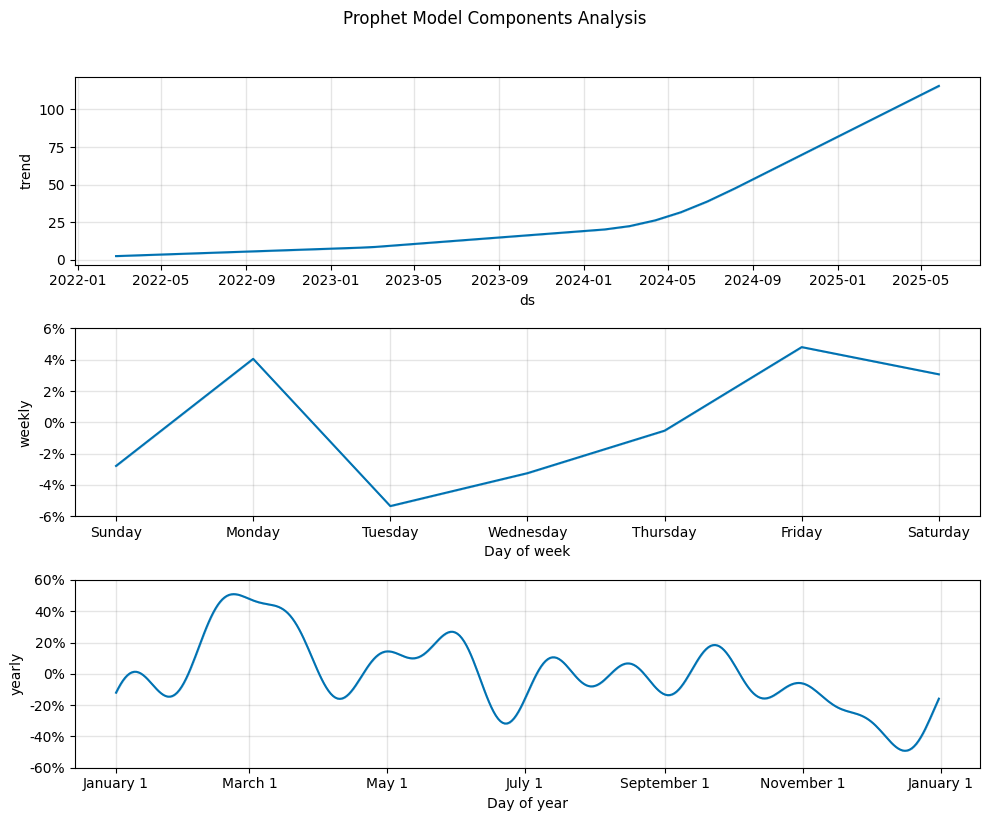

In [71]:
from prophet import Prophet
from sklearn.metrics import r2_score

# Prepare data for Prophet
data = russia_war_losses["d_drone"].dropna()
prophet_data = pd.DataFrame({"ds": data.index, "y": data.values})
train_size = int(len(prophet_data) * 0.8)
train_data = prophet_data[:train_size]
test_data = prophet_data[train_size:]
print(f"Prophet Training set: {len(train_data)} observations ({train_data['ds'].iloc[0]} to {train_data['ds'].iloc[-1]})")
print(f"Prophet Testing set: {len(test_data)} observations ({test_data['ds'].iloc[0]} to {test_data['ds'].iloc[-1]})")

# Fit Prophet model
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.05, seasonality_mode='multiplicative', interval_width=0.95)
model_prophet_fit = model_prophet.fit(train_data)
print("\n=== Prophet Model Components ===")
print(f"Seasonalities enabled: {list(model_prophet.seasonalities.keys())}")

# Test set prediction
test_future = model_prophet.make_future_dataframe(periods=len(test_data), freq='D')
test_future = test_future.tail(len(test_data))
test_forecast = model_prophet.predict(test_future)
test_forecast_df = pd.DataFrame({"Date": test_data['ds'], "Actual": test_data['y'], "Prophet Predicted": test_forecast['yhat']})

# Evaluation metrics
mae = mean_absolute_error(test_data['y'], test_forecast['yhat'])
mse = mean_squared_error(test_data['y'], test_forecast['yhat'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data['y'] - test_forecast['yhat']) / test_data['y'].clip(lower=1e-10))) * 100
r2 = r2_score(test_data['y'], test_forecast['yhat'])

print("\n=== Prophet Model Test Set Evaluation Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# Train-test fit visualization
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=train_data['ds'], y=train_data['y'], name="Training Data", line=dict(color="blue", width=2), opacity=0.7))
fig1.add_trace(go.Scatter(x=test_data['ds'], y=test_data['y'], name="Test Data", line=dict(color="green", width=2), opacity=0.7))
fig1.add_trace(go.Scatter(x=test_forecast['ds'], y=test_forecast['yhat'], name="Test Predictions", line=dict(color="red", width=2, dash="dash")))
fig1.add_trace(go.Scatter(x=test_forecast['ds'], y=test_forecast['yhat_upper'], fill=None, mode='lines', line=dict(width=0), showlegend=False))
fig1.add_trace(go.Scatter(x=test_forecast['ds'], y=test_forecast['yhat_lower'], fill='tonexty', mode='lines', line=dict(width=0), fillcolor='rgba(255, 0, 0, 0.2)', name="95% Confidence Interval"))
fig1.update_layout(title="Prophet Model: Train-Test Fit for Daily Drone Losses", xaxis_title="Date", yaxis_title="Daily Drone Losses", height=600, hovermode="x unified", template="plotly_white")
fig1.show()

# Residual analysis
test_forecast_df["Prophet Residuals"] = test_forecast_df["Actual"] - test_forecast_df["Prophet Predicted"]
fig2 = make_subplots(rows=2, cols=1, vertical_spacing=0.1)
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=test_forecast_df["Prophet Residuals"], name="Residuals", mode="markers", marker=dict(color="purple", size=8, opacity=0.6)), row=1, col=1)
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=[0] * len(test_forecast_df), name="Zero Line", line=dict(color="black", dash="dash")), row=1, col=1)
fig2.add_trace(go.Histogram(x=test_forecast_df["Prophet Residuals"], name="Residuals Distribution", marker_color="purple", opacity=0.7, nbinsx=30), row=2, col=1)
fig2.update_layout(title="Prophet Model: Residual Analysis on Test Set", height=700, hovermode="x unified", template="plotly_white")
fig2.update_xaxes(title_text="Date", row=1, col=1)
fig2.update_yaxes(title_text="Residuals", row=1, col=1)
fig2.update_xaxes(title_text="Residual Value", row=2, col=1)
fig2.update_yaxes(title_text="Count", row=2, col=1)
fig2.show()

# 30-day forecast
model_prophet_full = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.05, seasonality_mode='multiplicative', interval_width=0.95)
model_prophet_fit_full = model_prophet_full.fit(prophet_data)
future = model_prophet_full.make_future_dataframe(periods=30, freq='D')
forecast = model_prophet_full.predict(future)
forecast_future = forecast.tail(30)
forecast_df = pd.DataFrame({"Date": forecast_future['ds'], "Prophet Forecast": forecast_future['yhat'], "Lower Bound": forecast_future['yhat_lower'], "Upper Bound": forecast_future['yhat_upper']})
print("\n=== Prophet Model: Forecast for Next 30 Days ===")
print(f"Average forecasted daily losses: {forecast_df['Prophet Forecast'].mean():.1f}")
print(f"Forecast range: {forecast_df['Prophet Forecast'].min():.1f} to {forecast_df['Prophet Forecast'].max():.1f}")

# Forecast visualization
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=prophet_data['ds'], y=prophet_data['y'], name="Historical", line=dict(color="blue", width=2), opacity=0.7))
fig3.add_trace(go.Scatter(x=forecast_future['ds'], y=forecast_future['yhat'], name="Forecast", line=dict(color="red", width=2, dash="dash")))
fig3.add_trace(go.Scatter(x=forecast_future['ds'], y=forecast_future['yhat_upper'], fill=None, mode='lines', line=dict(width=0), showlegend=False))
fig3.add_trace(go.Scatter(x=forecast_future['ds'], y=forecast_future['yhat_lower'], fill='tonexty', mode='lines', line=dict(width=0), fillcolor='rgba(255, 0, 0, 0.2)', name="95% Confidence Interval"))
fig3.add_shape(type="line", x0=prophet_data['ds'].iloc[-1].strftime('%Y-%m-%d'), x1=prophet_data['ds'].iloc[-1].strftime('%Y-%m-%d'), y0=0, y1=1, yref="paper", line=dict(width=2, dash="dot", color="gray"), name="Forecast Start")
fig3.add_annotation(x=prophet_data['ds'].iloc[-1].strftime('%Y-%m-%d'), y=1, yref="paper", text="Forecast Start", showarrow=False, xanchor="left", yanchor="top")
fig3.update_layout(title="Prophet Model: 30-Day Forecast of Daily Drone Losses", xaxis_title="Date", yaxis_title="Daily Drone Losses", height=600, hovermode="x unified", template="plotly_white")
fig3.show()

# Components analysis
fig_components = model_prophet_full.plot_components(forecast)
plt.suptitle("Prophet Model Components Analysis", y=1.02)
fig_components.set_size_inches(10, 8)
plt.tight_layout()
plt.show()


# Metrics table
metric_df_prophet_d_drone = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", 
               "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})

fig4 = go.Figure(data=[
    go.Table(
        header=dict(
            values=["Metric", "Value"],
            fill_color="black",
            font=dict(color="white", size=12),
            align="center"
        ),
        cells=dict(
            values=[metric_df_prophet_d_drone["Metric"], metric_df_prophet_d_drone["Value"]],
            fill_color="white",
            font=dict(color="black", size=11),
            align="center"
        )
    )
])
fig4.update_layout(
    title="Prophet Model: Test Set Evaluation Metrics",
    title_x=0.5,
    height=350,
    width=600
)
fig4.show()

## LSTM Model for Daily Drone Losses

In [72]:
# import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import plotly.graph_objects as go
from datetime import timedelta

# Prepare data
data = russia_war_losses["d_drone"].dropna()
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
print(f"LSTM Training set: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"LSTM Testing set: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")

# Scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length=7):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 7
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Build LSTM model
model_lstm = Sequential([
    LSTM(128, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
model_lstm.compile(optimizer='adam', loss='mse')

# Fit model
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)
print("\n=== LSTM Model Summary ===")
model_lstm.summary()

# Test set prediction
test_pred_scaled = model_lstm.predict(X_test)
test_pred = scaler.inverse_transform(test_pred_scaled)
test_actual = test_data.values[seq_length:]
test_dates = test_data.index[seq_length:]
test_forecast_df = pd.DataFrame({"Date": test_dates, "Actual": test_actual, "LSTM Predicted": test_pred.flatten()})

# Evaluation metrics
mae = mean_absolute_error(test_actual, test_pred)
mse = mean_squared_error(test_actual, test_pred)
rmse = np.sqrt(mse)
# Fix MAPE calculation: Use np.clip to avoid division by zero
test_actual_clipped = np.clip(test_actual, a_min=1e-10, a_max=None)
mape = np.mean(np.abs((test_actual - test_pred.flatten()) / test_actual_clipped)) * 100
ss_residual = np.sum((test_actual - test_pred.flatten()) ** 2)
ss_total = np.sum((test_actual - np.mean(test_actual)) ** 2)
r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan

print("\n=== LSTM Model Test Set Evaluation Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# Train-test fit visualization
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=train_data.index, y=train_data, name="Training Data", line_color="blue", opacity=0.6))
fig1.add_trace(go.Scatter(x=test_data.index, y=test_data, name="Test Data", line_color="green", opacity=0.6))
fig1.add_trace(go.Scatter(x=test_forecast_df["Date"], y=test_forecast_df["LSTM Predicted"], name="Test Predictions", line_color="red", line=dict(dash="dash")))
fig1.update_layout(
    title="LSTM Model: Train-Test Fit for Daily Drone Losses",
    xaxis_title="Date",
    yaxis_title="Daily Drone Losses",
    height=600,
    hovermode="x unified",
    template="plotly_white"
)
fig1.show()

# Residual analysis
test_forecast_df["LSTM Residuals"] = test_forecast_df["Actual"] - test_forecast_df["LSTM Predicted"]
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=test_forecast_df["LSTM Residuals"], name="Residuals", line_color="purple", mode="lines+markers"))
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=[0] * len(test_forecast_df), name="Zero Line", line=dict(color="black", dash="dash")))
fig2.update_layout(
    title="LSTM Model: Residuals on Test Set",
    xaxis_title="Date",
    yaxis_title="Residuals",
    height=500,
    hovermode="x unified",
    template="plotly_white"
)
fig2.show()

# 30-day forecast
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))
X_full, y_full = create_sequences(data_scaled, seq_length)
model_lstm_full = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model_lstm_full.compile(optimizer='adam', loss='mse')
model_lstm_full.fit(X_full, y_full, epochs=50, batch_size=32, verbose=0)
last_sequence = data_scaled[-seq_length:].reshape(1, seq_length, 1)
forecast_scaled = []
for _ in range(30):
    pred = model_lstm_full.predict(last_sequence, verbose=0)
    forecast_scaled.append(pred[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = pred[0, 0]
forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
forecast_dates = pd.date_range(start=data.index.max() + timedelta(days=1), periods=30, freq="D")
n_bootstrap = 100
bootstrap_forecasts = []
for _ in range(n_bootstrap):
    noise = np.random.normal(0, rmse, 30)
    bootstrap_forecasts.append(forecast + noise)
conf_int_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
conf_int_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)
forecast_df = pd.DataFrame({"Date": forecast_dates, "LSTM Forecast": forecast})
conf_int_df = pd.DataFrame({"Date": forecast_dates, "LSTM Lower 95% CI": conf_int_lower, "LSTM Upper 95% CI": conf_int_upper})
print("\n=== LSTM Model: Forecast for Next 30 Days ===")
print(forecast_df)

# Forecast visualization
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=data.index, y=data, name="Historical", line_color="blue", opacity=0.6))
fig3.add_trace(go.Scatter(x=forecast_df["Date"], y=forecast_df["LSTM Forecast"], name="Forecast", line_color="red", line=dict(dash="dash")))
fig3.add_trace(go.Scatter(x=conf_int_df["Date"], y=conf_int_df["LSTM Lower 95% CI"], name="Lower 95% CI", line=dict(color="rgba(255, 0, 0, 0.2)", width=0), showlegend=False))
fig3.add_trace(go.Scatter(x=conf_int_df["Date"], y=conf_int_df["LSTM Upper 95% CI"], name="Upper 95% CI", fill="tonexty", fillcolor="rgba(255, 0, 0, 0.2)", line=dict(color="rgba(255, 0, 0, 0.2)", width=0), showlegend=False))
fig3.update_layout(
    title="LSTM Model: Forecast of Daily Drone Losses (Next 30 Days)",
    xaxis_title="Date",
    yaxis_title="Daily Drone Losses",
    height=600,
    hovermode="x unified",
    template="plotly_white"
)
fig3.show()

# Metrics table
metric_df_lstm_d_drone = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})
fig4 = go.Figure(data=[go.Table(
    header=dict(values=["Metric", "Value"], fill_color="black", font=dict(color="white", size=12), align="center"),
    cells=dict(values=[
        metric_df_lstm_d_drone["Metric"],
        metric_df_lstm_d_drone["Value"].apply(lambda x: f"{x:.2f}" if x >= 0.01 else f"{x:.4f}")
    ], fill_color="white", font=dict(color="black", size=11), align="center"))
])
fig4.update_layout(
    title="LSTM Model: Test Set Evaluation Metrics for Daily Drone Losses",
    title_x=0.5,
    height=350,
    width=600
)
fig4.show()

LSTM Training set: 926 observations (2022-02-25 00:00:00 to 2024-09-07 00:00:00)
LSTM Testing set: 232 observations (2024-09-08 00:00:00 to 2025-04-27 00:00:00)
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - loss: 0.0170 - val_loss: 0.0545
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 - val_loss: 0.0343
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095 - val_loss: 0.0327
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - val_loss: 0.0356
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087 - val_loss: 0.0319
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - val_loss: 0.0367
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - val_loss: 0.0326
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0398
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097 - val_loss: 0.0363
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - val_loss: 0.0

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 7, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 354,245 (1.35 MB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,164 (922.52 KB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step

=== LSTM Model Test Set Evaluation Metrics ===
Mean Absolute Error (MAE): 54.16
Mean Squared Error (MSE): 5153.23
Root Mean Squared Error (RMSE): 71.79
Mean Absolute Percentage Error (MAPE): 98630244038.83%
R-squared (R²): -1.1489



=== LSTM Model: Forecast for Next 30 Days ===
         Date  LSTM Forecast
0  2025-04-28     123.798546
1  2025-04-29     137.932709
2  2025-04-30     144.652267
3  2025-05-01     146.458435
4  2025-05-02     146.617294
5  2025-05-03     147.360306
6  2025-05-04     149.245041
7  2025-05-05     153.639954
8  2025-05-06     158.055328
9  2025-05-07     161.206757
10 2025-05-08     163.207977
11 2025-05-09     164.538391
12 2025-05-10     165.628418
13 2025-05-11     167.038177
14 2025-05-12     168.783127
15 2025-05-13     170.380142
16 2025-05-14     171.704330
17 2025-05-15     172.713898
18 2025-05-16     173.456131
19 2025-05-17     174.073563
20 2025-05-18     174.698059
21 2025-05-19     175.327728
22 2025-05-20     175.923218
23 2025-05-21     176.459854
24 2025-05-22     176.901138
25 2025-05-23     177.256363
26 2025-05-24     177.560730
27 2025-05-25     177.840363
28 2025-05-26     178.102707
29 2025-05-27     178.347412


TypeError: '>=' not supported between instances of 'str' and 'float'

## XGBoost Model for Daily Drone Losses

In [73]:
from xgboost import XGBRegressor

# Prepare data
data = russia_war_losses["d_drone"].dropna()
def create_features(data, lags=7):
    df = pd.DataFrame({"y": data})
    for i in range(1, lags + 1):
        df[f"lag_{i}"] = df["y"].shift(i)
    df["day_of_week"] = df.index.dayofweek
    df["month"] = df.index.month
    return df.dropna()

lags = 7
features_df = create_features(data, lags)
train_size = int(len(features_df) * 0.8)
train_data = features_df.iloc[:train_size]
test_data = features_df.iloc[train_size:]
X_train = train_data.drop("y", axis=1)
y_train = train_data["y"]
X_test = test_data.drop("y", axis=1)
y_test = test_data["y"]
print(f"XGBoost Training set: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"XGBoost Testing set: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")

# Fit XGBoost model
model_xgboost = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
model_xgboost_fit = model_xgboost.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
print("\n=== XGBoost Model Feature Importance ===")
for feature, importance in zip(X_train.columns, model_xgboost.feature_importances_):
    print(f"{feature}: {importance:.4f}")

# Test set prediction
test_pred = model_xgboost.predict(X_test)
test_forecast_df = pd.DataFrame({"Date": test_data.index, "Actual": y_test, "XGBoost Predicted": test_pred})

# Evaluation metrics
mae = mean_absolute_error(y_test, test_pred)
mse = mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - test_pred) / y_test.clip(lower=1e-10))) * 100
ss_residual = np.sum((y_test - test_pred) ** 2)
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan

print("\n=== XGBoost Model Test Set Evaluation Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# Train-test fit visualization
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=train_data.index, y=train_data["y"], name="Training Data", line_color="blue", opacity=0.6))
fig1.add_trace(go.Scatter(x=test_data.index, y=test_data["y"], name="Test Data", line_color="green", opacity=0.6))
fig1.add_trace(go.Scatter(x=test_forecast_df["Date"], y=test_forecast_df["XGBoost Predicted"], name="Test Predictions", line_color="red", line=dict(dash="dash")))
fig1.update_layout(title="XGBoost Model: Train-Test Fit for Daily Drone Losses", xaxis_title="Date", yaxis_title="Daily Drone Losses", height=600, hovermode="x unified", template="plotly_white")
fig1.show()

# Residual analysis
test_forecast_df["XGBoost Residuals"] = test_forecast_df["Actual"] - test_forecast_df["XGBoost Predicted"]
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=test_forecast_df["XGBoost Residuals"], name="Residuals", line_color="purple", mode="lines+markers"))
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=[0] * len(test_forecast_df), name="Zero Line", line=dict(color="black", dash="dash")))
fig2.update_layout(title="XGBoost Model: Residuals on Test Set", xaxis_title="Date", yaxis_title="Residuals", height=500, hovermode="x unified", template="plotly_white")
fig2.show()

# 30-day forecast
features_full = create_features(data, lags)
X_full = features_full.drop("y", axis=1)
y_full = features_full["y"]
model_xgboost_full = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_xgboost_fit_full = model_xgboost_full.fit(X_full, y_full)
forecast_steps = 30
forecast_dates = pd.date_range(start=data.index.max() + timedelta(days=1), periods=forecast_steps, freq="D")
last_features = features_full.iloc[-1:].copy()
forecast = []
for i in range(forecast_steps):
    pred = model_xgboost_full.predict(last_features.drop("y", axis=1))[0]
    forecast.append(pred)
    new_row = last_features.copy()
    new_row["y"] = pred
    for j in range(lags, 1, -1):
        new_row[f"lag_{j-1}"] = last_features[f"lag_{j}"]
    new_row[f"lag_1"] = pred
    new_row["day_of_week"] = forecast_dates[i].dayofweek
    new_row["month"] = forecast_dates[i].month
    last_features = new_row
n_bootstrap = 100
bootstrap_forecasts = []
for _ in range(n_bootstrap):
    noise = np.random.normal(0, rmse, forecast_steps)
    bootstrap_forecasts.append(np.array(forecast) + noise)
conf_int_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
conf_int_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)
forecast_df = pd.DataFrame({"Date": forecast_dates, "XGBoost Forecast": forecast})
conf_int_df = pd.DataFrame({"Date": forecast_dates, "XGBoost Lower 95% CI": conf_int_lower, "XGBoost Upper 95% CI": conf_int_upper})
print("\n=== XGBoost Model: Forecast for Next 30 Days ===")
print(forecast_df)

# Forecast visualization
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=data.index, y=data, name="Historical", line_color="blue", opacity=0.6))
fig3.add_trace(go.Scatter(x=forecast_df["Date"], y=forecast_df["XGBoost Forecast"], name="Forecast", line_color="red", line=dict(dash="dash")))
fig3.add_trace(go.Scatter(x=conf_int_df["Date"], y=conf_int_df["XGBoost Lower 95% CI"], name="Lower 95% CI", line=dict(color="rgba(255, 0, 0, 0.2)", width=0), showlegend=False))
fig3.add_trace(go.Scatter(x=conf_int_df["Date"], y=conf_int_df["XGBoost Upper 95% CI"], name="Upper 95% CI", fill="tonexty", fillcolor="rgba(255, 0, 0, 0.2)", line=dict(color="rgba(255, 0, 0, 0.2)", width=0), showlegend=False))
fig3.update_layout(title="XGBoost Model: Forecast of Daily Drone Losses (Next 30 Days)", xaxis_title="Date", yaxis_title="Daily Drone Losses", height=600, hovermode="x unified", template="plotly_white")
fig3.show()

# Metrics table
metric_df_xgboost_d_drone = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})
fig4 = go.Figure(data=[go.Table(header=dict(values=["Metric", "Value"], fill_color="black", font=dict(color="white", size=12), align="center"),
                               cells=dict(values=[metric_df_xgboost_d_drone["Metric"], metric_df_xgboost_d_drone["Value"]], fill_color="white", font=dict(color="black", size=11), align="center"))])
fig4.update_layout(title="XGBoost Model: Test Set Evaluation Metrics", title_x=0.5, height=350, width=600)
fig4.show()

XGBoost Training set: 920 observations (2022-03-04 00:00:00 to 2024-09-08 00:00:00)
XGBoost Testing set: 231 observations (2024-09-09 00:00:00 to 2025-04-27 00:00:00)

=== XGBoost Model Feature Importance ===
lag_1: 0.2906
lag_2: 0.1271
lag_3: 0.0829
lag_4: 0.0472
lag_5: 0.1521
lag_6: 0.0925
lag_7: 0.0889
day_of_week: 0.0412
month: 0.0774

=== XGBoost Model Test Set Evaluation Metrics ===
Mean Absolute Error (MAE): 46.41
Mean Squared Error (MSE): 3847.88
Root Mean Squared Error (RMSE): 62.03
Mean Absolute Percentage Error (MAPE): 90864743078.22%
R-squared (R²): -0.6193



=== XGBoost Model: Forecast for Next 30 Days ===
         Date  XGBoost Forecast
0  2025-04-28        113.358307
1  2025-04-29         83.995064
2  2025-04-30         99.553452
3  2025-05-01        133.700684
4  2025-05-02         57.485966
5  2025-05-03         61.482128
6  2025-05-04         64.929329
7  2025-05-05         69.296684
8  2025-05-06         65.966087
9  2025-05-07         66.712883
10 2025-05-08         66.712883
11 2025-05-09         69.592674
12 2025-05-10         68.092865
13 2025-05-11         68.588478
14 2025-05-12         72.955772
15 2025-05-13         64.734428
16 2025-05-14         62.004917
17 2025-05-15         62.004917
18 2025-05-16         64.884727
19 2025-05-17         64.929329
20 2025-05-18         64.929329
21 2025-05-19         69.296684
22 2025-05-20         65.966087
23 2025-05-21         66.712883
24 2025-05-22         66.712883
25 2025-05-23         69.592674
26 2025-05-24         68.092865
27 2025-05-25         68.588478
28 2025-05-26         

## VAR Model for Daily Drone Losses

In [74]:
from statsmodels.tsa.api import VAR

# Prepare data
data = russia_war_losses[["d_drone", "d_tank", "d_field artillery", "d_vehicles and fuel tanks"]].dropna()
for col in data.columns:
    data[col] = data[col].clip(lower=data[col].quantile(0.01), upper=data[col].quantile(0.99))
original_drone = russia_war_losses["d_drone"].loc[data.index]
data["d_drone"] = data["d_drone"].diff().dropna()
data["d_field artillery"] = data["d_field artillery"].diff().dropna()
data["d_vehicles and fuel tanks"] = data["d_vehicles and fuel tanks"].diff().dropna()
data = data.dropna()
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
train_original_drone = original_drone.loc[train_data.index]
test_original_drone = original_drone.loc[test_data.index]
print(f"VAR Training set: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"VAR Testing set: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")

# Fit VAR model
model_var = VAR(train_data)
model_var_fit = model_var.fit(maxlags=15, ic="bic")
print("\n=== VAR Model Summary ===")
print(f"Selected lag order: {model_var_fit.k_ar}")
print(model_var_fit.summary())

# Test set prediction
forecast_steps = len(test_data)
forecast = model_var_fit.forecast(train_data.values[-model_var_fit.k_ar:], steps=forecast_steps)
test_pred_diff = forecast[:, 0]
last_train_drone = original_drone[train_data.index[-1]]
test_pred = np.cumsum(test_pred_diff) + last_train_drone
test_forecast_df = pd.DataFrame({"Date": test_data.index, "Actual": test_original_drone.values, "VAR Predicted": test_pred})

# Evaluation metrics
mae = mean_absolute_error(test_data["d_drone"], test_pred_diff)
mse = mean_squared_error(test_data["d_drone"], test_pred_diff)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data["d_drone"] - test_pred_diff) / test_data["d_drone"].clip(lower=1e-10))) * 100
ss_residual = np.sum((test_data["d_drone"] - test_pred_diff) ** 2)
ss_total = np.sum((test_data["d_drone"] - np.mean(test_data["d_drone"])) ** 2)
r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan

print("\n=== VAR Model Test Set Evaluation Metrics (d_drone, Differenced) ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# Train-test fit visualization
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=train_data.index, y=train_original_drone, name="Training Data", line_color="blue", opacity=0.6))
fig1.add_trace(go.Scatter(x=test_data.index, y=test_original_drone, name="Test Data", line_color="green", opacity=0.6))
fig1.add_trace(go.Scatter(x=test_forecast_df["Date"], y=test_forecast_df["VAR Predicted"], name="Test Predictions", line_color="red", line=dict(dash="dash")))
fig1.update_layout(title="VAR Model: Train-Test Fit for Daily Drone Losses (Original Scale)", xaxis_title="Date", yaxis_title="Daily Drone Losses", height=600, hovermode="x unified", template="plotly_white")
fig1.show()

# Residual analysis
test_forecast_df["VAR Residuals"] = test_data["d_drone"].values - test_pred_diff
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=test_forecast_df["VAR Residuals"], name="Residuals", line_color="purple", mode="lines+markers"))
fig2.add_trace(go.Scatter(x=test_forecast_df["Date"], y=[0] * len(test_forecast_df), name="Zero Line", line=dict(color="black", dash="dash")))
fig2.update_layout(title="VAR Model: Residuals on Test Set (d_drone, Differenced)", xaxis_title="Date", yaxis_title="Residuals", height=500, hovermode="x unified", template="plotly_white")
fig2.show()

# 30-day forecast
model_var_full = VAR(data)
model_var_fit_full = model_var_full.fit(maxlags=15, ic="bic")
forecast = model_var_fit_full.forecast(data.values[-model_var_fit_full.k_ar:], steps=30)
forecast_drone_diff = forecast[:, 0]
forecast_dates = pd.date_range(start=data.index.max() + timedelta(days=1), periods=30, freq="D")
last_drone = russia_war_losses["d_drone"].iloc[-1]
forecast_drone = np.cumsum(forecast_drone_diff) + last_drone
cov_matrix = model_var_fit_full.forecast_cov(steps=30)
std_errors = np.sqrt(np.diagonal(cov_matrix, axis1=1, axis2=2)[:, 0])
conf_int_lower_diff = forecast_drone_diff - 1.96 * std_errors
conf_int_upper_diff = forecast_drone_diff + 1.96 * std_errors
conf_int_lower = np.cumsum(conf_int_lower_diff) + last_drone
conf_int_upper = np.cumsum(conf_int_upper_diff) + last_drone
forecast_df = pd.DataFrame({"Date": forecast_dates, "VAR Forecast (d_drone)": forecast_drone})
conf_int_df = pd.DataFrame({"Date": forecast_dates, "VAR Lower 95% CI": conf_int_lower, "VAR Upper 95% CI": conf_int_upper})
print("\n=== VAR Model: Forecast for Next 30 Days (d_drone) ===")
print(forecast_df)

# Forecast visualization
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=russia_war_losses.index, y=russia_war_losses["d_drone"], name="Historical", line_color="blue", opacity=0.6))
fig3.add_trace(go.Scatter(x=forecast_df["Date"], y=forecast_df["VAR Forecast (d_drone)"], name="Forecast", line_color="red", line=dict(dash="dash")))
fig3.add_trace(go.Scatter(x=conf_int_df["Date"], y=conf_int_df["VAR Lower 95% CI"], name="Lower 95% CI", line=dict(color="rgba(255, 0, 0, 0.2)", width=0), showlegend=False))
fig3.add_trace(go.Scatter(x=conf_int_df["Date"], y=conf_int_df["VAR Upper 95% CI"], name="Upper 95% CI", fill="tonexty", fillcolor="rgba(255, 0, 0, 0.2)", line=dict(color="rgba(255, 0, 0, 0.2)", width=0), showlegend=False))
fig3.update_layout(title="VAR Model: Forecast of Daily Drone Losses (Next 30 Days, Original Scale)", xaxis_title="Date", yaxis_title="Daily Drone Losses", height=600, hovermode="x unified", template="plotly_white")
fig3.show()

# Metrics table
metric_df_var_d_drone = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "Mean Absolute Percentage Error (MAPE)", "R-squared (R²)"],
    "Value": [f"{mae:.2f}", f"{mse:.2f}", f"{rmse:.2f}", f"{mape:.2f}%", f"{r2:.4f}"]
})
fig4 = go.Figure(data=[go.Table(header=dict(values=["Metric", "Value"], fill_color="black", font=dict(color="white", size=12), align="center"),
                               cells=dict(values=[metric_df_var_d_drone["Metric"], metric_df_var_d_drone["Value"]], fill_color="white", font=dict(color="black", size=11), align="center"))])
fig4.update_layout(title="VAR Model: Test Set Evaluation Metrics (d_drone, Differenced)", title_x=0.5, height=350, width=600)
fig4.show()

VAR Training set: 872 observations (2022-05-03 00:00:00 to 2024-09-20 00:00:00)
VAR Testing set: 219 observations (2024-09-21 00:00:00 to 2025-04-27 00:00:00)

=== VAR Model Summary ===
Selected lag order: 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 30, Apr, 2025
Time:                     07:33:09
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    18.2007
Nobs:                     868.000    HQIC:                   17.9702
Log likelihood:          -12595.6    FPE:                5.52467e+07
AIC:                      17.8273    Det(Omega_mle):     5.11225e+07
--------------------------------------------------------------------
Results for equation d_drone
                                  coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------


=== VAR Model: Forecast for Next 30 Days (d_drone) ===
         Date  VAR Forecast (d_drone)
0  2025-04-28              111.474951
1  2025-04-29              124.638156
2  2025-04-30              121.772154
3  2025-05-01              123.720333
4  2025-05-02              124.634426
5  2025-05-03              118.666422
6  2025-05-04              119.307488
7  2025-05-05              119.881678
8  2025-05-06              120.835512
9  2025-05-07              122.632934
10 2025-05-08              122.825567
11 2025-05-09              121.819532
12 2025-05-10              121.414274
13 2025-05-11              121.131275
14 2025-05-12              121.542971
15 2025-05-13              122.188825
16 2025-05-14              122.487186
17 2025-05-15              122.486518
18 2025-05-16              122.356167
19 2025-05-17              122.265505
20 2025-05-18              122.372216
21 2025-05-19              122.587922
22 2025-05-20              122.787193
23 2025-05-21              122.9

## Comparison of Forecasting Models for Daily Drone Losses

In [75]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# List of model metrics DataFrames
model_metrics = {
    "ARIMA": metrics_df_arima_d_drone,
    "SARIMA": metric_df_sarima_d_drone,
    "Auto-ARIMA": metric_df_auto_arima_d_drone,
    "Prophet": metric_df_prophet_d_drone,
    "LSTM": metric_df_lstm_d_drone,
    "XGBoost": metric_df_xgboost_d_drone,
    "VAR": metric_df_var_d_drone
}

# Aggregate metrics for comparison
metrics_summary = []
for model_name, df in model_metrics.items():
    metric_dict = {"Model": model_name}
    for _, row in df.iterrows():
        # Convert Value to float, handling potential string inputs
        try:
            metric_dict[row["Metric"]] = float(row["Value"])
        except (ValueError, TypeError):
            print(f"Warning: Could not convert {row['Value']} for {model_name} {row['Metric']} to float. Setting to NaN.")
            metric_dict[row["Metric"]] = float('nan')
    metrics_summary.append(metric_dict)

metrics_df = pd.DataFrame(metrics_summary)

# 1. Metrics Table Visualization
fig1 = go.Figure(data=[go.Table(
    header=dict(
        values=["Model", "MAE", "MSE", "RMSE", "MAPE (%)", "R²"],
        fill_color="black",
        font=dict(color="white", size=12),
        align="center"
    ),
    cells=dict(
        values=[
            metrics_df["Model"],
            metrics_df["Mean Absolute Error (MAE)"].round(2),
            metrics_df["Mean Squared Error (MSE)"].round(2),
            metrics_df["Root Mean Squared Error (RMSE)"].round(2),
            metrics_df["Mean Absolute Percentage Error (MAPE)"].round(2),
            metrics_df["R-squared (R²)"].round(4)
        ],
        fill_color="white",
        font=dict(color="black", size=11),
        align="center"
    ))
])
fig1.update_layout(
    title="Evaluation Metrics for Daily Drone Losses Models",
    title_x=0.5,
    height=400,
    width=800
)
fig1.show()

# 2. Metrics Bar Plots with Dynamic Y-Axis Ranges
fig2 = make_subplots(
    rows=3, cols=2,
    subplot_titles=("MAE", "MSE", "RMSE", "MAPE (%)", "R²"),
    vertical_spacing=0.15,
    horizontal_spacing=0.1,
    specs=[[{"colspan": 1}, {"colspan": 1}],
           [{"colspan": 1}, {"colspan": 1}],
           [{"colspan": 1}, None]]  # Last cell is empty
)

fig2.add_trace(
    go.Bar(x=metrics_df["Model"], y=metrics_df["Mean Absolute Error (MAE)"], name="MAE", marker_color="blue"),
    row=1, col=1
)
fig2.add_trace(
    go.Bar(x=metrics_df["Model"], y=metrics_df["Mean Squared Error (MSE)"], name="MSE", marker_color="green"),
    row=1, col=2
)
fig2.add_trace(
    go.Bar(x=metrics_df["Model"], y=metrics_df["Root Mean Squared Error (RMSE)"], name="RMSE", marker_color="orange"),
    row=2, col=1
)
fig2.add_trace(
    go.Bar(x=metrics_df["Model"], y=metrics_df["Mean Absolute Percentage Error (MAPE)"], name="MAPE", marker_color="red"),
    row=2, col=2
)
fig2.add_trace(
    go.Bar(x=metrics_df["Model"], y=metrics_df["R-squared (R²)"], name="R²", marker_color="purple"),
    row=3, col=1
)

# Calculate dynamic y-axis ranges with padding
padding = 0.1  # 10% padding above/below min/max
def get_yaxis_range(values):
    # Handle NaN values
    values = values.dropna()
    if len(values) == 0:
        return [0, 1]  # Default range if all NaN
    min_val = values.min()
    max_val = values.max()
    range_span = max_val - min_val
    padding_val = range_span * padding if range_span > 0 else 0.1  # Avoid zero span
    return [min_val - padding_val, max_val + padding_val]

# Update y-axis ranges
fig2.update_yaxes(
    title_text="MAE",
    range=get_yaxis_range(metrics_df["Mean Absolute Error (MAE)"]),
    row=1, col=1
)
fig2.update_yaxes(
    title_text="MSE",
    range=get_yaxis_range(metrics_df["Mean Squared Error (MSE)"]),
    row=1, col=2
)
fig2.update_yaxes(
    title_text="RMSE",
    range=get_yaxis_range(metrics_df["Root Mean Squared Error (RMSE)"]),
    row=2, col=1
)
fig2.update_yaxes(
    title_text="MAPE (%)",
    range=get_yaxis_range(metrics_df["Mean Absolute Percentage Error (MAPE)"]),
    row=2, col=2
)
fig2.update_yaxes(
    title_text="R²",
    range=get_yaxis_range(metrics_df["R-squared (R²)"]),
    row=3, col=1
)

fig2.update_layout(
    title="Metric Comparison Across Models for Daily Drone Losses",
    height=900,
    width=1000,
    showlegend=False,
    template="plotly_white"
)
fig2.update_xaxes(tickangle=45, title_text="Model")
fig2.show()